In [1]:
# ===============================
# Core Python & Utilities
# ===============================
import numpy as np
import pandas as pd
import random

# ===============================
# Data Loading
# ===============================
import GEOparse

# ===============================
# Scikit-learn
# ===============================
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    GroupKFold,
    GridSearchCV,
    LeaveOneOut
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    matthews_corrcoef,
    make_scorer
)
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# ===============================
# PyTorch
# ===============================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# ===============================
# TensorFlow / Keras (legacy / experiments)
# ===============================
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers

# ===============================
# Visualization & Notebook tools
# ===============================
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline


2026-02-05 19:58:03.441815: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-05 19:58:03.481827: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-05 19:58:04.727239: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gse = GEOparse.get_GEO("GSE68951", destdir="../data")
print(gse)

05-Feb-2026 19:58:06 DEBUG utils - Directory ../data already exists. Skipping.
05-Feb-2026 19:58:06 INFO GEOparse - File already exist: using local version.
05-Feb-2026 19:58:06 INFO GEOparse - Parsing ../data/GSE68951_family.soft.gz: 
05-Feb-2026 19:58:06 DEBUG GEOparse - DATABASE: GeoMiame
05-Feb-2026 19:58:06 DEBUG GEOparse - SERIES: GSE68951
05-Feb-2026 19:58:06 DEBUG GEOparse - PLATFORM: GPL16770
05-Feb-2026 19:58:06 DEBUG GEOparse - SAMPLE: GSM1688368
05-Feb-2026 19:58:06 DEBUG GEOparse - SAMPLE: GSM1688369
05-Feb-2026 19:58:06 DEBUG GEOparse - SAMPLE: GSM1688370
05-Feb-2026 19:58:06 DEBUG GEOparse - SAMPLE: GSM1688371
05-Feb-2026 19:58:06 DEBUG GEOparse - SAMPLE: GSM1688372
05-Feb-2026 19:58:06 DEBUG GEOparse - SAMPLE: GSM1688373
05-Feb-2026 19:58:06 DEBUG GEOparse - SAMPLE: GSM1688374
05-Feb-2026 19:58:06 DEBUG GEOparse - SAMPLE: GSM1688375
05-Feb-2026 19:58:06 DEBUG GEOparse - SAMPLE: GSM1688376
05-Feb-2026 19:58:06 DEBUG GEOparse - SAMPLE: GSM1688377
05-Feb-2026 19:58:06 DEBU

<SERIES: GSE68951 - 215 SAMPLES, 1 d(s)>


In [3]:
sample = gse.gsms["GSM1688406"]
sample.table.tail()


ID_REF     VALUE
1200   hsa-miR-100  1.936057
1201   hsa-miR-101  4.114362
1202  hsa-miR-1289  1.735477
1203  hsa-miR-1288  2.192123
1204   hsa-miR-105  1.285812

In [4]:
def extract_full_info(gse):
    data = []
    for gsm_id, sample in gse.gsms.items():
        meta = sample.metadata["characteristics_ch1"]
        patient_id, timepoint, disease = None, None, None
        for item in meta:
            if item.startswith("patient id"):
                patient_id = item.split(":")[1].strip()
            if item.startswith("timepoint"):
                timepoint = int(item.split(":")[1].strip())
            if item.startswith("disease"):
                disease = item.split(":")[1].strip()
        if patient_id is None or timepoint is None:
            continue
        mirnas = sample.table["ID_REF"].values
        expr = sample.table["VALUE"].values.astype(float)
        data.append({
            "gsm": gsm_id,
            "patient": patient_id,
            "timepoint": timepoint,
            "mirna_names": mirnas,
            "expression": expr
        })
    return pd.DataFrame(data)

In [5]:
df_all = extract_full_info(gse)
df_all.head()



gsm patient  timepoint  \
0  GSM1688368       A          1   
1  GSM1688369       A          2   
2  GSM1688370       A          3   
3  GSM1688371       A          4   
4  GSM1688372       A          5   

                                         mirna_names  \
0  [hsa-miR-507, hsa-miR-548d-5p, hsa-miR-1976, h...   
1  [hsa-miR-507, hsa-miR-548d-5p, hsa-miR-1976, h...   
2  [hsa-miR-507, hsa-miR-548d-5p, hsa-miR-1976, h...   
3  [hsa-miR-507, hsa-miR-548d-5p, hsa-miR-1976, h...   
4  [hsa-miR-507, hsa-miR-548d-5p, hsa-miR-1976, h...   

                                          expression  
0  [1.854979099, 2.184182338, 2.532296403, 1.5180...  
1  [1.469763084, 2.320244044, 2.111889095, 1.6172...  
2  [1.44937518, 2.510284729, 2.083508284, 1.23588...  
3  [1.777522456, 2.724678628, 3.012721615, 1.3907...  
4  [1.538218176, 2.030509973, 2.470374907, 1.5635...

In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from tqdm.notebook import tqdm  
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
df_all_reset = df_all.reset_index(drop=True)
X = np.vstack(df_all_reset["expression"].values)
patients = df_all_reset["patient"].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
patient_to_idx = {p: i for i, p in enumerate(np.unique(patients))}
y = np.array([patient_to_idx[p] for p in patients])
n_classes = len(np.unique(y))  # Number of unique patients/classes


print(f"Hasta sayısı: {len(np.unique(patients))}")
print(f"Toplam örnek: {len(X)}")

Hasta sayısı: 27
Toplam örnek: 215


In [8]:
class SiameseDataset(Dataset):
    def __init__(self, X, y, n_classes):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = y
        self.n_classes = n_classes
        self.patient_indices = {}
        for cls in range(n_classes):
            self.patient_indices[cls] = np.where(y == cls)[0].tolist()
    
    def __len__(self):
        # Improvement: The actual number of triplets is approximate (1 pos + 1 neg for each anchor)
        return len(self.X) * self.n_classes  # More stable, but it could be larger.
    
    def __getitem__(self, idx):
        anchor_idx = random.randint(0, len(self.X) - 1)
        anchor = self.X[anchor_idx]
        anchor_label = self.y[anchor_idx]
        # Positive
        same_idxs = self.patient_indices[anchor_label]
        if len(same_idxs) < 2:
            positive = anchor.clone()
        else:
            pos_idx = random.choice([i for i in same_idxs if i != anchor_idx])
            positive = self.X[pos_idx]
        # Negative
        neg_label = random.choice([c for c in range(self.n_classes) if c != anchor_label])
        neg_idx = random.choice(self.patient_indices[neg_label])
        negative = self.X[neg_idx]
        return anchor, positive, negative, 1.0  


In [9]:
class EmbeddingNet(nn.Module):
    def __init__(self, input_dim=1205, emb_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.25),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.25),
            
            nn.Linear(256, emb_dim),
        )
    
    def forward(self, x):
        return self.net(x)


class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super().__init__()
        self.margin = margin
    
    def forward(self, anchor, positive, negative):
        pos_dist = (anchor - positive).pow(2).sum(1)
        neg_dist = (anchor - negative).pow(2).sum(1)
        losses = F.relu(pos_dist - neg_dist + self.margin)
        return losses.mean()

In [10]:
def train_siamese(model, train_loader, optimizer, criterion, device, epochs=30):
    model.train()
    losses = []
    
    for epoch in range(1, epochs + 1):
        total_loss = 0.0
        n_batches = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
        for anchor, pos, neg, _ in pbar:
            anchor = anchor.to(device)
            pos     = pos.to(device)
            neg     = neg.to(device)
            
            optimizer.zero_grad()
            
            emb_a = model(anchor)
            emb_p = model(pos)
            emb_n = model(neg)
            
            loss = criterion(emb_a, emb_p, emb_n)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            n_batches += 1
            
            pbar.set_postfix({'loss': f"{loss.item():.4f}"})
        
        avg_loss = total_loss / n_batches
        losses.append(avg_loss)
        print(f"Epoch {epoch:2d} | Avg Loss: {avg_loss:.4f}")
    
    # Loss grafiği
    plt.figure(figsize=(10,4))
    plt.plot(losses, label='Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Triplet Loss')
    plt.title('Training loss')
    plt.legend()
    plt.grid(True)
    plt.show()

Device used: cuda


Epoch 1/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9998


Epoch 2/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4613


Epoch 3/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2433


Epoch 4/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1601


Epoch 5/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1298


Epoch 6/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1234


Epoch 7/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0786


Epoch 8/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0758


Epoch 9/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0534


Epoch 10/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0677


Epoch 11/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0602


Epoch 12/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0646


Epoch 13/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0654


Epoch 14/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0557


Epoch 15/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0400


Epoch 16/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 16 | Avg Loss: 0.0398


Epoch 17/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 17 | Avg Loss: 0.0369


Epoch 18/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 18 | Avg Loss: 0.0511


Epoch 19/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 19 | Avg Loss: 0.0306


Epoch 20/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 20 | Avg Loss: 0.0389


Epoch 21/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 21 | Avg Loss: 0.0332


Epoch 22/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 22 | Avg Loss: 0.0201


Epoch 23/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 23 | Avg Loss: 0.0462


Epoch 24/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 24 | Avg Loss: 0.0257


Epoch 25/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 25 | Avg Loss: 0.0261


Epoch 26/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 26 | Avg Loss: 0.0386


Epoch 27/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 27 | Avg Loss: 0.0367


Epoch 28/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 28 | Avg Loss: 0.0349


Epoch 29/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 29 | Avg Loss: 0.0165


Epoch 30/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 30 | Avg Loss: 0.0354


Epoch 31/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 31 | Avg Loss: 0.0262


Epoch 32/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 32 | Avg Loss: 0.0374


Epoch 33/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 33 | Avg Loss: 0.0345


Epoch 34/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 34 | Avg Loss: 0.0227


Epoch 35/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 35 | Avg Loss: 0.0321


Epoch 36/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 36 | Avg Loss: 0.0265


Epoch 37/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 37 | Avg Loss: 0.0259


Epoch 38/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 38 | Avg Loss: 0.0448


Epoch 39/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 39 | Avg Loss: 0.0200


Epoch 40/40:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 40 | Avg Loss: 0.0275


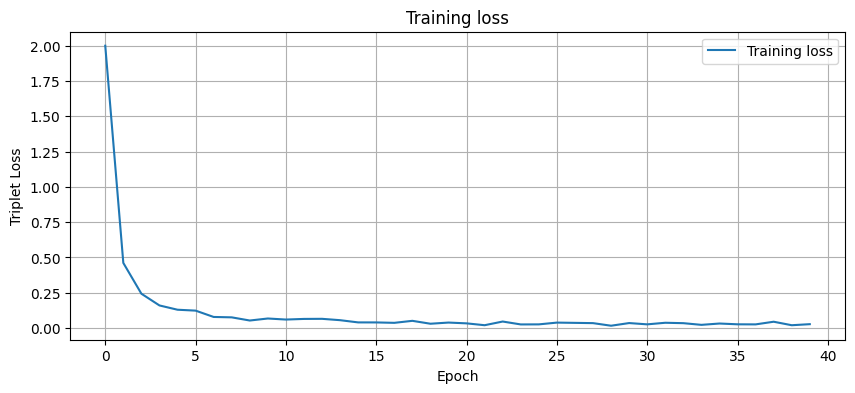

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used:", device)

# Model, loss, optimizer
embedding_net = EmbeddingNet(input_dim=X.shape[1], emb_dim=128).to(device)
criterion = TripletLoss(margin=0.7)
optimizer = optim.Adam(embedding_net.parameters(), lr=3e-4, weight_decay=1e-5)

# Dataset & Loader
dataset = SiameseDataset(X, y, n_classes)
loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0, drop_last=True)

# Eğitimi başlat
train_siamese(embedding_net, loader, optimizer, criterion, device, epochs=40)

In [12]:
def get_embeddings(model, X_tensor, device, batch_size=128):
    model.eval()
    embs = []
    with torch.no_grad():
        for i in range(0, len(X_tensor), batch_size):
            batch = X_tensor[i:i+batch_size].to(device)
            emb = model(batch)
            embs.append(emb.cpu())
    return torch.cat(embs).numpy()


In [13]:
# First, compute the embeddings using the trained model
X_tensor = torch.tensor(X, dtype=torch.float32)
embeddings = get_embeddings(embedding_net, X_tensor, device)

# Now proceed with NearestNeighbors
nn_model = NearestNeighbors(n_neighbors=6, metric='cosine')
nn_model.fit(embeddings)

distances, indices = nn_model.kneighbors(embeddings)

# Rank-1
correct_rank1 = 0
for i in range(len(y)):
    nearest = indices[i, 1]  # 0 → self
    if y[i] == y[nearest]:
        correct_rank1 += 1

rank1_acc = correct_rank1 / len(y)
print(f"Rank-1 Accuracy: {rank1_acc:.4f} ({correct_rank1}/{len(y)})")

# Rank-5
correct_rank5 = 0
for i in range(len(y)):
    neighbors = indices[i, 1:6]
    if y[i] in set(y[neighbors]):
        correct_rank5 += 1

rank5_acc = correct_rank5 / len(y)
print(f"Rank-5 Accuracy: {rank5_acc:.4f} ({correct_rank5}/{len(y)})")

Rank-1 Accuracy: 0.9953 (214/215)
Rank-5 Accuracy: 0.9953 (214/215)


In [14]:
# Weak Attacker Demo: Direct Cosine Similarity without Siamese (simple re-identification)
from sklearn.metrics.pairwise import cosine_similarity

# Example LOO (same setup)
rank1_weak = 0
total_weak = 0
rank5_weak = 0
patient_groups = df_all_reset.groupby("patient")


for patient_name, group in tqdm(patient_groups, desc="Weak Attacker"):
    patient_indices = group.index.values
    if len(patient_indices) < 2: continue
    for test_idx in patient_indices:
        train_mask = np.ones(len(X), dtype=bool)
        train_mask[test_idx] = False
        train_emb = X[train_mask]  # Use raw X (no embedding)
        test_emb = X[test_idx:test_idx+1]
        
        sims = cosine_similarity(test_emb, train_emb)[0]
        top_idx = np.argsort(sims)[-5:]  # Top-5 most similar samples
        neighbor_labels = y[train_mask][top_idx]
        true_label = y[test_idx]
        
        if true_label == neighbor_labels[0]:
            rank1_weak += 1
        if true_label in neighbor_labels:
            rank5_weak += 1  # add: rank5_weak = 0; total_weak += 1
        total_weak += 1

print(f"Weak Attacker (Cosine): Rank-1 {rank1_weak/total_weak:.3f}")
# Expected: ~0.2–0.3 (lower performance, worse than Siamese)


Weak Attacker:   0%|          | 0/27 [00:00<?, ?it/s]

Weak Attacker (Cosine): Rank-1 0.116



Fold 1/5
Fold 1: 22 hasta (train)


Epoch 1/20:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.2353


Epoch 2/20:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.5409


Epoch 3/20:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.3154


Epoch 4/20:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1925


Epoch 5/20:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1471


Epoch 6/20:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1148


Epoch 7/20:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0870


Epoch 8/20:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.1093


Epoch 9/20:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0719


Epoch 10/20:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0585


Epoch 11/20:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0490


Epoch 12/20:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0671


Epoch 13/20:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0487


Epoch 14/20:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0456


Epoch 15/20:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0288


Epoch 16/20:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 16 | Avg Loss: 0.0557


Epoch 17/20:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 17 | Avg Loss: 0.0383


Epoch 18/20:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 18 | Avg Loss: 0.0247


Epoch 19/20:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 19 | Avg Loss: 0.0241


Epoch 20/20:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 20 | Avg Loss: 0.0424


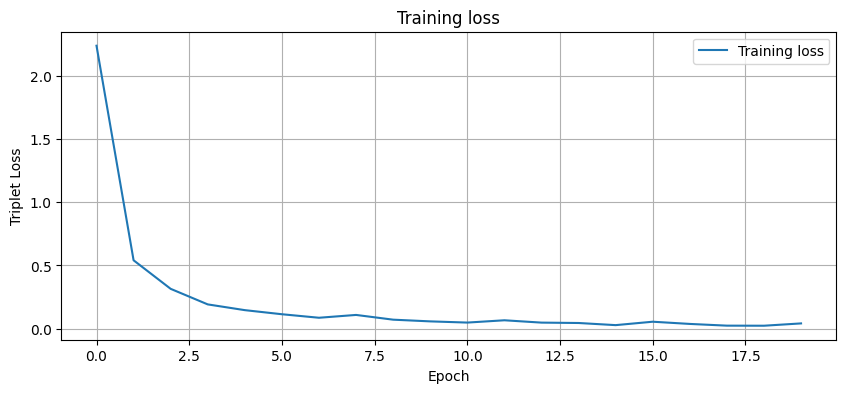

Fold 1 → Rank-1: 0.0000   Rank-5: 0.0000  (0/43)

Fold 2/5
Fold 2: 21 hasta (train)


Epoch 1/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.2340


Epoch 2/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.5499


Epoch 3/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.3222


Epoch 4/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.2196


Epoch 5/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1594


Epoch 6/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1155


Epoch 7/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1013


Epoch 8/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0811


Epoch 9/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0806


Epoch 10/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0797


Epoch 11/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0837


Epoch 12/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0594


Epoch 13/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0583


Epoch 14/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0643


Epoch 15/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0722


Epoch 16/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 16 | Avg Loss: 0.0369


Epoch 17/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 17 | Avg Loss: 0.0649


Epoch 18/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 18 | Avg Loss: 0.0615


Epoch 19/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 19 | Avg Loss: 0.0483


Epoch 20/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 20 | Avg Loss: 0.0249


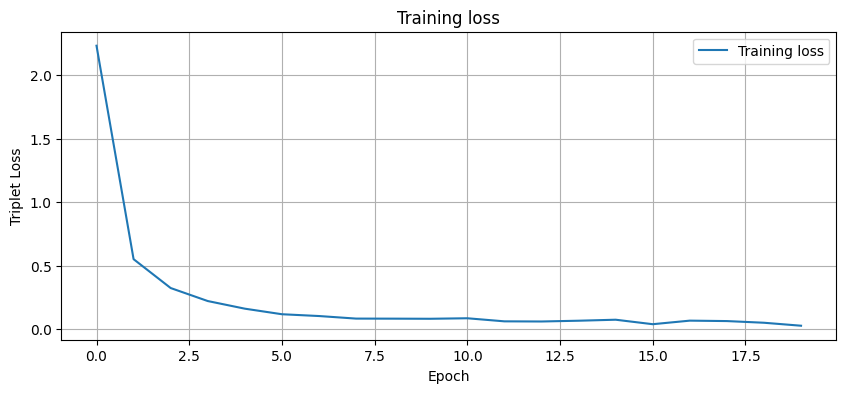

Fold 2 → Rank-1: 0.0000   Rank-5: 0.0000  (0/46)

Fold 3/5
Fold 3: 22 hasta (train)


Epoch 1/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.3696


Epoch 2/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.6191


Epoch 3/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.3063


Epoch 4/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.2069


Epoch 5/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1347


Epoch 6/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1252


Epoch 7/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0981


Epoch 8/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.1040


Epoch 9/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0720


Epoch 10/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0740


Epoch 11/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0461


Epoch 12/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0530


Epoch 13/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0414


Epoch 14/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0372


Epoch 15/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0371


Epoch 16/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 16 | Avg Loss: 0.0441


Epoch 17/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 17 | Avg Loss: 0.0402


Epoch 18/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 18 | Avg Loss: 0.0435


Epoch 19/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 19 | Avg Loss: 0.0488


Epoch 20/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 20 | Avg Loss: 0.0636


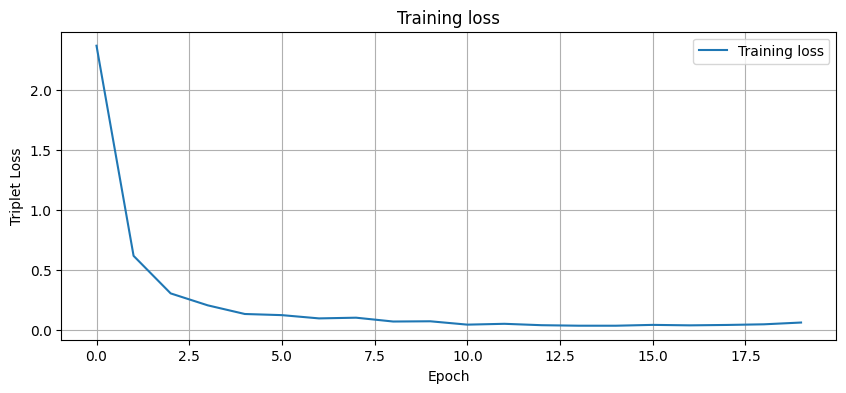

Fold 3 → Rank-1: 0.0000   Rank-5: 0.0000  (0/40)

Fold 4/5
Fold 4: 22 hasta (train)


Epoch 1/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.3419


Epoch 2/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.5572


Epoch 3/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2799


Epoch 4/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.2015


Epoch 5/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1461


Epoch 6/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1285


Epoch 7/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1031


Epoch 8/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0990


Epoch 9/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0737


Epoch 10/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0582


Epoch 11/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0644


Epoch 12/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0511


Epoch 13/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0563


Epoch 14/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0476


Epoch 15/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0481


Epoch 16/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 16 | Avg Loss: 0.0586


Epoch 17/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 17 | Avg Loss: 0.0327


Epoch 18/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 18 | Avg Loss: 0.0500


Epoch 19/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 19 | Avg Loss: 0.0336


Epoch 20/20:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 20 | Avg Loss: 0.0331


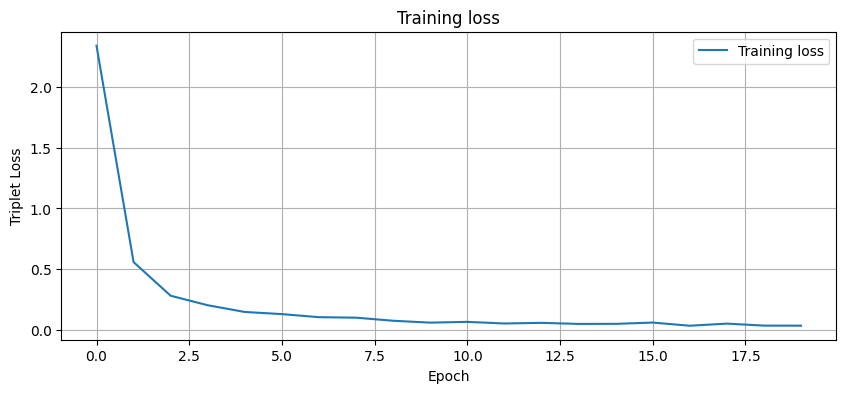

Fold 4 → Rank-1: 0.0000   Rank-5: 0.0000  (0/40)

Fold 5/5
Fold 5: 21 hasta (train)


Epoch 1/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.7627


Epoch 2/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.7094


Epoch 3/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.3706


Epoch 4/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.2932


Epoch 5/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1696


Epoch 6/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1761


Epoch 7/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1314


Epoch 8/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0973


Epoch 9/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0812


Epoch 10/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0971


Epoch 11/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0862


Epoch 12/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0605


Epoch 13/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0536


Epoch 14/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0524


Epoch 15/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0500


Epoch 16/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 16 | Avg Loss: 0.0683


Epoch 17/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 17 | Avg Loss: 0.0456


Epoch 18/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 18 | Avg Loss: 0.0422


Epoch 19/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 19 | Avg Loss: 0.0338


Epoch 20/20:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 20 | Avg Loss: 0.0509


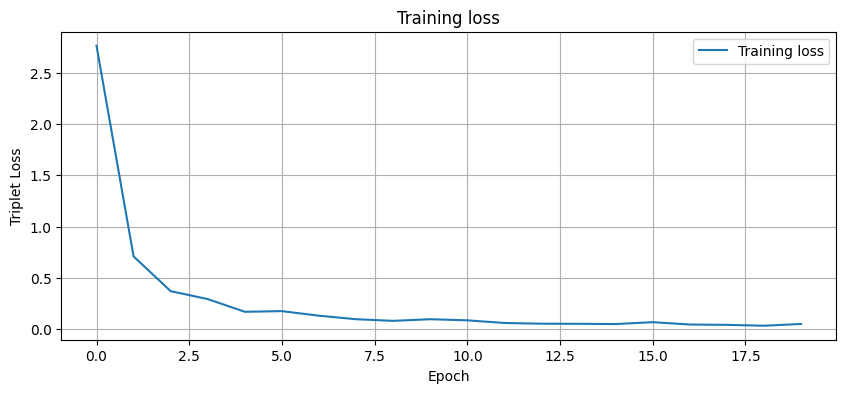

Fold 5 → Rank-1: 0.0000   Rank-5: 0.0000  (0/46)

5-Fold CV Results
Average Rank-1 : 0.0000 ± 0.0000
Average Rank-5 : 0.0000 ± 0.0000


In [15]:
from sklearn.model_selection import GroupKFold
from sklearn.neighbors import NearestNeighbors
import numpy as np
import torch
# Expected outcome 0 because as mentioned in the presentation GroupKFold is not a right way to go for this problem
gkf = GroupKFold(n_splits=5)
fold_results = []

for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=y), 1):
    print(f"\nFold {fold_idx}/5")
    
    X_train_fold = X[train_idx]
    X_test_fold  = X[test_idx]
    y_train_orig = y[train_idx]
    y_test_orig  = y[test_idx]
    
    # Renumber patient IDs from 0 for the fold
    unique_train_pids = np.unique(y_train_orig)
    pid_remap = {old: new for new, old in enumerate(unique_train_pids)}
    y_train_remap = np.array([pid_remap[pid] for pid in y_train_orig])
    
    n_classes_this_fold = len(unique_train_pids)
    print(f"Fold {fold_idx}: {n_classes_this_fold} hasta (train)")
    
    # Dataset ve loader
    train_dataset_fold = SiameseDataset(X_train_fold, y_train_remap, n_classes_this_fold)
    train_loader_fold = DataLoader(
        train_dataset_fold,
        batch_size=64,
        shuffle=True,
        num_workers=0,
        drop_last=True
    )
    
    # ───── Create a NEW model in each fold ─────
    embedding_model = EmbeddingNet(input_dim=X.shape[1], emb_dim=128).to(device)
    
    opt = optim.Adam(embedding_model.parameters(), lr=3e-4, weight_decay=1e-5)
    loss_fn = TripletLoss(margin=0.7)
    
    # Train
    train_siamese(
        embedding_model,
        train_loader_fold,
        opt,
        loss_fn,
        device,
        epochs=20   # can be adjusted
    )
    
    # All data embeddings (model is now trained)
    embeddings_all = get_embeddings(embedding_model, torch.tensor(X, dtype=torch.float32), device)
    
    emb_test  = embeddings_all[test_idx]
    emb_train = embeddings_all[train_idx]
    labels_train_remap = y_train_remap
    
    # Neighbor finding model (different names to avoid name conflicts)
    nbrs = NearestNeighbors(n_neighbors=6, metric='cosine')
    nbrs.fit(emb_train)  # .numpy() removed, already NumPy now
    
    distances, indices = nbrs.kneighbors(emb_test)  # .numpy() removed
    
    rank1_count = 0
    rank5_count = 0
    n_test_samples = len(test_idx)
    
    for i in range(n_test_samples):
        neighbor_remapped_ids = labels_train_remap[indices[i]]
        neighbor_original_ids = [unique_train_pids[rid] for rid in neighbor_remapped_ids]
        true_pid = y_test_orig[i]
        
        if true_pid == neighbor_original_ids[0]:
            rank1_count += 1
        if true_pid in neighbor_original_ids[:5]:
            rank5_count += 1
    
    r1 = rank1_count / n_test_samples if n_test_samples > 0 else 0.0
    r5 = rank5_count / n_test_samples if n_test_samples > 0 else 0.0
    
    print(f"Fold {fold_idx} → Rank-1: {r1:.4f}   Rank-5: {r5:.4f}  ({rank1_count}/{n_test_samples})")
    fold_results.append((r1, r5))

# Results
if fold_results:
    avg_r1 = np.mean([x[0] for x in fold_results])
    avg_r5 = np.mean([x[1] for x in fold_results])
    std_r1 = np.std([x[0] for x in fold_results])
    std_r5 = np.std([x[1] for x in fold_results])
    
    print("\n" + "="*40)
    print(f"5-Fold CV Results")
    print(f"Average Rank-1 : {avg_r1:.4f} ± {std_r1:.4f}")
    print(f"Average Rank-5 : {avg_r5:.4f} ± {std_r5:.4f}")
    print("="*40)

Leave-one-out:   0%|          | 0/215 [00:00<?, ?it/s]

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0159


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4076


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2130


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1415


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1317


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1228


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1020


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0613


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0571


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0541


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0585


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0479


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0521


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0475


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0557


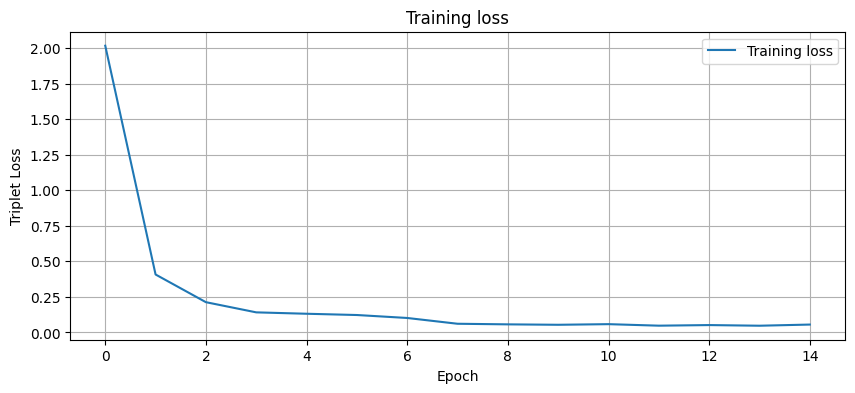

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9532


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4539


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2391


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1665


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1202


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1069


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1066


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.1095


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0698


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0613


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0479


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0536


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0572


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0360


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0432


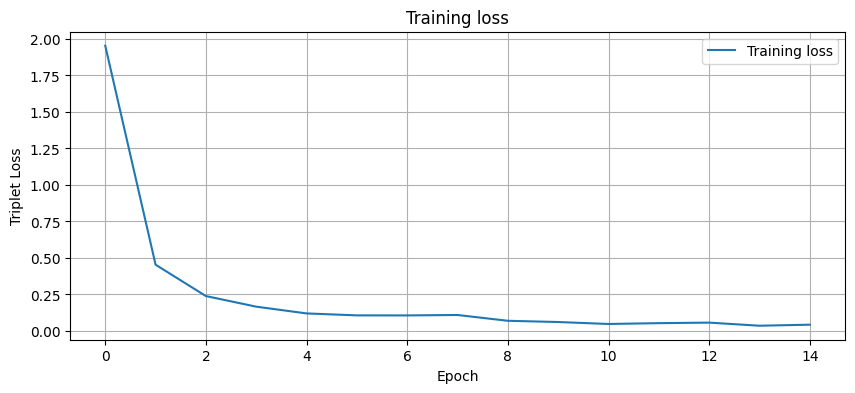

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0826


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4875


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2467


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1552


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1322


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1096


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0782


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0676


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0761


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0776


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0620


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0563


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0612


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0448


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0387


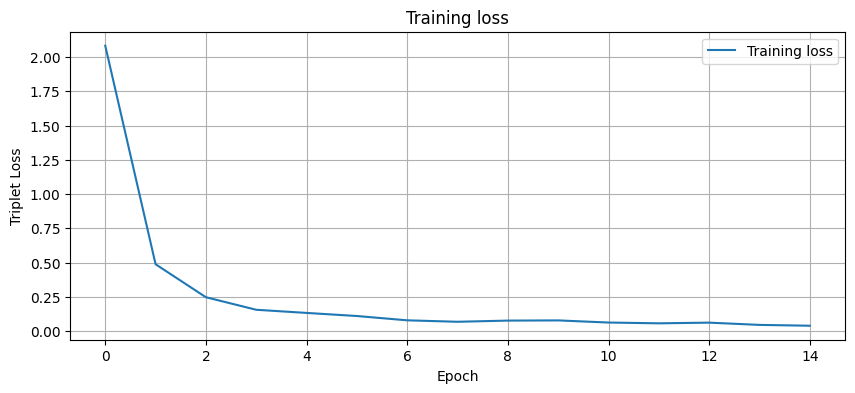

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9569


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4458


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2604


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1605


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1319


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1169


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1028


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0962


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0716


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0501


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0708


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0546


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0394


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0737


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0296


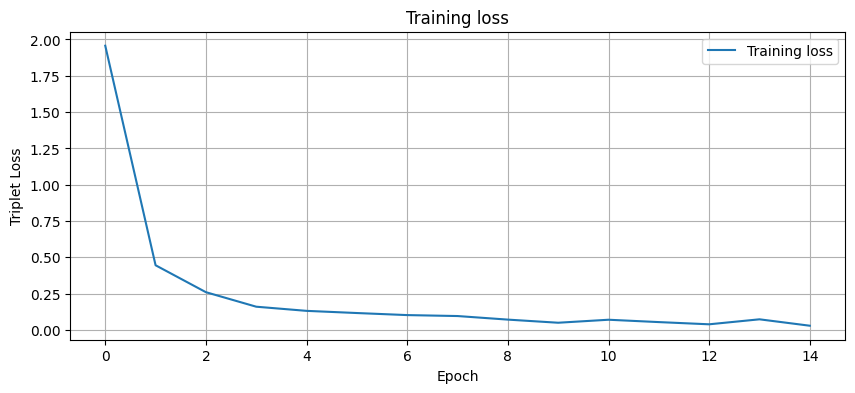

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.8173


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4128


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2338


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1638


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1230


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1084


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0823


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0664


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0523


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0645


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0562


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0483


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0641


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0449


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0479


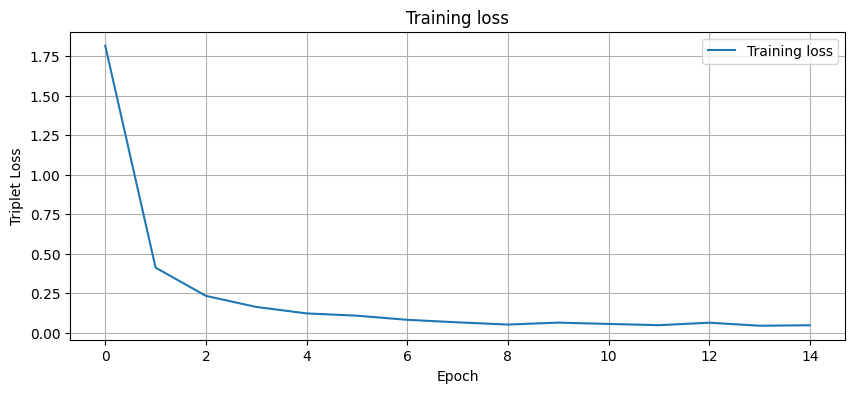

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0163


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.5066


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2404


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1628


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1307


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1275


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1008


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0751


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0719


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0755


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0631


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0648


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0441


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0550


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0498


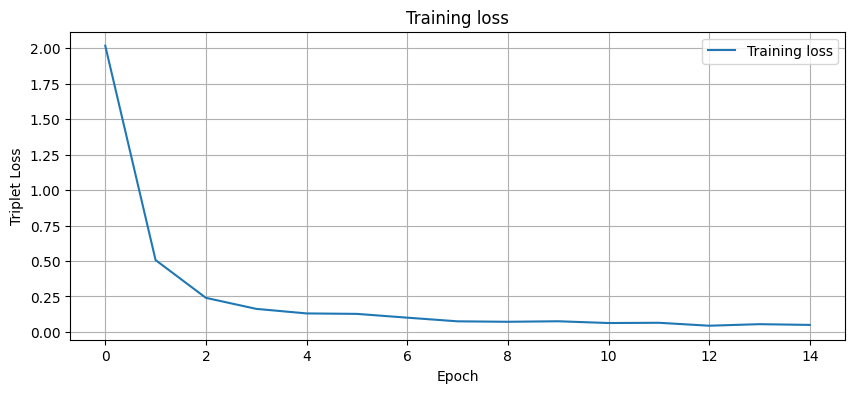

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9400


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4422


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2681


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1341


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1307


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1216


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0719


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0680


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0726


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0606


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0598


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0517


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0586


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0488


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0421


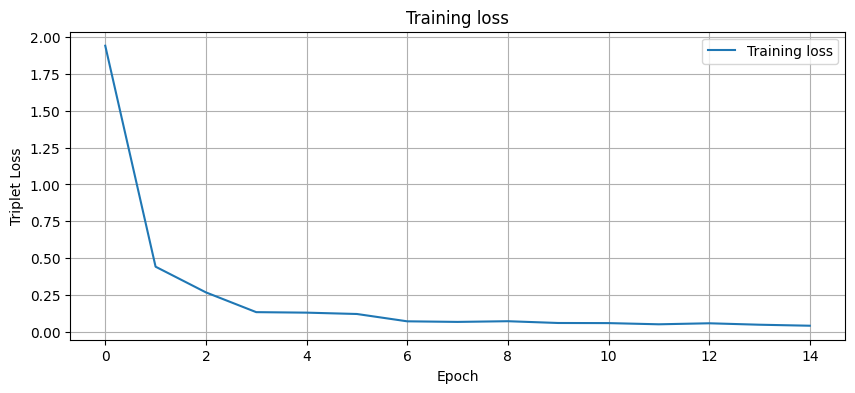

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9549


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4698


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2756


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.2140


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1279


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0843


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1037


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0734


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0639


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0681


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0610


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0617


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0527


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0463


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0327


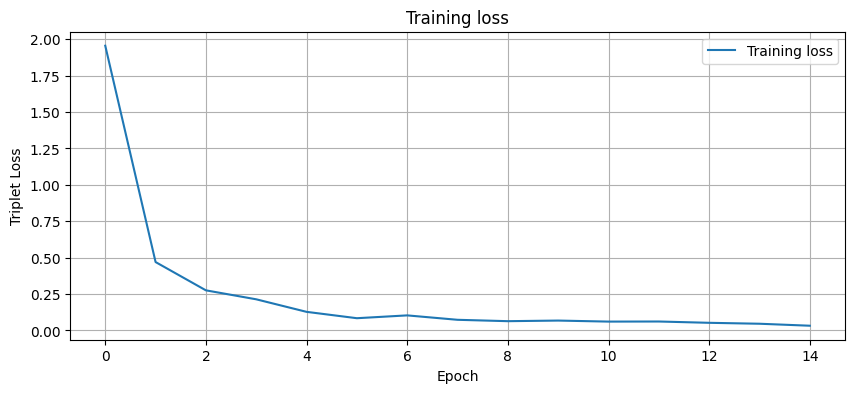

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0208


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4082


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2926


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1645


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1189


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1116


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1117


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0632


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0770


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0710


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0541


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0491


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0450


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0463


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0584


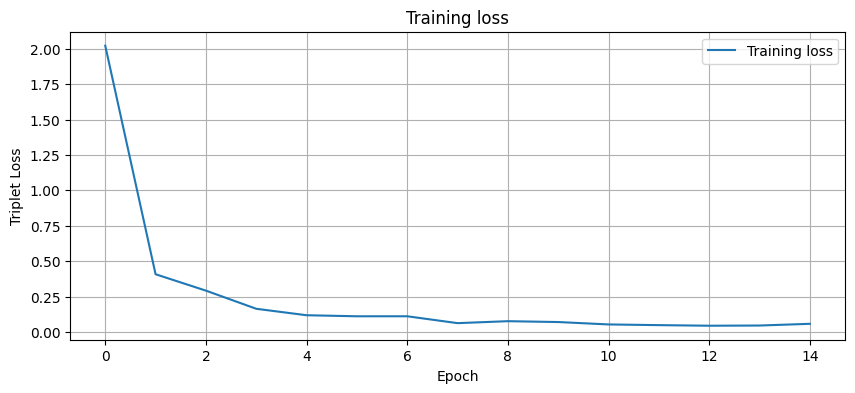

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0025


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4359


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2242


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1377


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1566


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1020


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1087


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0591


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0914


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0705


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0609


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0748


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0481


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0469


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0574


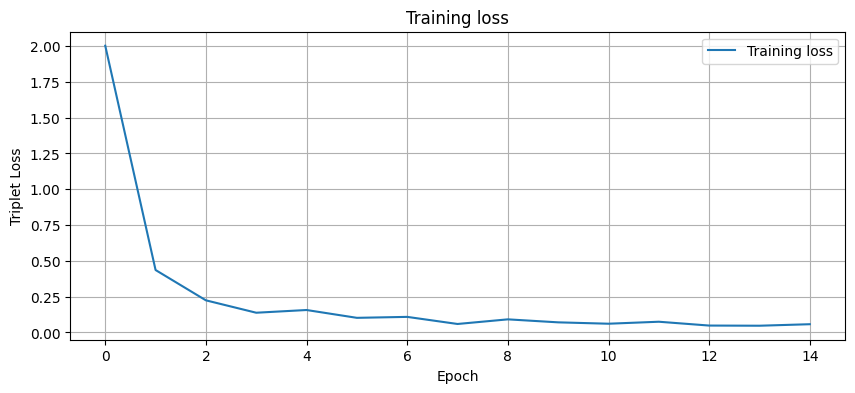

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0565


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4546


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2406


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.2055


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1095


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0788


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0906


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0728


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0922


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0558


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0624


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0563


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0584


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0348


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0307


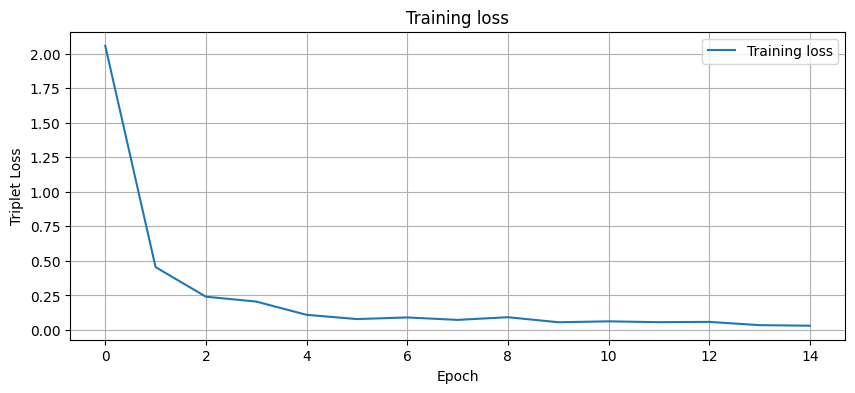

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0600


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4647


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2129


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1540


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1282


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1034


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0990


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0893


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0769


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0868


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0578


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0512


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0563


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0575


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0644


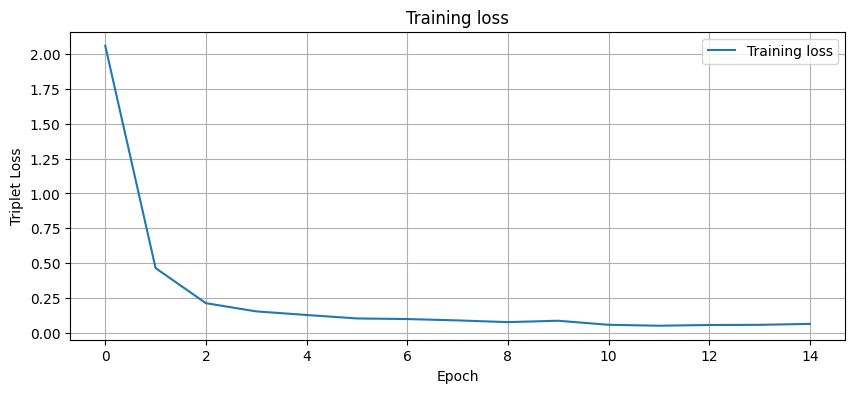

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0313


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4609


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2574


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1720


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1655


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1087


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0820


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0691


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0670


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0716


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0626


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0546


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0463


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0544


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0340


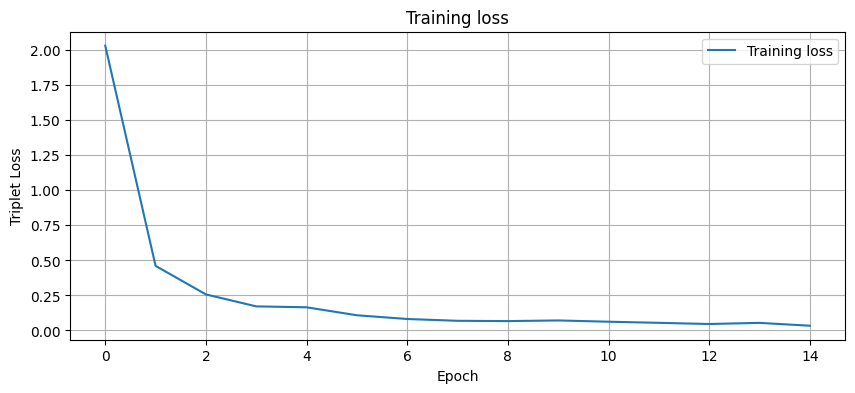

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.8430


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4259


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2568


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1551


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.0996


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0983


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0980


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0764


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0868


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0769


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0585


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0692


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0471


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0375


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0451


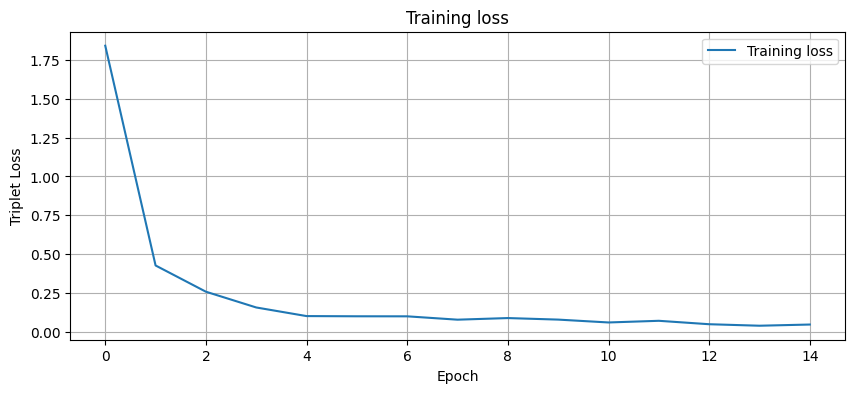

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9790


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4753


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2578


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1745


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1276


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1167


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0834


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0771


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0572


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0441


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0698


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0647


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0567


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0593


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0417


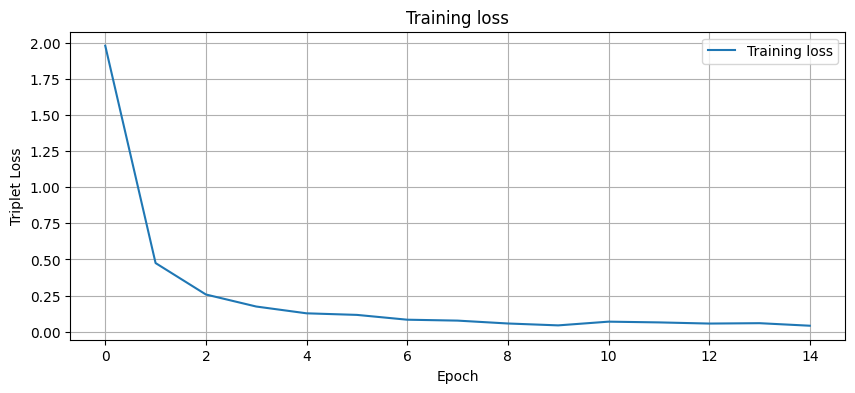

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9110


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4957


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2504


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1596


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1296


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0949


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0866


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0745


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0569


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0751


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0728


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0589


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0658


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0582


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0419


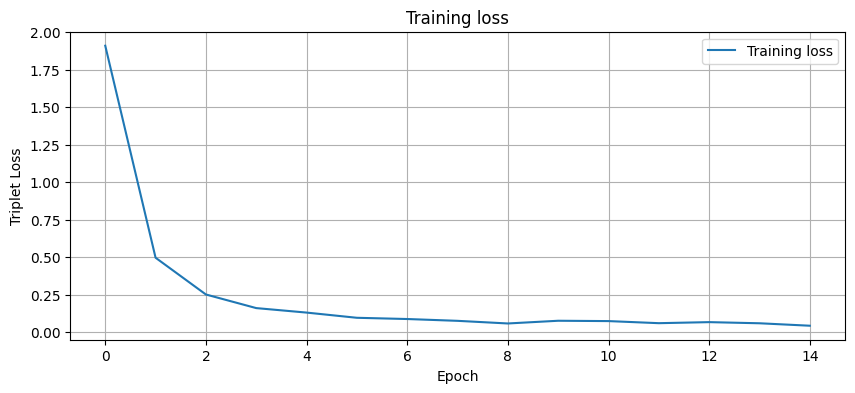

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9818


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4579


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2367


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1588


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1207


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1003


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0913


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0921


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0701


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0574


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0645


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0669


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0555


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0705


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0587


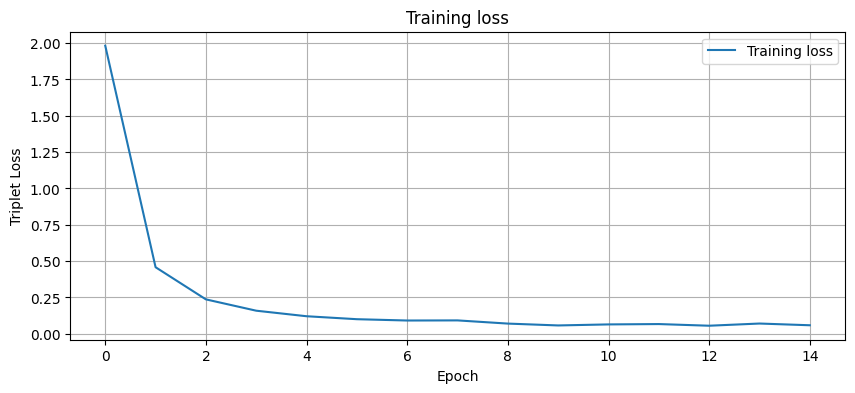

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9480


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4705


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2471


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1756


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1438


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1196


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1076


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.1130


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0637


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0512


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0454


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0495


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0638


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0611


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0483


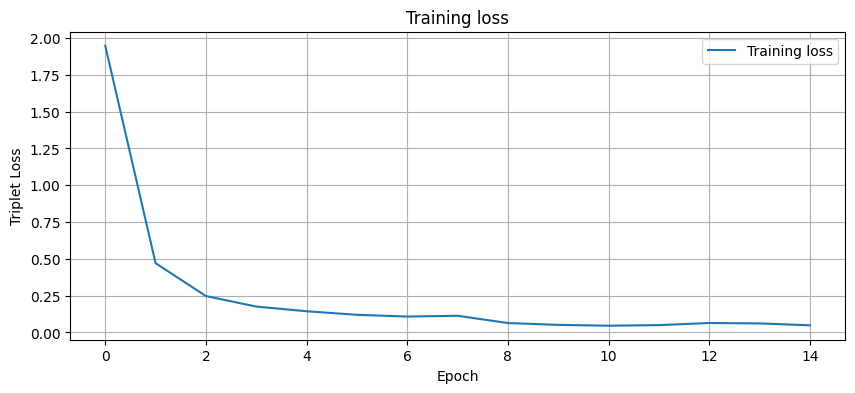

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9713


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4396


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2702


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.2096


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1615


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1069


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0922


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0873


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0872


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0668


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0554


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0588


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0493


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0444


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0562


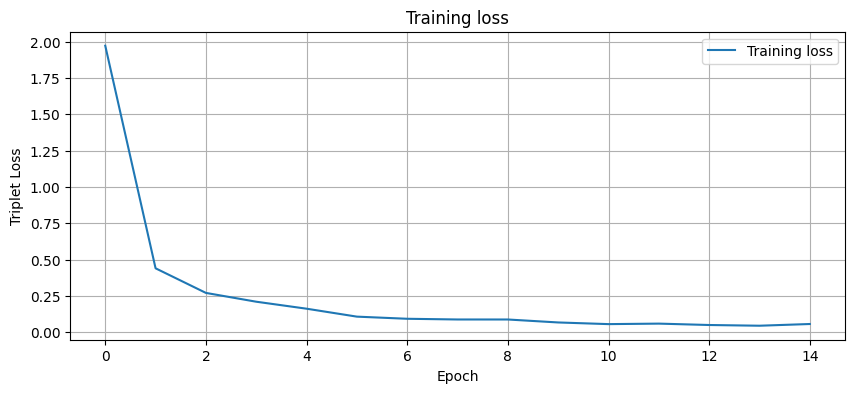

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9752


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4490


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2726


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1713


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1037


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1103


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0986


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0822


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0747


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0633


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0624


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0594


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0662


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0627


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0468


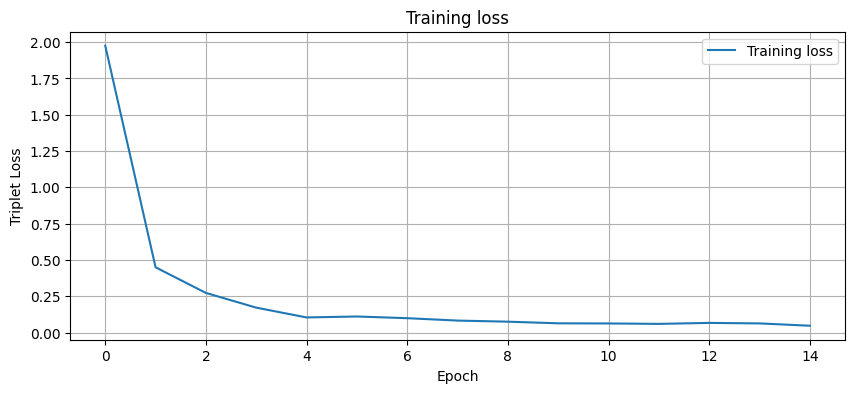

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.8933


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4117


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2681


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1657


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1449


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1156


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0654


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0642


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0751


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0738


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0733


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0559


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0494


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0523


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0483


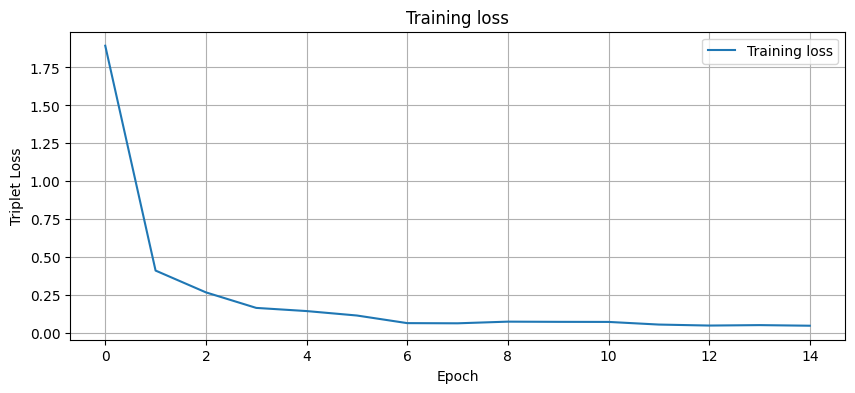

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0468


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.5295


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2577


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1465


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1329


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1141


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0973


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0865


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0533


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0597


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0621


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0398


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0565


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0579


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0426


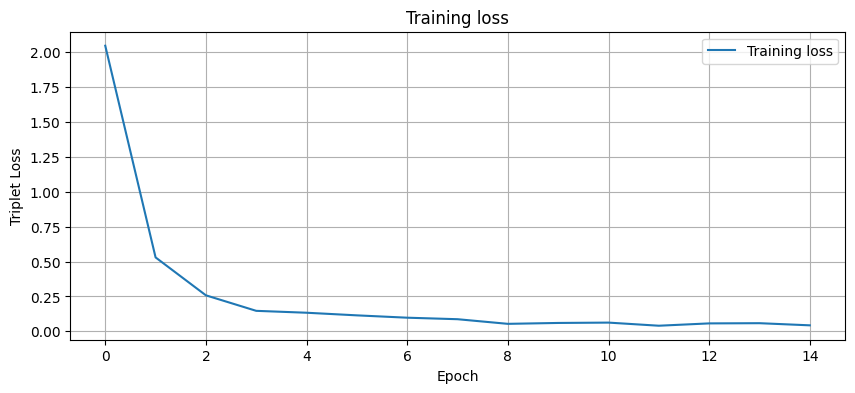

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0182


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4174


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2344


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1642


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1456


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0988


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0965


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.1070


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0700


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0654


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0553


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0570


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0506


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0404


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0402


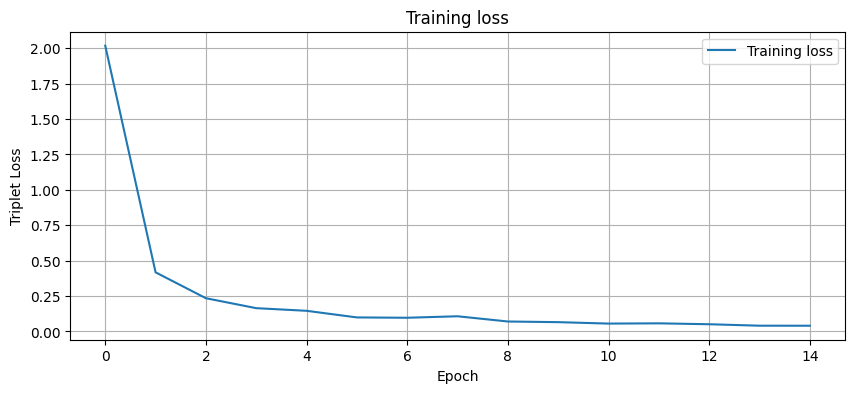

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9958


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4334


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2429


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1784


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1195


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1000


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1016


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0563


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0635


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0751


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0723


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0531


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0595


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0480


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0599


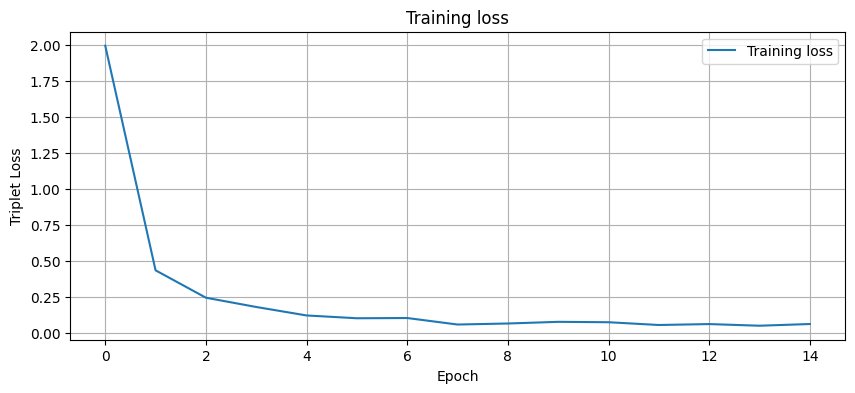

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9792


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4175


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2234


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.2123


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1437


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1101


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0973


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.1080


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0632


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0512


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0766


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0483


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0414


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0346


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0409


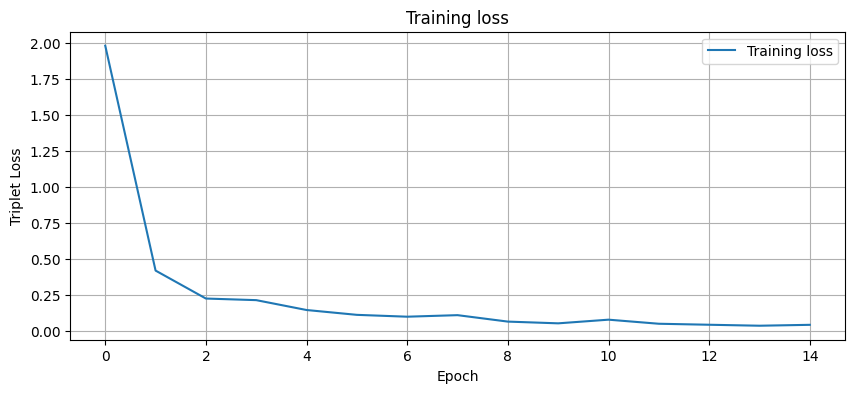

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.8434


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4768


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2309


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1745


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1506


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1002


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1058


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0816


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0746


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0559


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0555


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0575


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0489


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0437


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0621


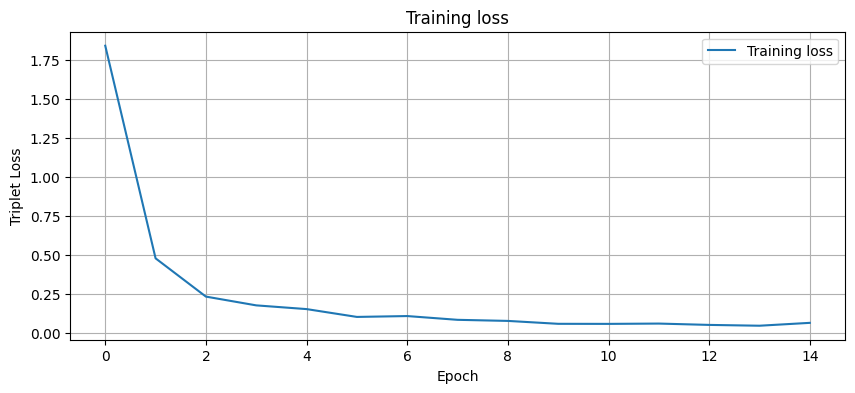

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.8030


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4462


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2053


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1987


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1323


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1469


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1047


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0734


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0819


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0644


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0556


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0461


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0478


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0399


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0497


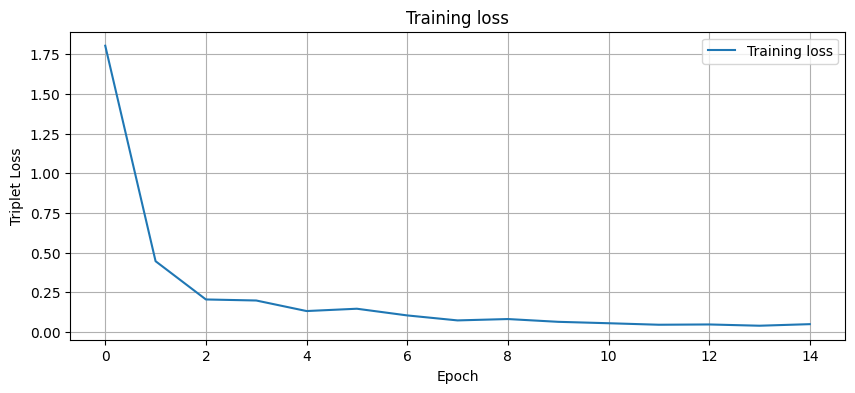

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9078


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4156


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2485


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1639


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1608


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1056


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1018


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0791


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0636


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0711


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0555


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0513


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0583


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0525


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0609


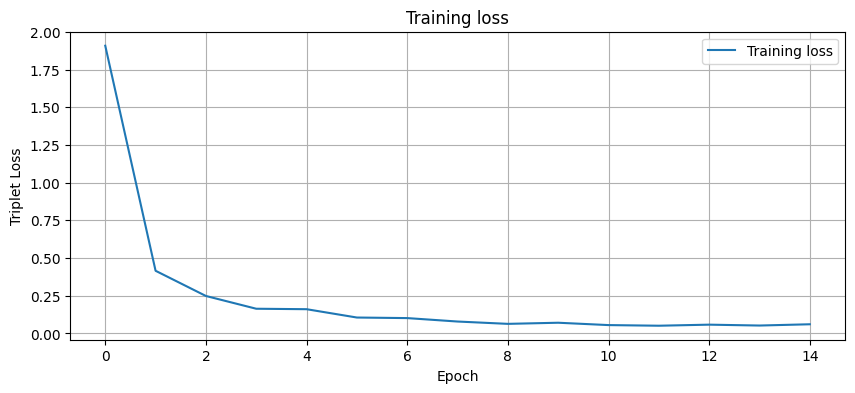

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0837


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.5045


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2687


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1499


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1604


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1068


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1142


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0881


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0924


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0778


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0512


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0665


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0478


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0487


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0389


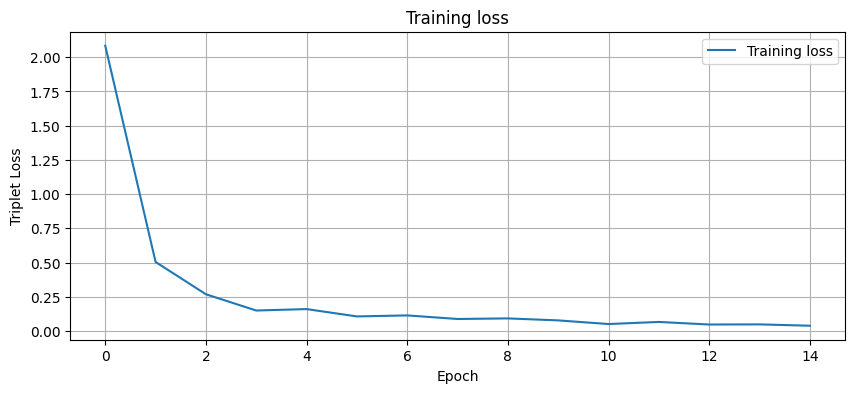

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9750


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4212


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2635


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1627


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1448


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1362


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0776


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0605


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0665


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0658


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0652


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0543


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0540


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0382


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0474


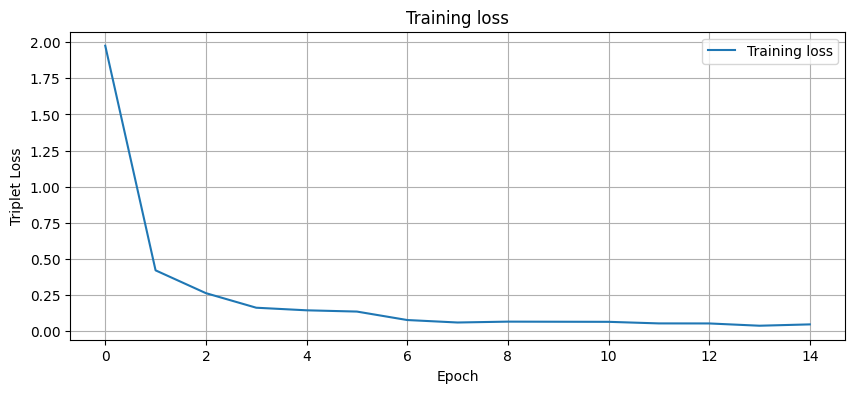

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0507


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4165


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2847


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1817


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1380


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1294


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0970


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0853


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0684


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0581


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0667


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0418


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0793


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0488


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0697


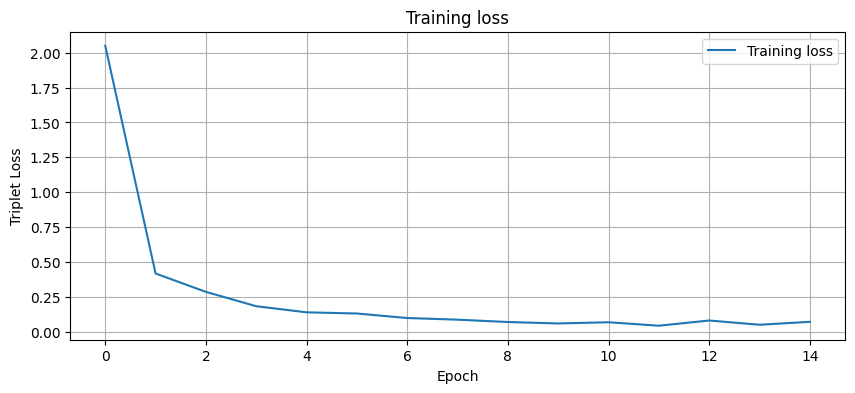

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0786


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4293


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2658


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1566


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1232


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0840


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1175


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0629


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0682


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0637


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0579


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0475


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0514


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0646


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0315


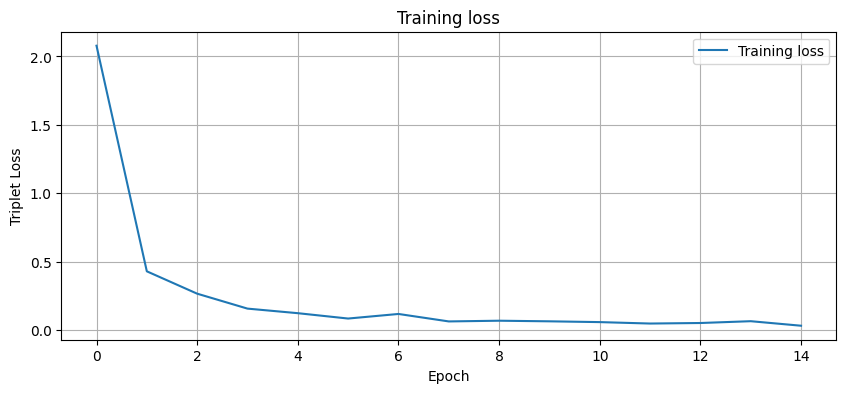

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0087


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4550


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2327


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1515


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1594


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1148


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0866


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.1106


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0617


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0622


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0554


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0604


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0582


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0599


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0468


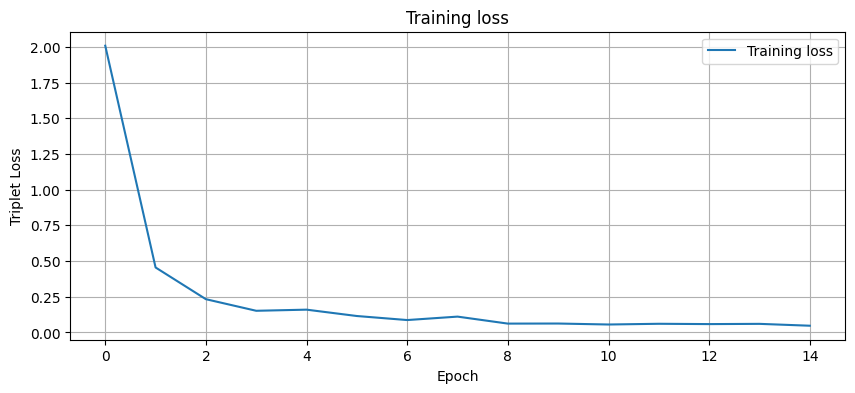

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9370


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4068


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2945


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1573


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1269


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1216


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1061


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0871


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0514


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0676


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0510


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0502


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0690


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0309


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0422


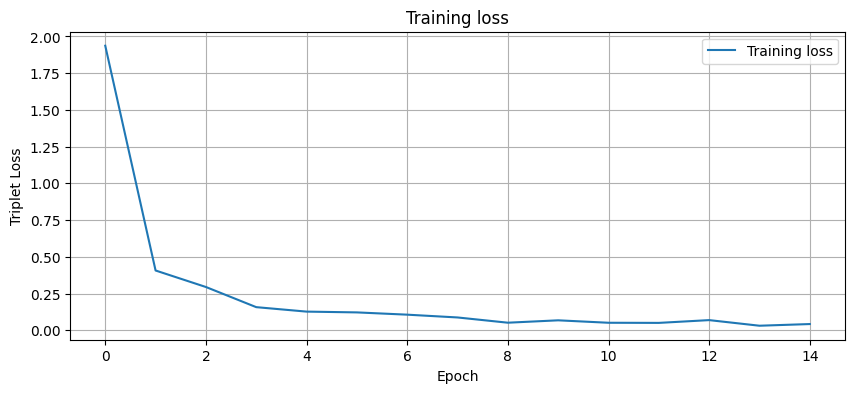

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0251


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4606


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2623


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1854


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1388


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0993


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0737


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0961


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0767


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0605


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0459


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0646


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0529


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0647


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0475


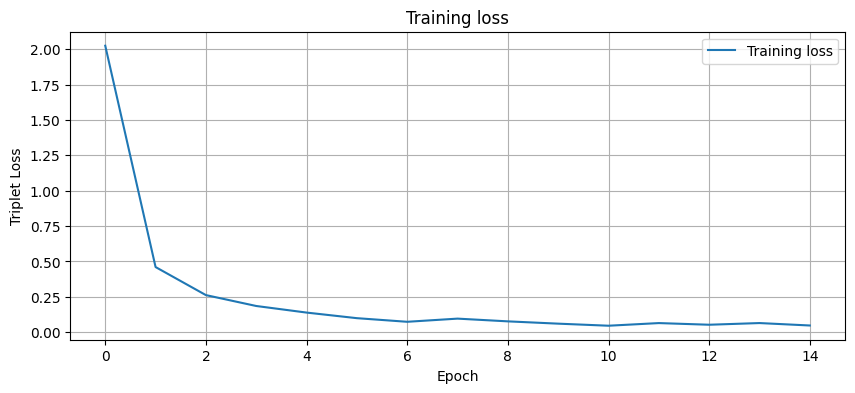

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9579


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4444


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2818


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1834


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1309


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0995


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0972


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.1006


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0695


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0565


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0658


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0544


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0674


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0424


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0284


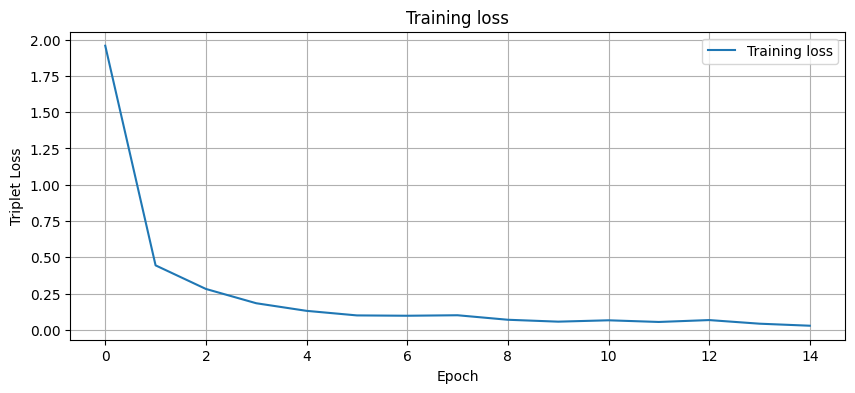

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.1394


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4766


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2420


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1739


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1231


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1129


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0885


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0850


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0707


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0690


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0734


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0452


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0432


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0429


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0432


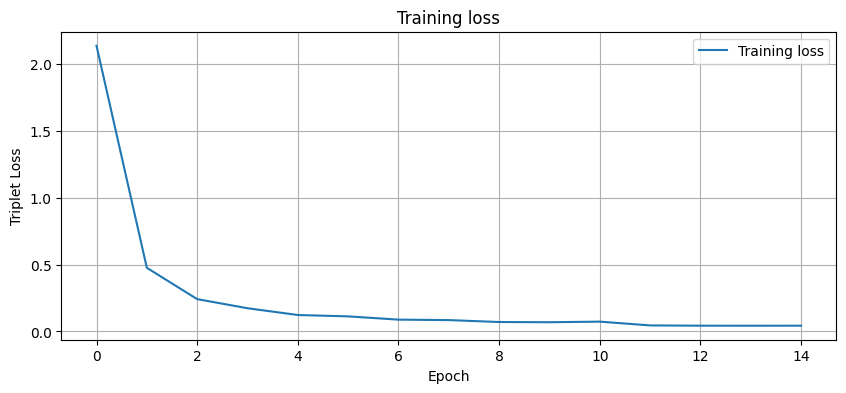

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9506


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4569


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2663


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1981


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1198


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1184


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0807


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0698


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0793


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0705


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0749


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0596


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0495


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0483


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0460


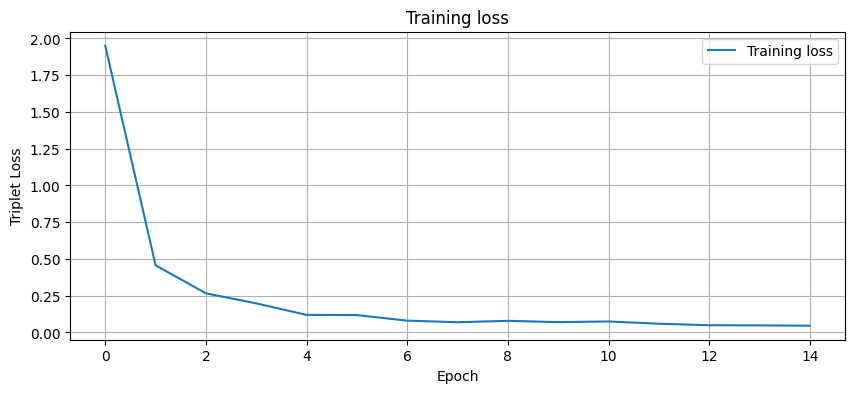

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.8672


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4154


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2422


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1790


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1304


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1031


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1030


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.1074


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0747


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0587


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0512


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0443


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0500


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0540


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0407


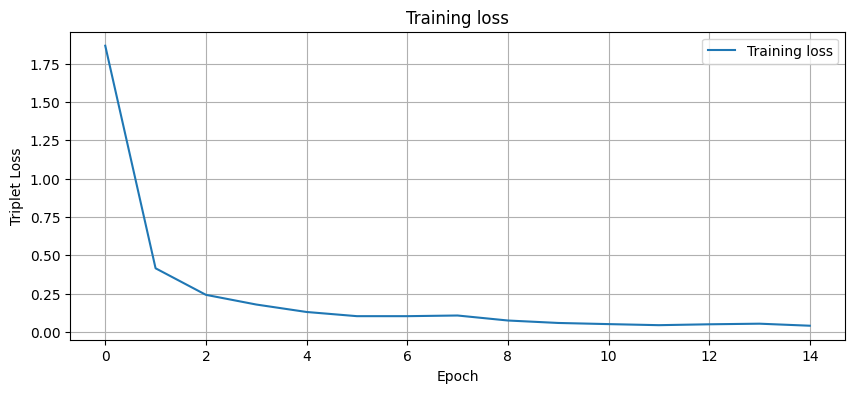

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9540


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4537


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2595


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.2039


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1354


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0813


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1108


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0866


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0703


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0625


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0760


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0524


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0374


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0489


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0554


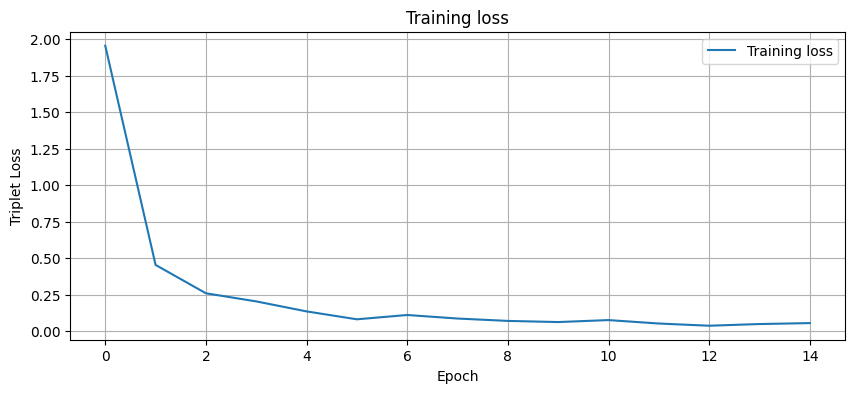

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0878


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4883


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2363


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1692


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1231


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1182


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1009


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0989


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0864


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0782


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0732


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0598


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0553


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0508


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0475


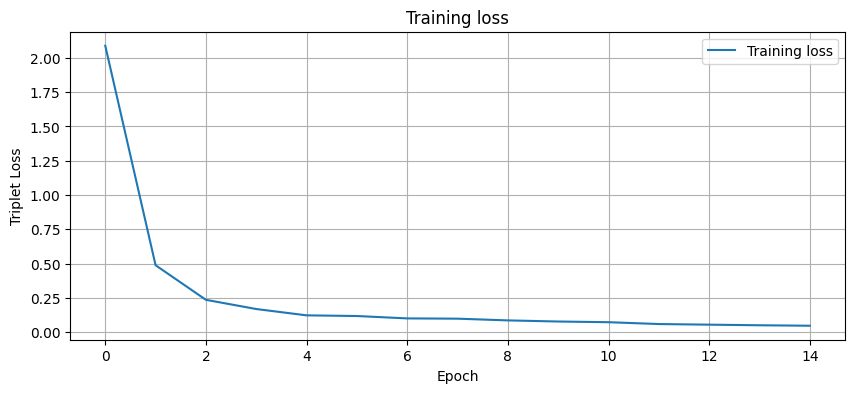

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9703


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4506


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2509


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1816


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1392


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0970


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0964


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0748


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0725


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0799


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0533


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0411


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0474


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0551


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0347


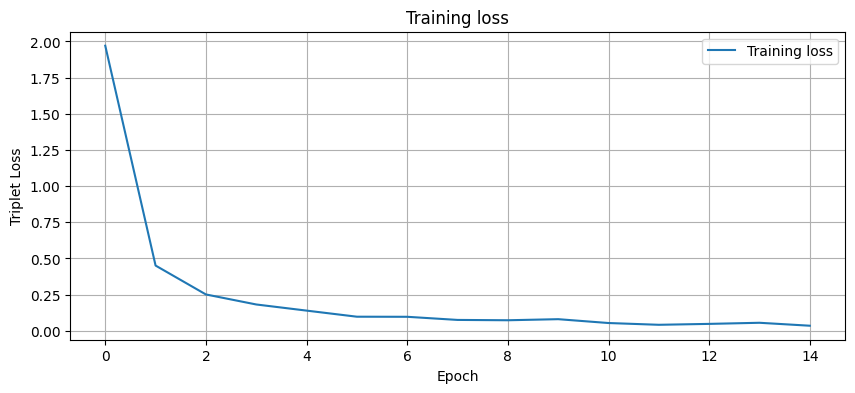

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9259


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4731


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2588


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1696


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1352


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0982


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0888


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0686


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0739


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0779


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0671


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0601


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0462


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0549


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0458


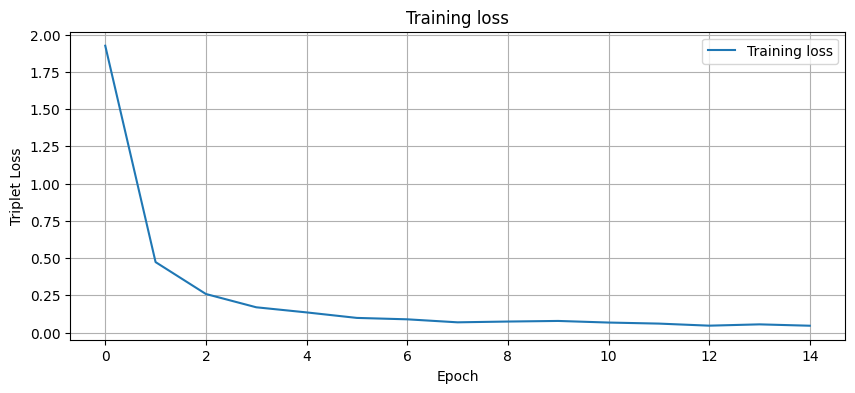

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0547


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4689


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2151


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1656


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1330


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1222


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0685


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0737


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0689


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0581


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0560


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0528


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0597


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0450


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0588


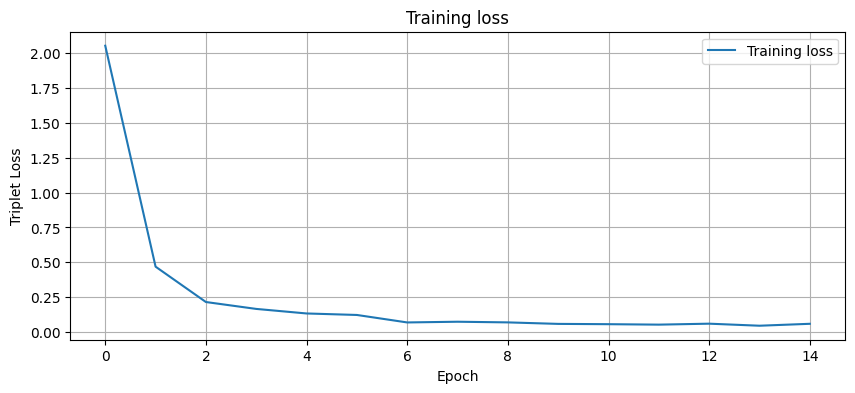

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.8954


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4912


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2248


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1483


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1460


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1119


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1065


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0972


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0830


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0619


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0642


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0472


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0523


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0451


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0638


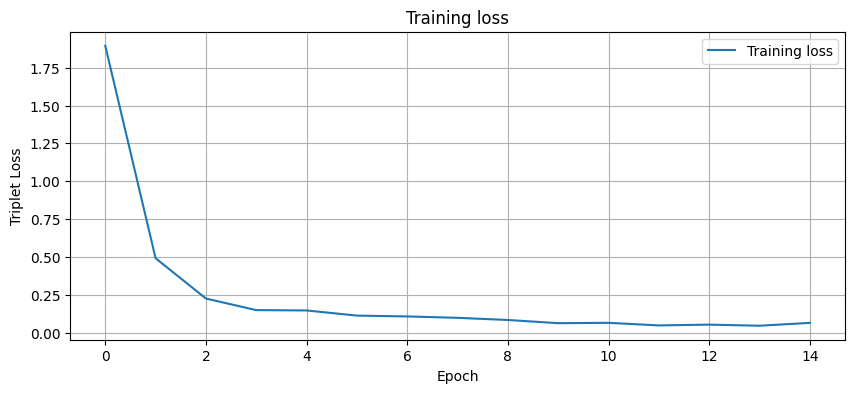

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9106


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4627


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2598


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1757


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1321


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1112


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0760


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0757


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0763


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0821


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0561


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0774


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0581


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0463


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0452


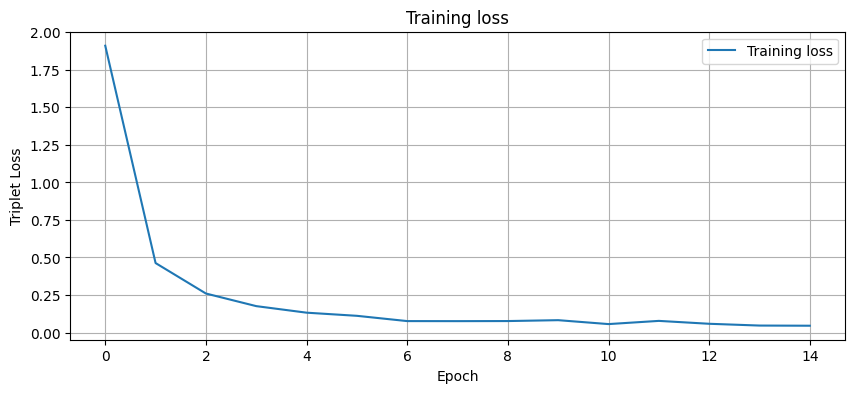

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0264


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4937


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2532


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.2030


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1238


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1333


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0732


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0783


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0714


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0765


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0683


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0594


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0512


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0558


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0480


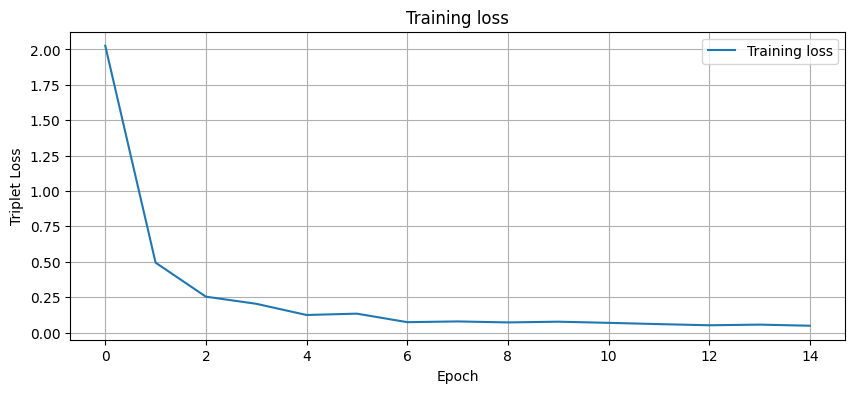

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.1340


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4867


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2346


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1961


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1391


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1304


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0857


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0788


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0650


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0714


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0307


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0467


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0690


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0581


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0435


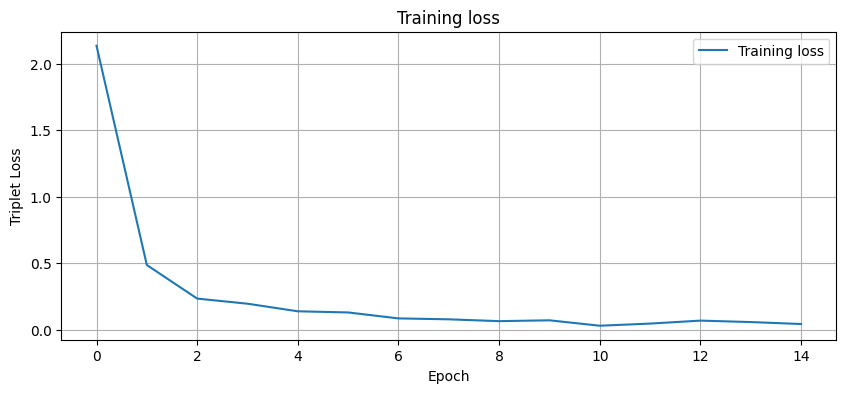

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0526


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4228


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2713


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.2002


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1540


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1032


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0882


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0925


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.1067


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0850


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0560


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0556


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0480


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0523


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0367


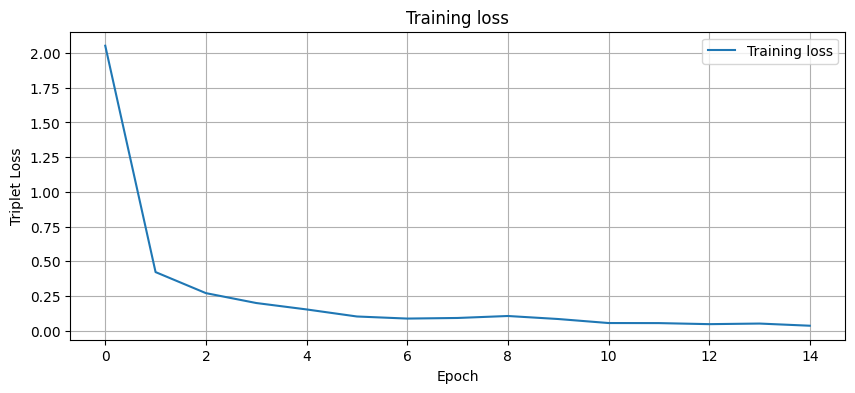

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0399


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4766


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2267


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.2073


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1569


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0941


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1098


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0601


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0783


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0593


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0517


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0496


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0568


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0393


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0376


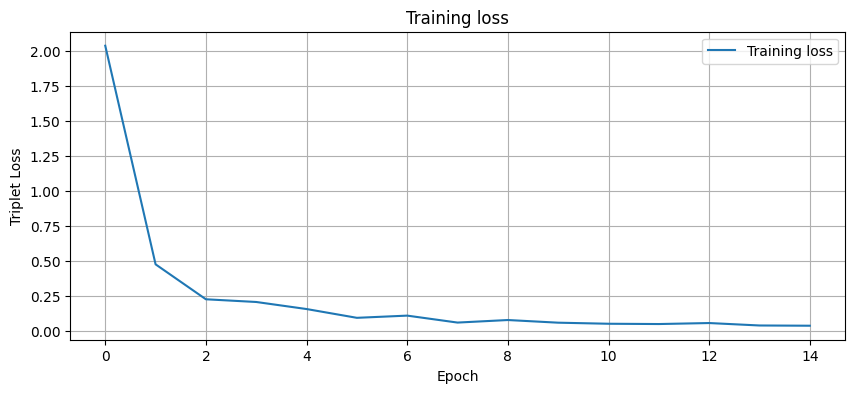

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.8360


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4575


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2334


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1383


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1646


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0842


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1155


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0814


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0781


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0551


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0607


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0685


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0461


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0512


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0501


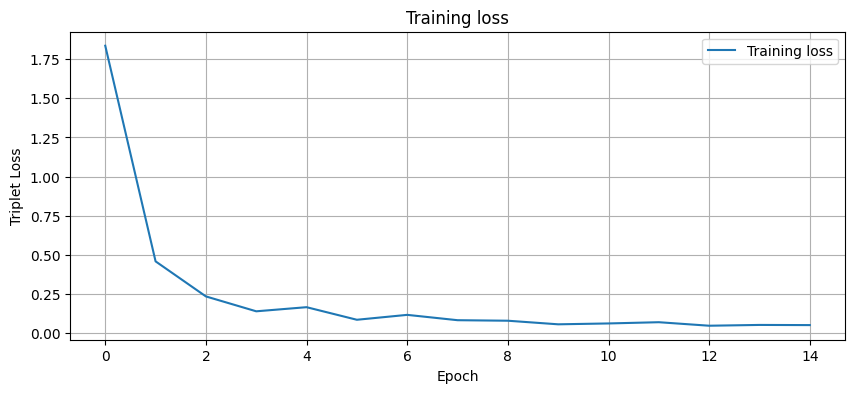

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9083


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4286


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2506


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1556


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1501


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1157


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1097


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0915


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0782


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0724


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0431


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0492


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0625


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0460


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0430


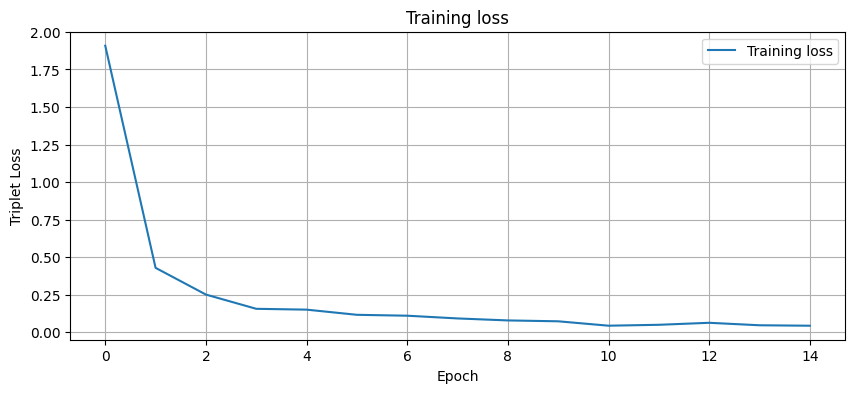

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9479


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4819


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2567


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1650


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1267


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1202


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0774


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0557


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0853


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0619


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0439


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0501


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0480


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0380


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0403


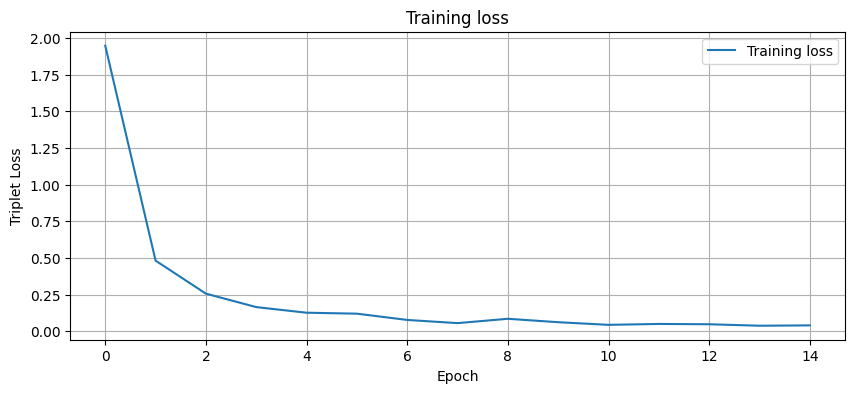

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0182


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4426


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2811


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1938


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1134


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1116


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0778


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0720


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0703


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0561


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0545


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0545


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0860


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0674


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0694


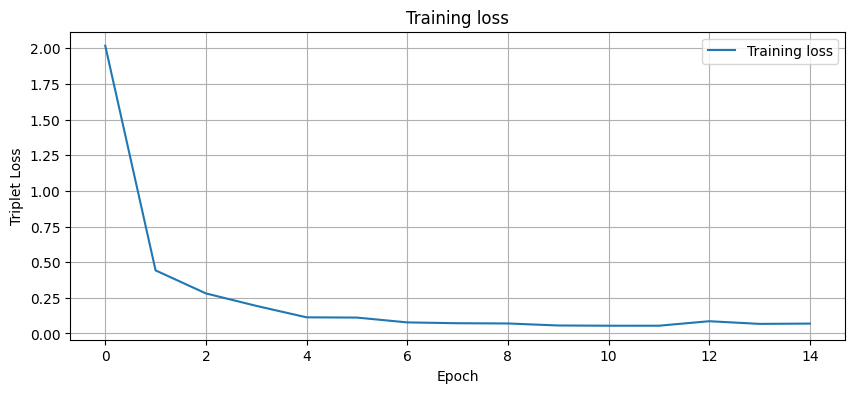

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0236


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4774


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2172


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1716


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1305


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1262


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1156


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0834


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0793


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0627


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0496


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0513


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0541


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0296


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0372


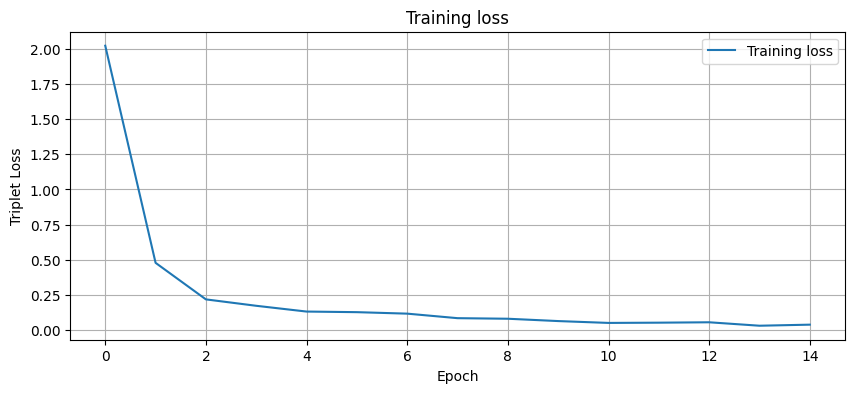

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0397


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4820


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2212


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1848


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1336


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0928


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1091


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0789


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0729


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0702


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0554


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0589


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0507


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0525


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0340


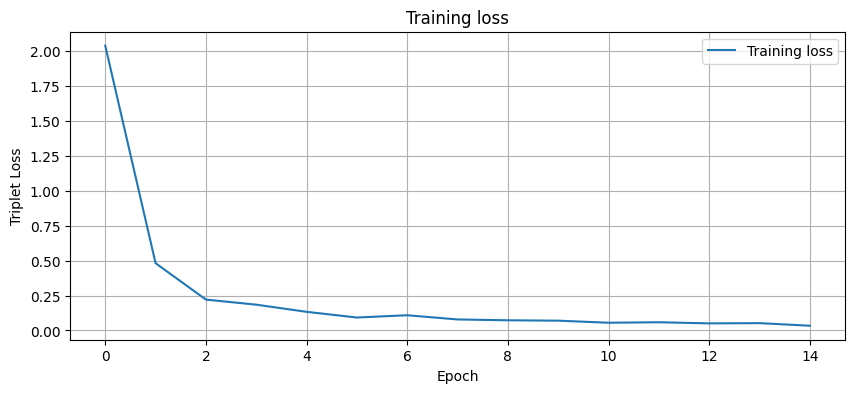

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9549


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4241


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2442


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1739


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1353


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1330


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0898


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0796


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0920


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0676


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0580


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0558


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0449


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0430


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0425


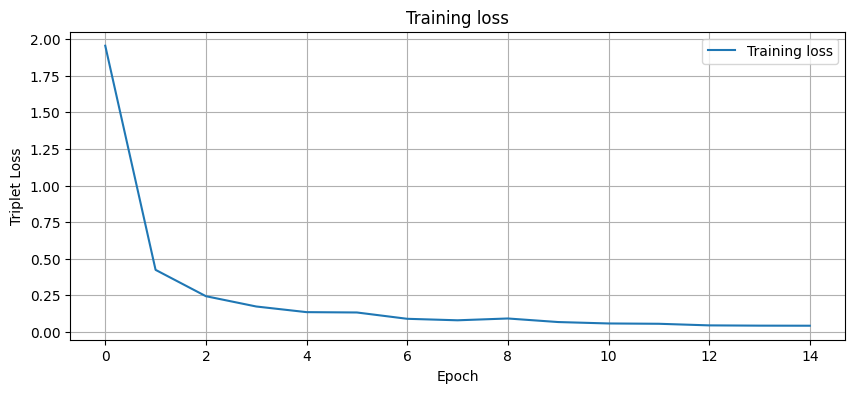

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9158


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4551


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2541


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1558


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.0996


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0893


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0861


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0856


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0630


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0839


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0521


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0430


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0299


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0462


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0416


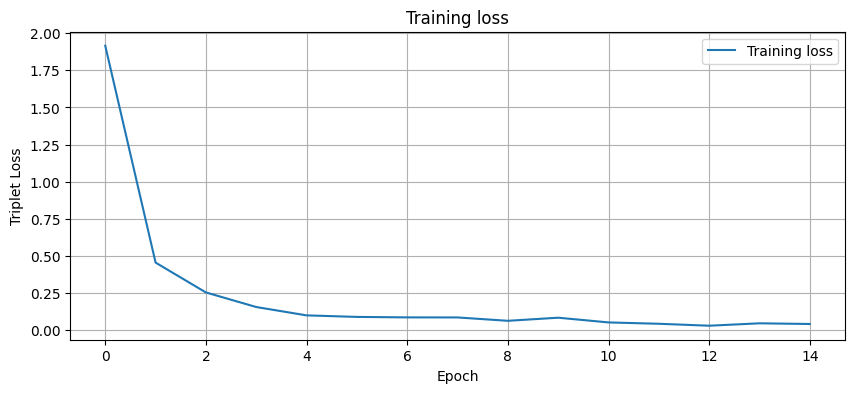

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9614


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4320


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2452


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1764


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1421


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0951


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0901


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0938


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0812


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0527


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0661


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0655


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0463


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0442


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0572


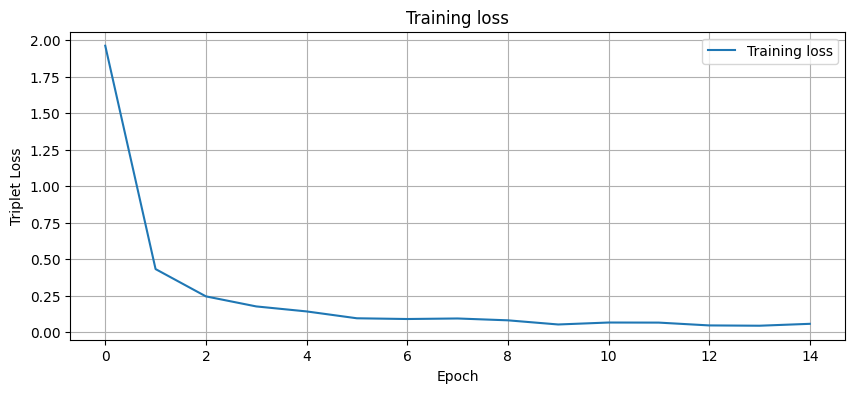

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0125


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4536


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2504


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1972


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1328


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0840


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0752


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0708


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0676


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0755


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0690


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0490


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0497


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0361


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0411


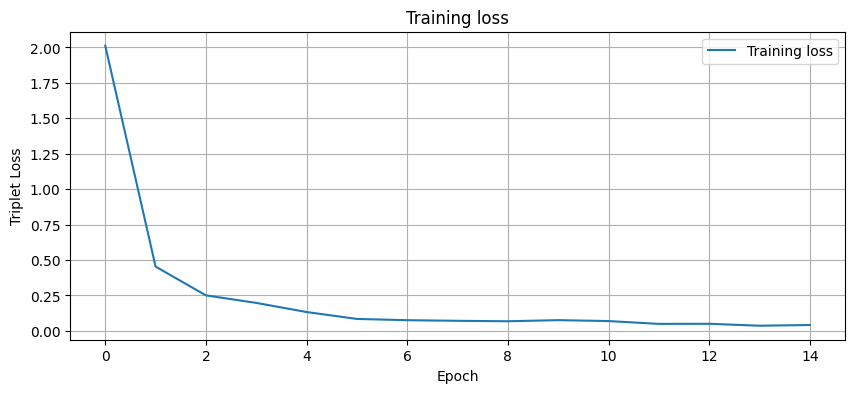

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0805


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4875


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2459


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1812


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1248


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0996


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0799


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0847


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0741


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0714


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0652


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0487


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0316


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0570


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0592


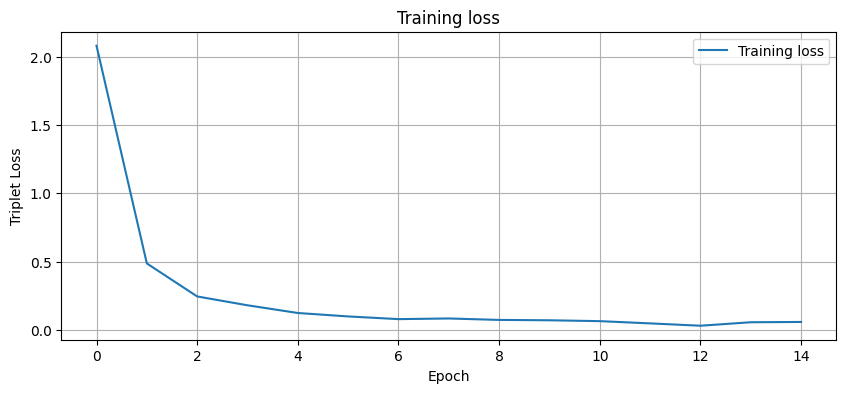

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9499


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.5156


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2592


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.2007


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1326


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1086


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0989


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0753


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0745


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0816


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0626


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0535


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0364


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0421


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0452


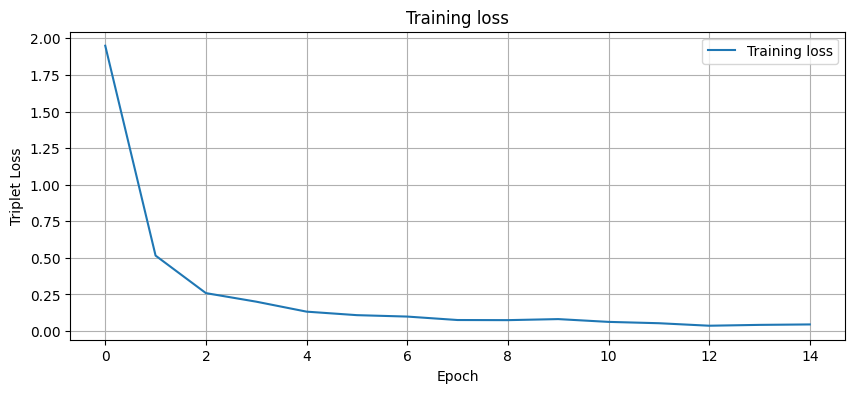

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0251


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4332


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2330


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1748


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1326


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1161


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1057


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0979


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0758


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0502


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0650


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0440


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0299


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0484


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0488


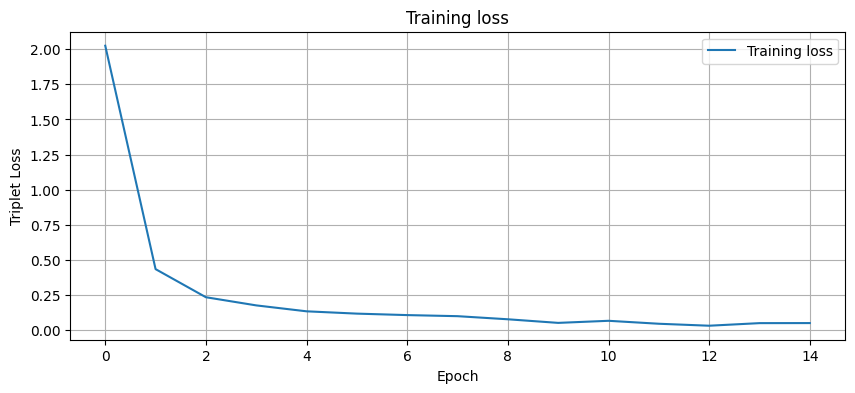

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0328


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4195


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2826


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1644


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1537


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1454


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0986


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0828


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0635


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0544


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0755


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0495


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0599


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0409


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0569


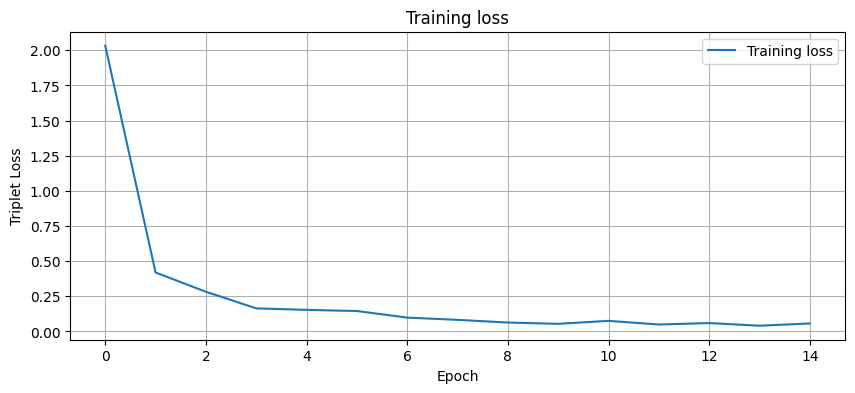

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0432


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4625


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2627


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1747


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1193


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1241


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0940


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0750


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0631


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0557


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0557


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0440


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0581


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0588


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0451


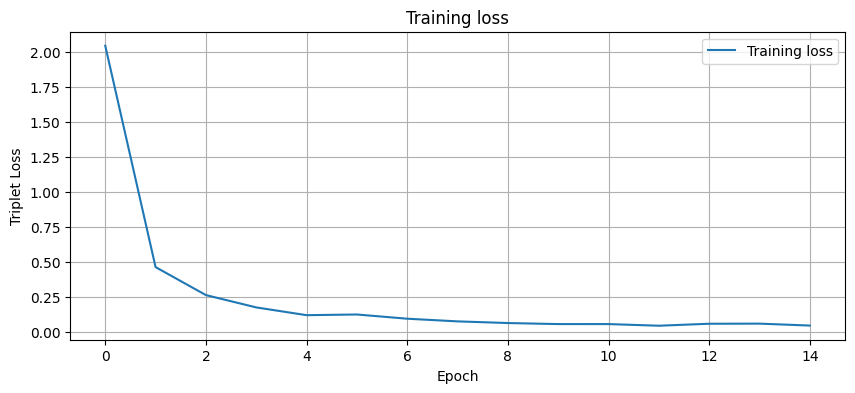

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9721


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4398


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2316


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1667


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1517


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1060


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0817


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0742


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0696


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0704


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0777


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0511


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0562


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0386


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0485


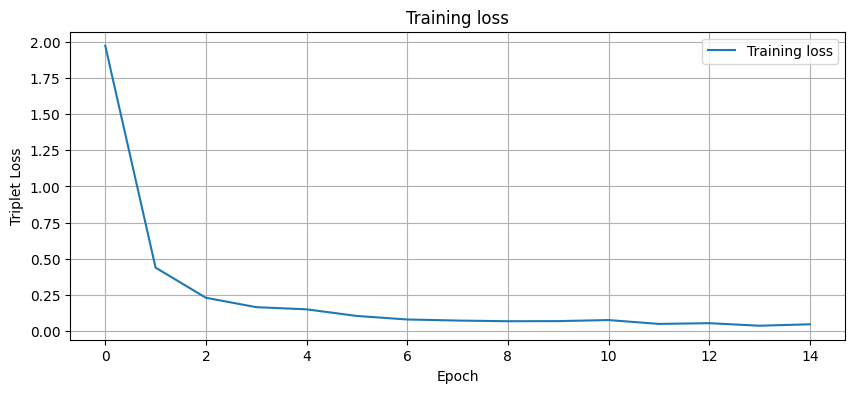

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.8397


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4453


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2592


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1901


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1327


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1178


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1030


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0766


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0761


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0670


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0751


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0770


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0550


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0430


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0420


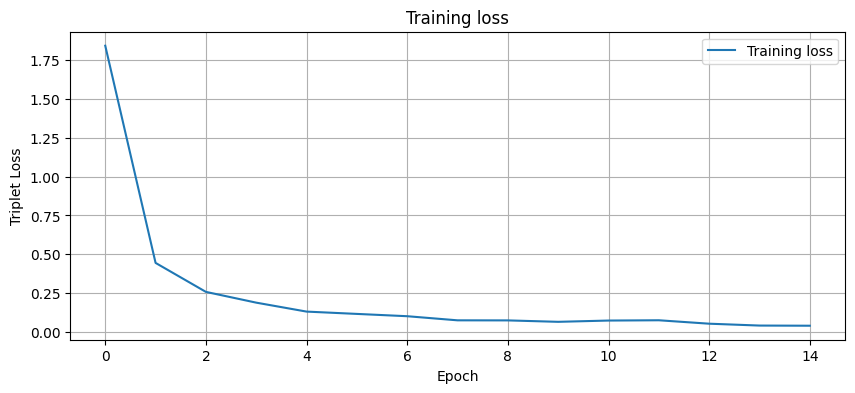

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9149


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4300


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2292


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1880


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1637


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0846


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0935


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0664


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0706


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0670


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0570


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0465


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0463


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0490


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0470


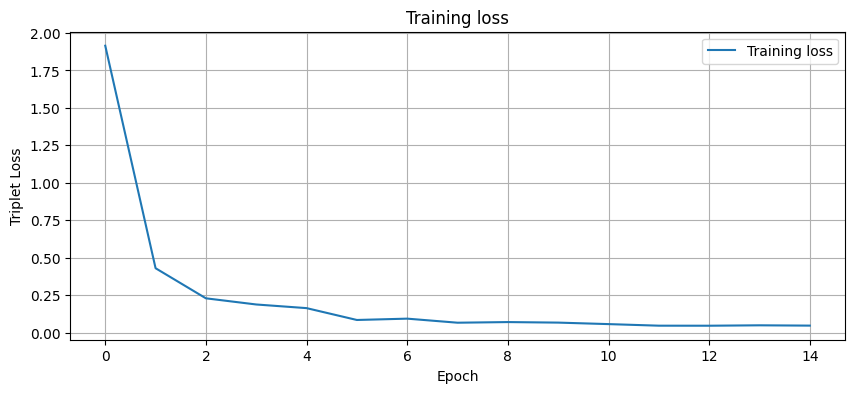

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0180


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4809


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2249


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1739


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1595


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1041


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0748


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0744


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0961


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0658


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0550


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0628


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0491


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0561


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0363


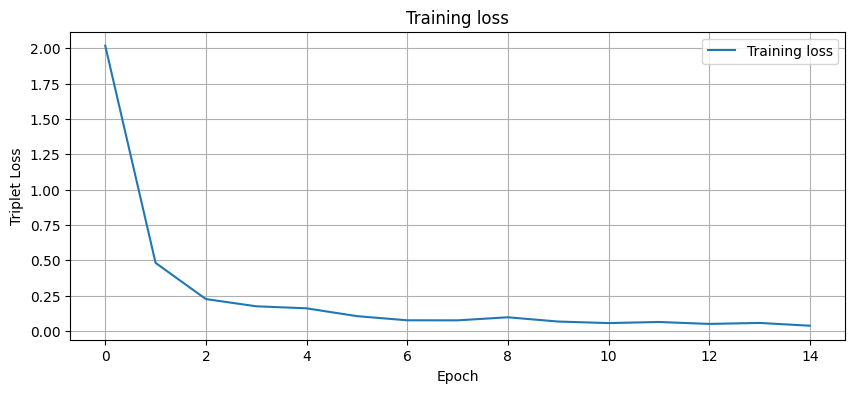

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9067


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4991


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2229


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1686


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1311


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1187


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0851


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0727


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0844


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0756


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0774


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0467


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0449


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0472


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0406


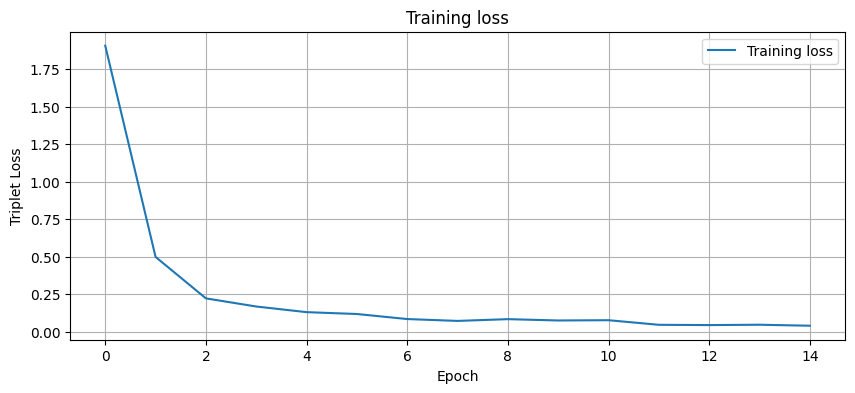

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9229


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4843


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2668


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1784


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1354


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0871


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0967


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0694


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0604


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0579


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0601


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0828


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0518


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0486


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0483


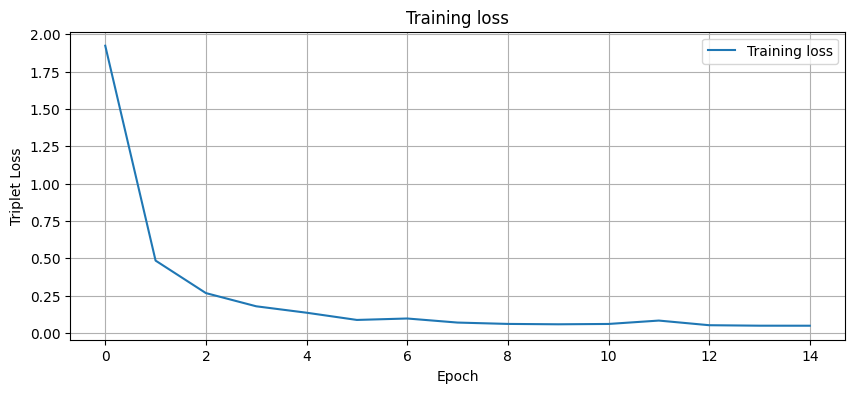

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9727


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4352


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2435


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1698


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1251


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1303


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0905


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0923


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0587


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0566


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0652


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0626


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0680


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0528


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0426


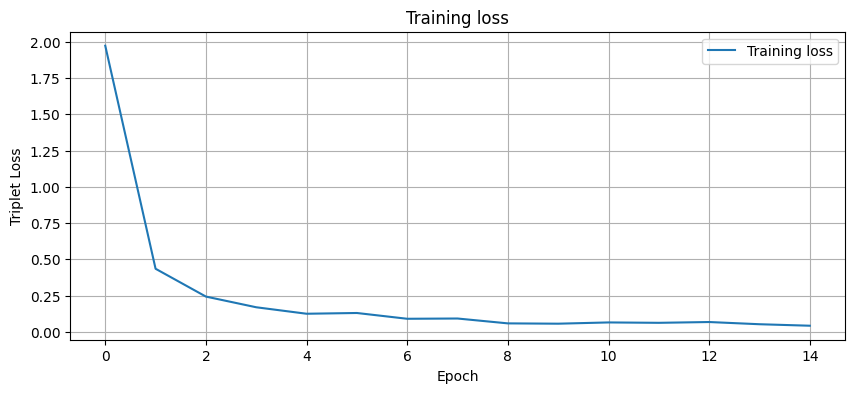

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9543


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4442


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2294


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1415


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1422


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0838


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0818


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0807


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0891


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0535


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0488


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0407


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0379


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0610


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0448


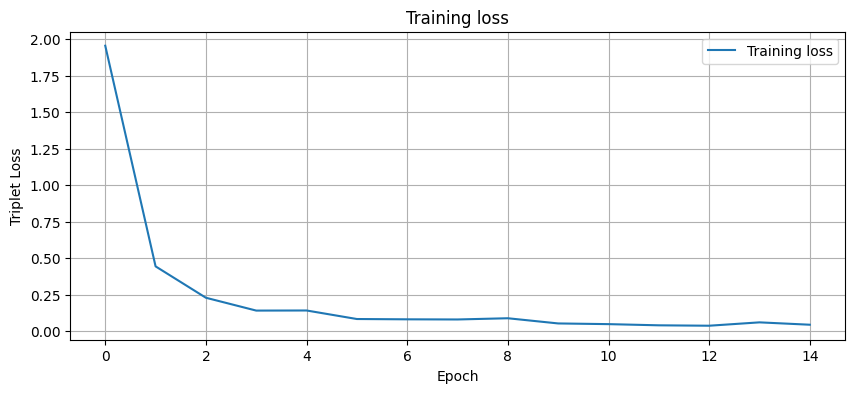

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0499


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4450


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2481


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.2043


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1189


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1007


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1093


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0824


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0904


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0740


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0540


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0625


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0582


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0733


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0429


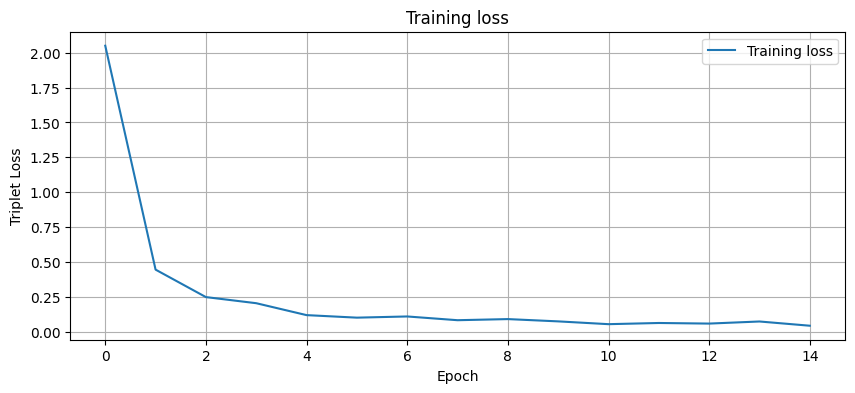

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9522


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.5183


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2687


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1612


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1207


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1370


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0884


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0808


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0597


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0686


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0836


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0756


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0524


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0379


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0553


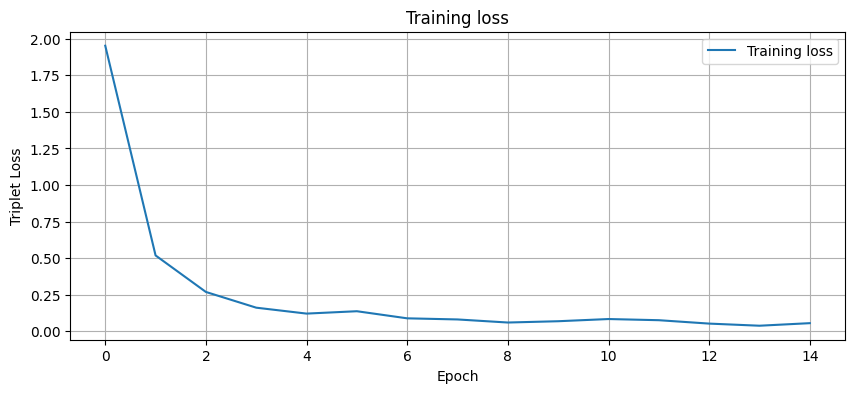

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.8325


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4065


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2565


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1892


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1186


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0963


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1032


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0943


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0655


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0701


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0642


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0565


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0646


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0538


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0367


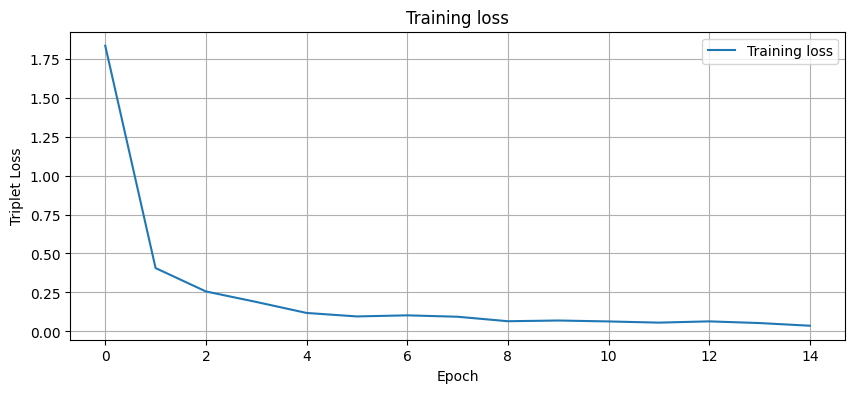

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0789


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4466


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2677


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1459


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1163


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1135


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1015


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0787


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0605


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0579


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0674


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0391


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0532


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0479


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0506


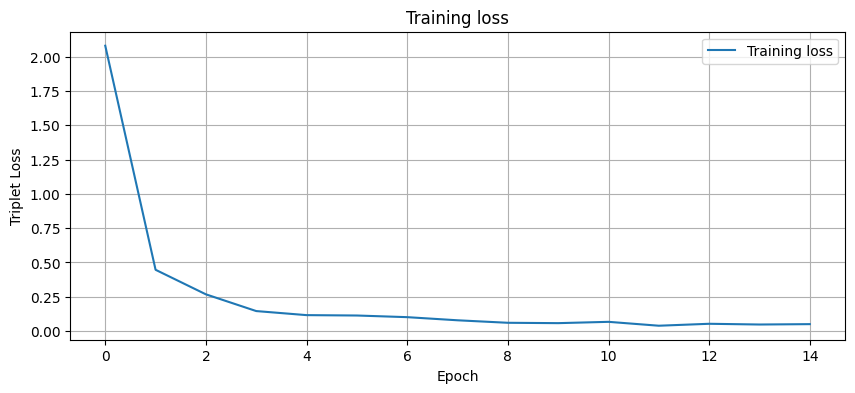

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9245


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4518


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2533


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1771


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1314


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1031


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0971


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0886


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0797


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0836


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0821


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0655


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0496


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0443


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0372


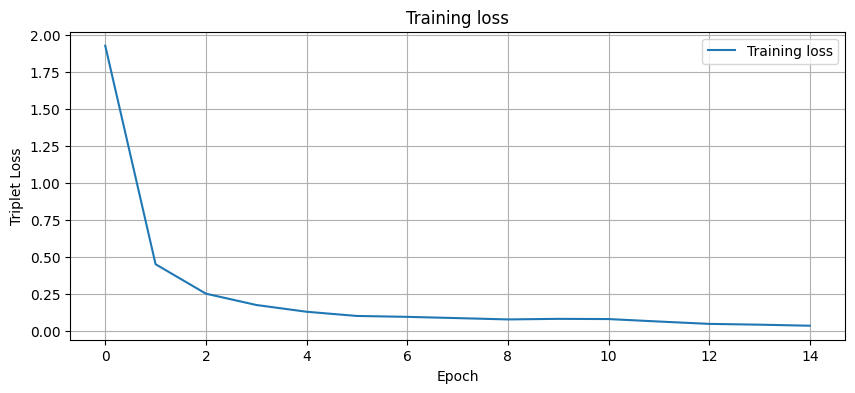

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0502


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4664


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2789


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1669


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1525


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1163


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0752


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0577


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0666


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0684


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0754


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0665


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0529


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0578


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0764


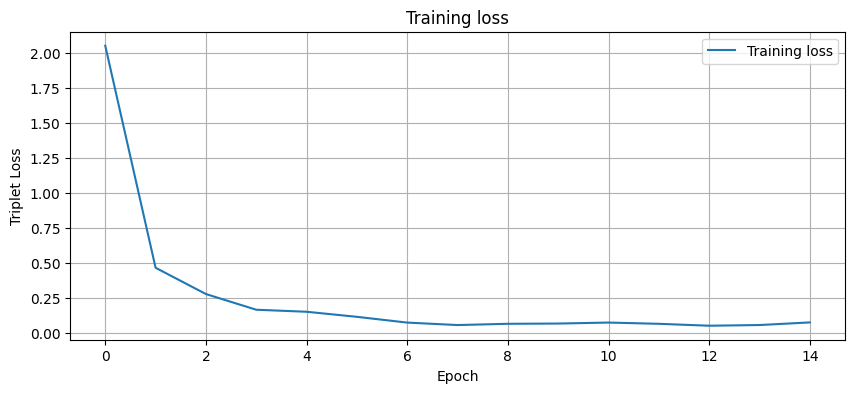

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0576


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4828


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2696


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1597


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1347


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1035


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1003


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0925


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0767


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0689


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0699


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0498


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0519


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0486


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0355


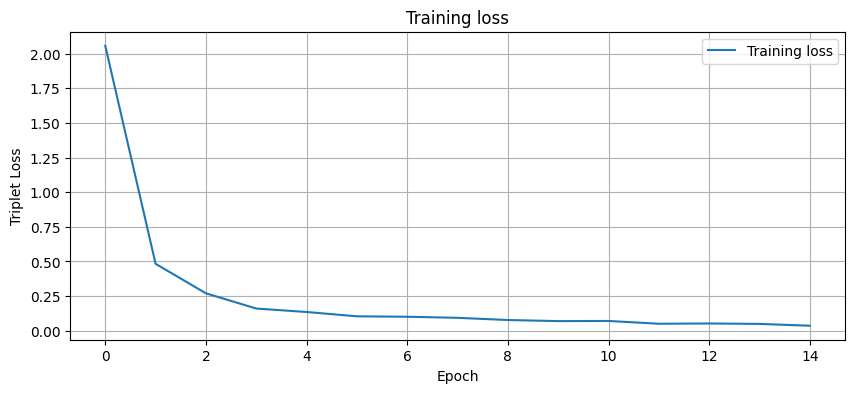

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0046


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4481


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2385


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1895


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1260


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1027


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1031


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0679


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0809


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0563


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0495


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0448


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0531


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0503


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0344


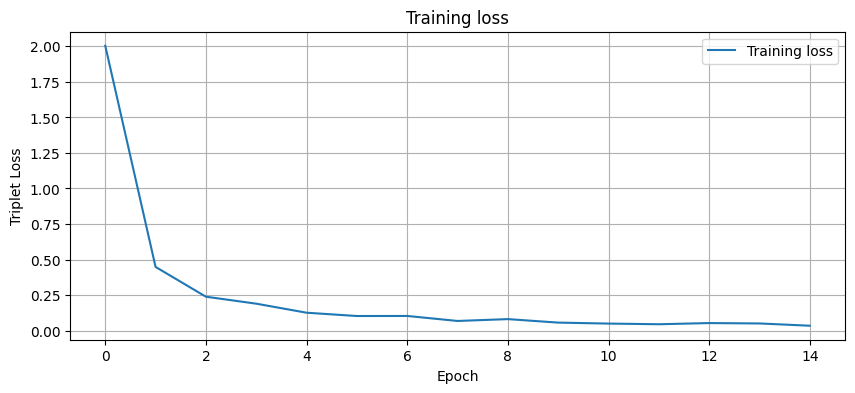

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.8994


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4197


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2414


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.2081


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1526


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0993


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0920


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0829


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0705


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0677


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0338


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0483


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0666


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0563


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0570


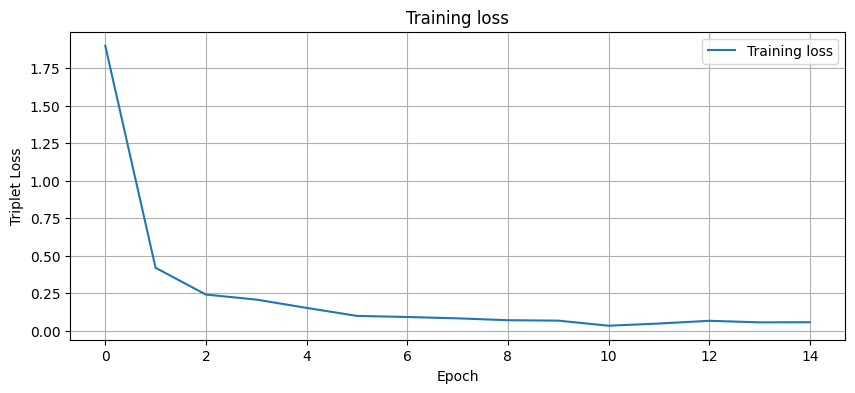

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9129


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4433


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2382


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1916


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1455


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0930


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0791


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0880


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0959


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0555


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0588


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0578


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0516


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0497


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0504


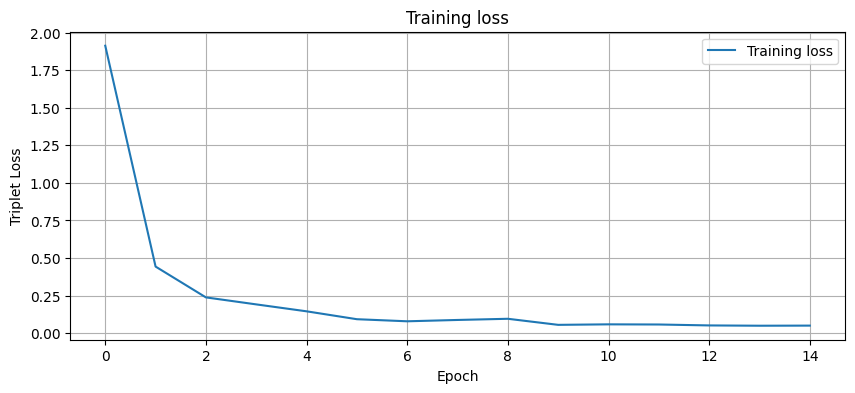

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0120


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4497


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2605


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1681


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1469


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1060


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1084


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0702


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0622


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0642


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0563


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0543


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0405


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0471


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0398


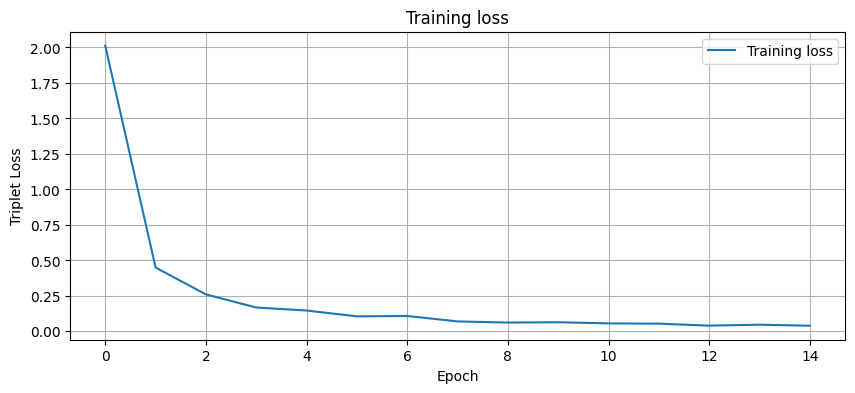

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9571


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4530


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2699


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1730


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1373


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1330


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0880


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0928


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0965


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0724


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0757


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0456


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0645


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0394


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0328


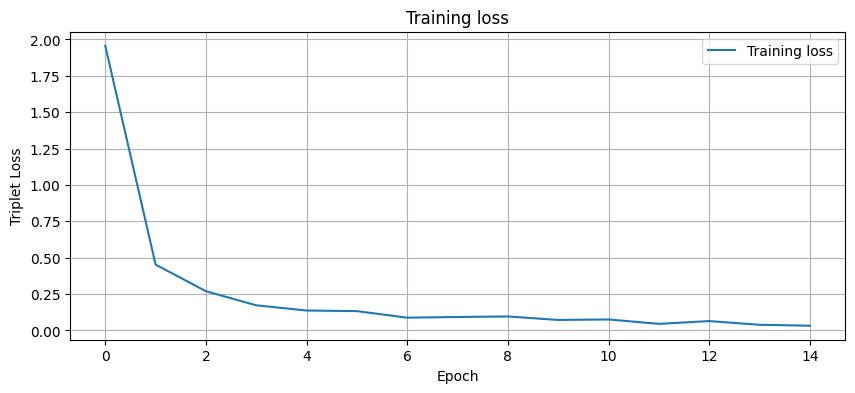

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0509


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4104


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2639


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1595


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1342


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1117


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0798


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0736


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0730


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0504


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0448


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0631


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0454


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0586


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0511


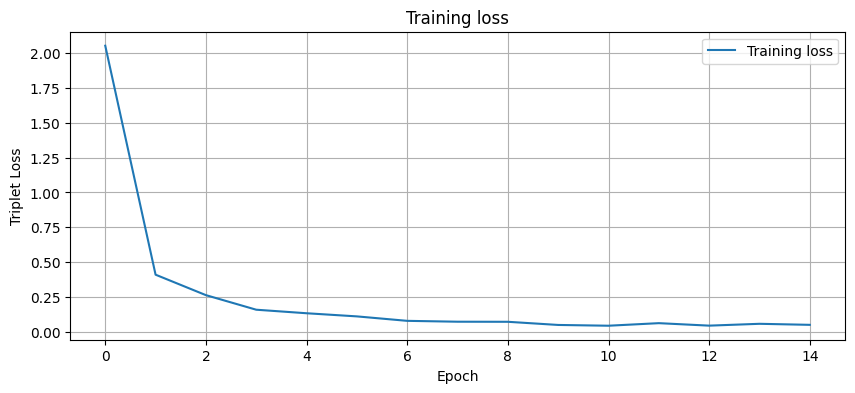

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9758


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4637


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2801


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1841


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1484


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1193


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1043


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0742


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0961


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0668


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0554


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0706


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0565


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0552


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0674


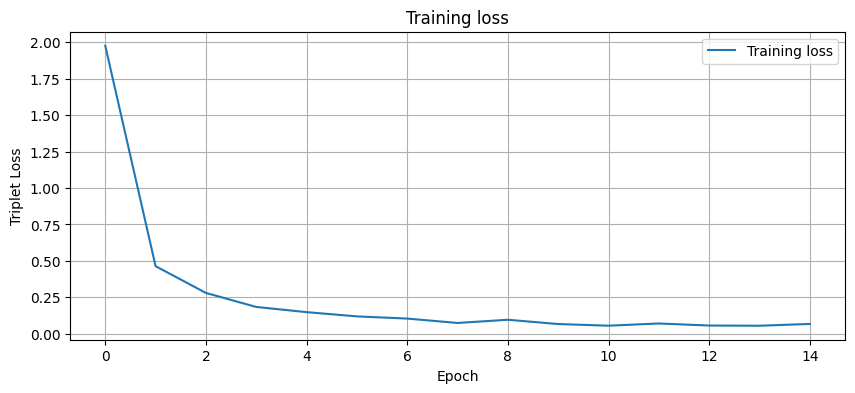

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9667


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4447


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2233


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1889


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1306


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0986


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0933


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0692


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0704


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0509


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0751


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0469


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0629


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0458


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0396


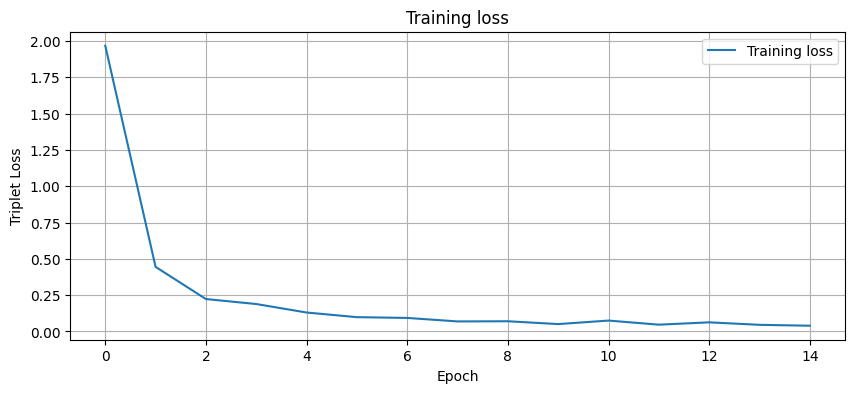

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0585


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.3996


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2525


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1584


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1333


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0945


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0751


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0872


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0732


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0482


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0510


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0571


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0480


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0501


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0486


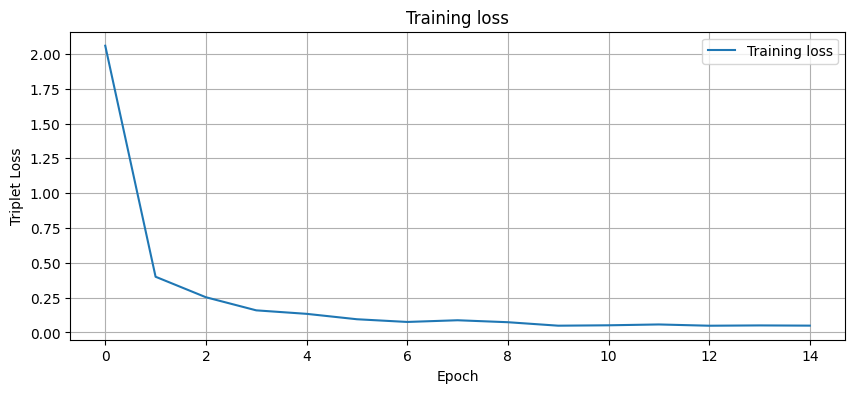

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.8470


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4577


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2665


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1676


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1136


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0940


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0877


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0806


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0620


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0604


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0557


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0576


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0531


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0388


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0498


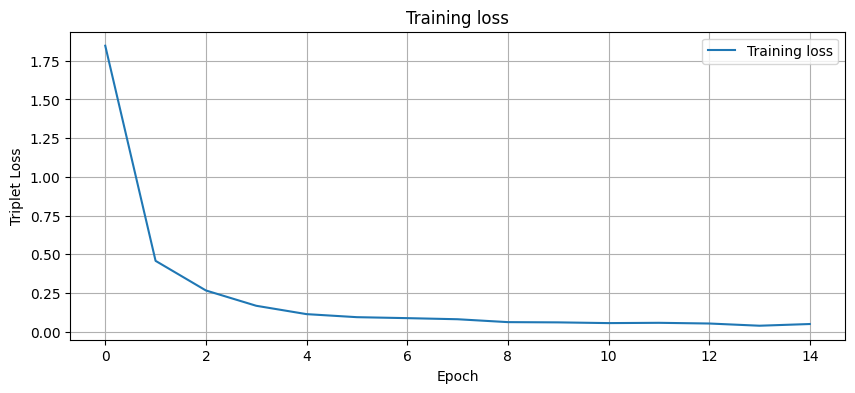

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9087


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4856


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2342


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1865


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1635


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0857


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0868


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0749


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0633


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0621


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0895


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0656


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0710


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0496


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0468


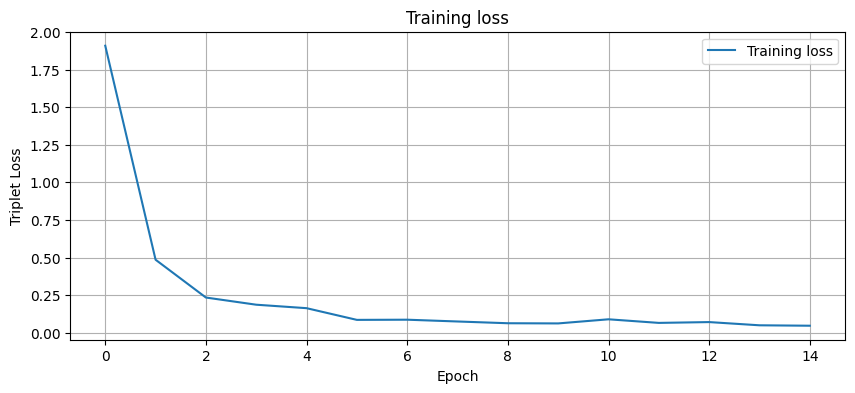

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0386


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4817


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2574


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1710


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1450


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1073


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0780


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0724


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0498


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0931


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0531


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0548


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0549


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0598


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0599


Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0207


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4160


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.1968


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1682


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.0994


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1421


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1060


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0916


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0707


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0541


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0556


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0634


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0584


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0605


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0385


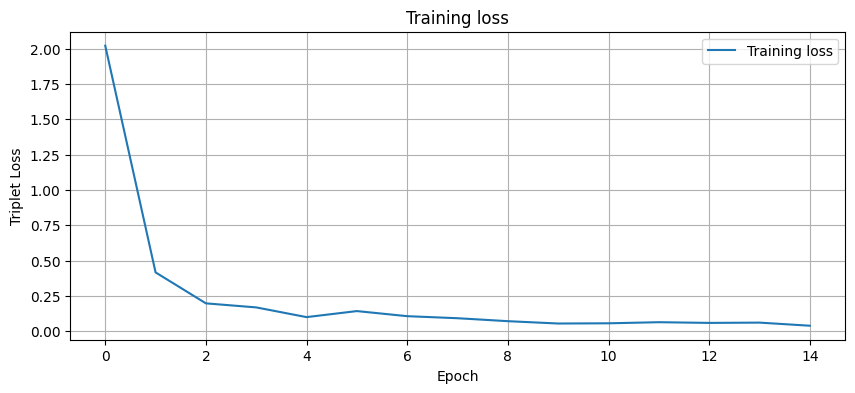

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9629


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.3998


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2837


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1819


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1479


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1055


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0917


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0670


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0732


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0715


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0452


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0549


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0598


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0529


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0439


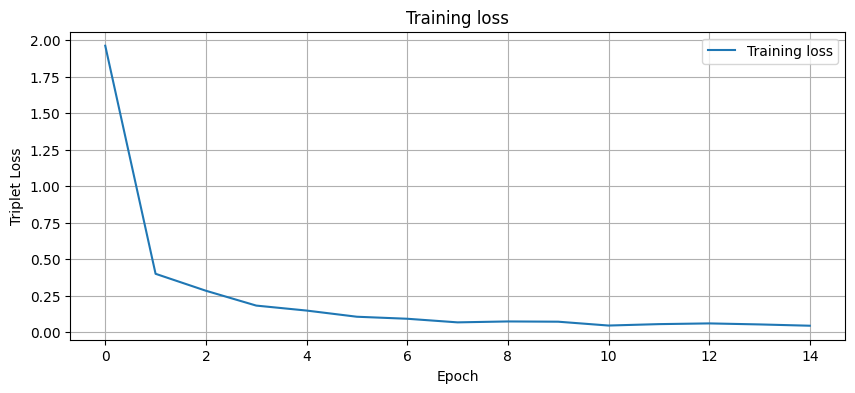

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9767


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4799


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2331


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1929


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1401


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1191


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0772


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0797


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0829


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0960


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0621


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0597


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0621


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0386


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0691


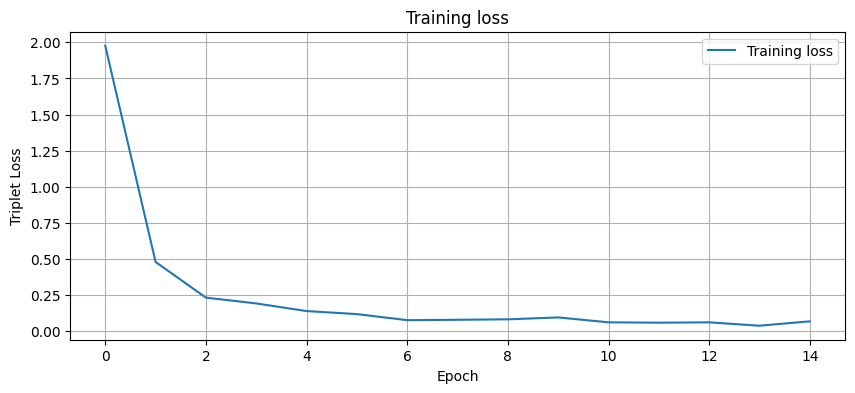

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9322


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4165


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2304


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.2010


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1270


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1380


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0807


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0633


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0694


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0781


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0587


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0356


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0408


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0454


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0333


Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0188


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4908


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2232


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1823


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1492


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1070


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1045


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.1030


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0635


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0601


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0668


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0543


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0480


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0551


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0441


Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.8871


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4326


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2381


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1580


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1379


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0976


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1051


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0672


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0698


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0492


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0500


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0541


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0439


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0292


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0355


Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9113


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.5005


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2546


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1876


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1651


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1094


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0998


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0814


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0927


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0644


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0598


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0490


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0433


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0536


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0444


Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9430


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4629


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2480


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1714


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1282


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0895


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0822


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0899


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0804


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0638


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0883


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0590


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0544


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0488


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0718


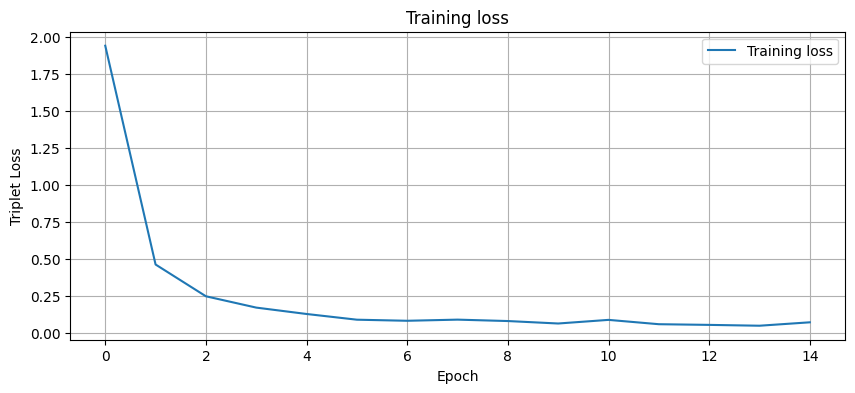

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0037


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4279


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2220


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1736


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1406


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1173


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0868


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0909


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0666


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0680


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0566


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0525


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0455


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0599


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0449


Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0369


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4545


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2545


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1874


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1297


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0890


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0899


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0790


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0816


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0755


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0741


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0592


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0507


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0528


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0378


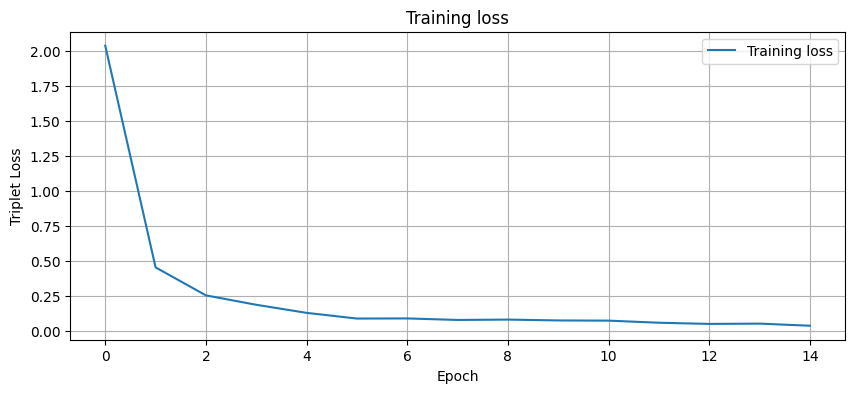

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9108


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.3994


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2586


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1455


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1419


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1120


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0988


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0755


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0885


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0679


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0752


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0459


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0392


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0508


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0610


Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9874


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4390


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2774


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1626


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1623


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1077


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1135


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0750


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0631


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0724


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0684


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0681


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0565


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0410


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0329


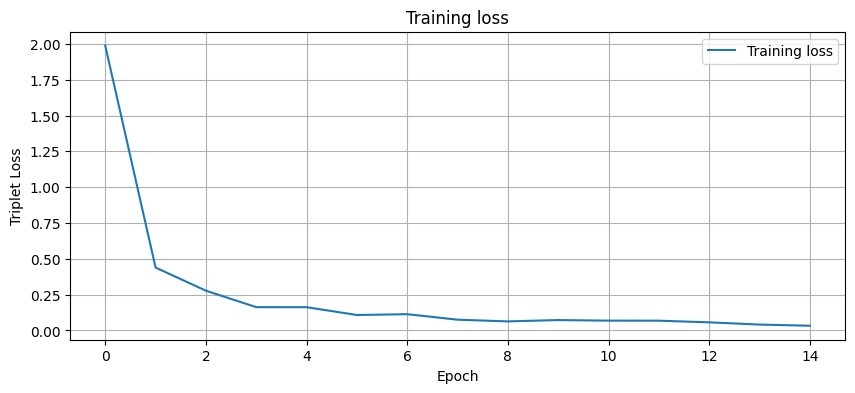

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0912


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4922


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2552


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1792


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1044


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1094


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0817


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0774


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0606


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0566


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0595


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0711


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0637


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0393


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0569


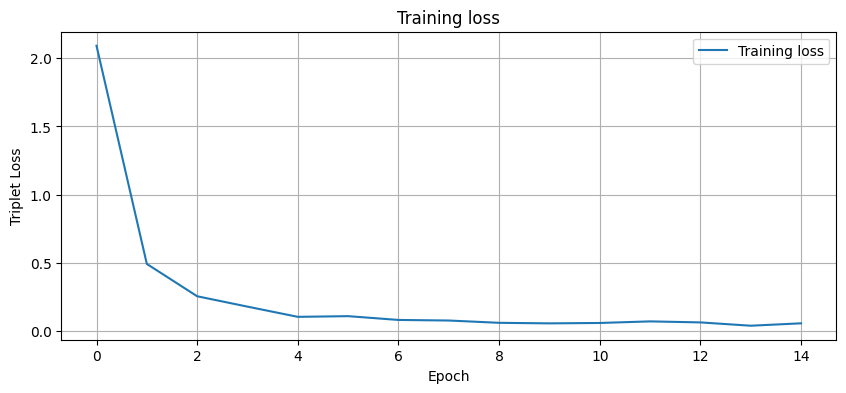

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9190


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4443


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2658


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1728


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1299


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1160


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0826


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0842


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0773


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0578


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0731


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0535


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0609


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0350


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0370


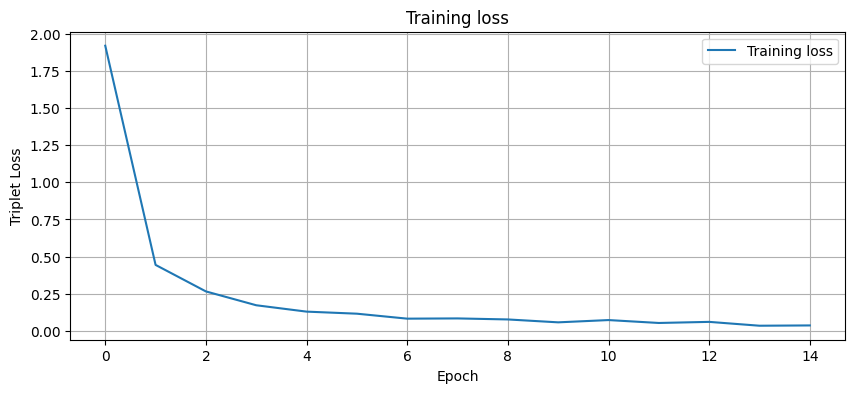

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9427


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4728


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2774


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1580


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1327


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0941


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0952


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0816


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0743


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0542


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0626


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0656


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0651


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0481


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0226


Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9116


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4881


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2523


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1556


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1064


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0944


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1148


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0828


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0598


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0549


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0623


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0604


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0377


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0392


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0483


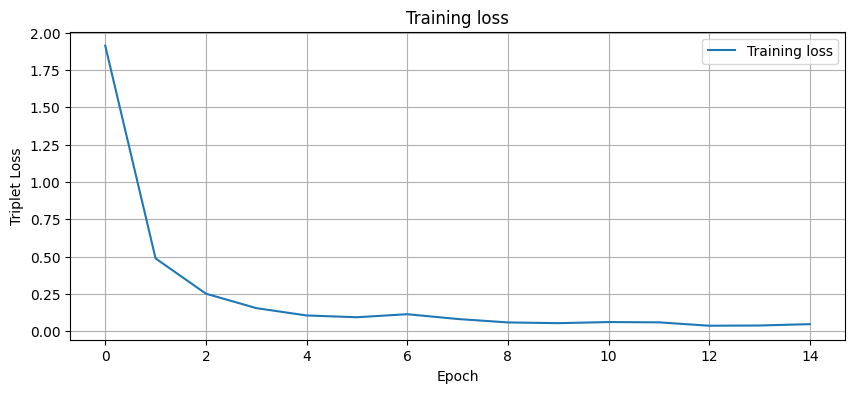

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0169


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4934


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2839


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1821


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1331


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1163


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0979


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0705


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0687


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0839


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0430


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0636


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0553


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0496


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0336


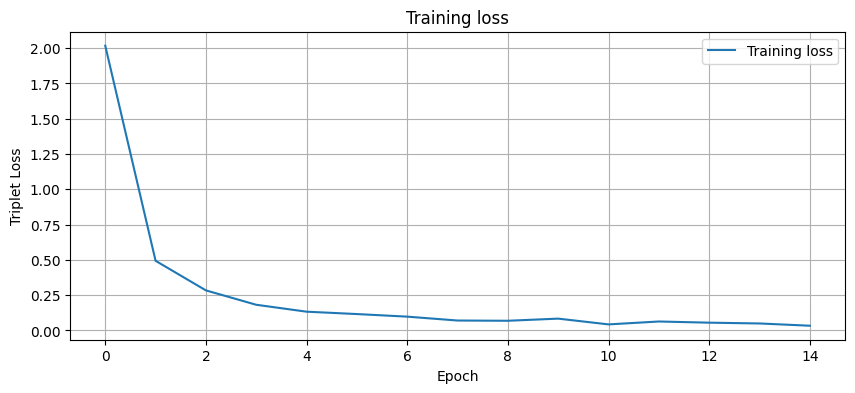

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0772


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4563


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2722


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1633


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1329


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1133


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0938


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0852


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0590


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0411


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0353


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0560


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0445


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0546


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0518


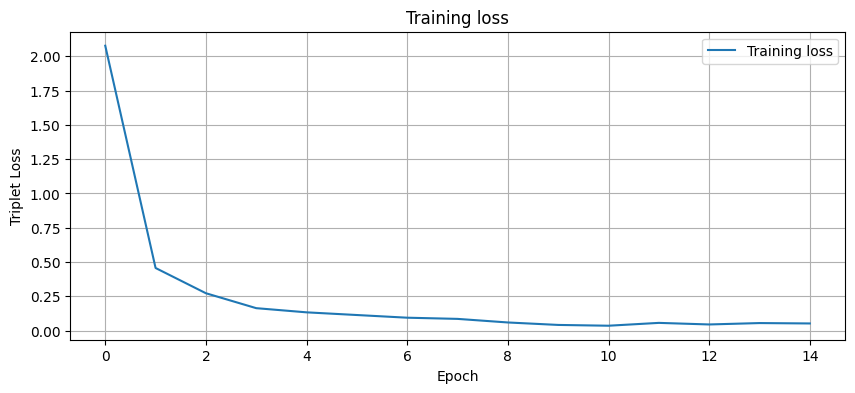

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9481


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4806


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2906


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1854


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1368


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1182


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0867


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0970


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0595


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0662


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0592


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0583


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0494


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0569


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0587


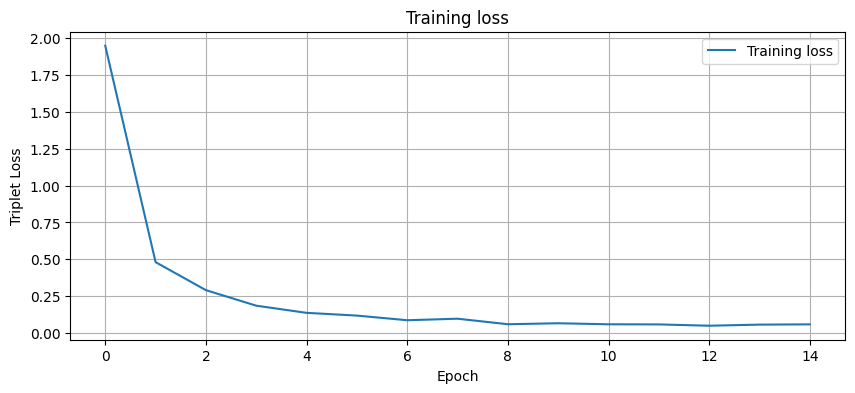

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9045


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4612


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2513


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1812


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1406


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1184


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0988


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.1032


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0719


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0665


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0524


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0434


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0675


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0669


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0442


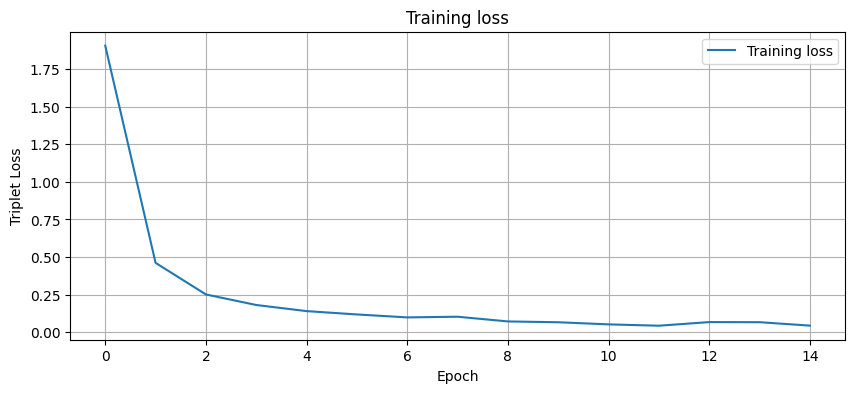

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9817


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4722


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.3099


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1561


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1562


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1144


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0972


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0983


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0612


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0624


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0620


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0642


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0490


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0451


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0461


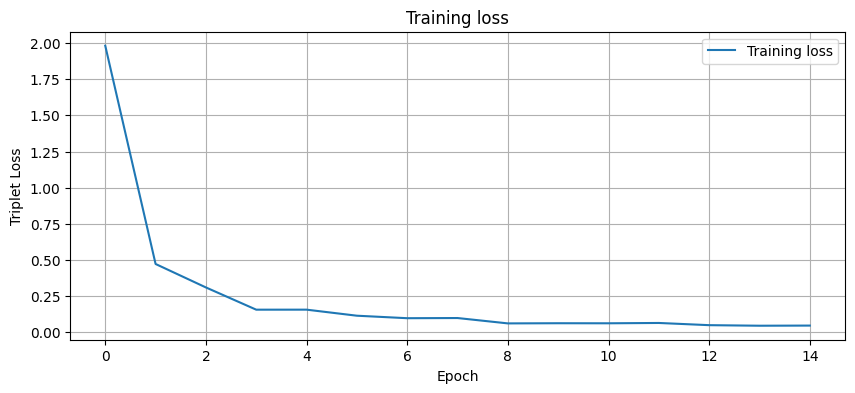

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.1549


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4628


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2492


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1854


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1285


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0897


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0867


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.1147


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0760


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0594


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0650


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0632


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0520


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0395


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0526


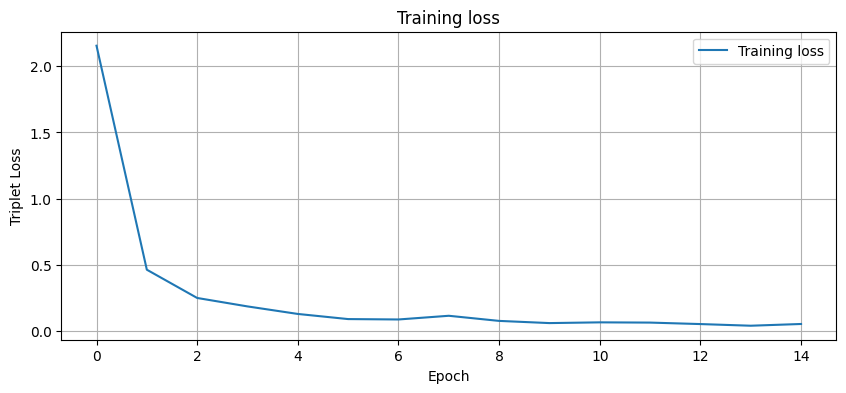

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0586


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4334


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2528


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1813


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1301


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1062


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0930


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0867


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0590


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0611


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0647


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0668


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0523


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0557


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0407


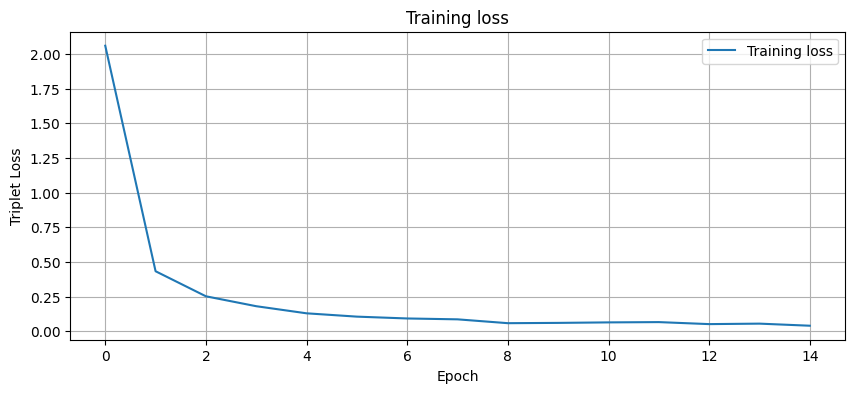

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0093


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4377


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2989


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1493


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1314


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0977


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0934


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0938


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0734


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0726


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0861


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0622


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0576


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0466


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0578


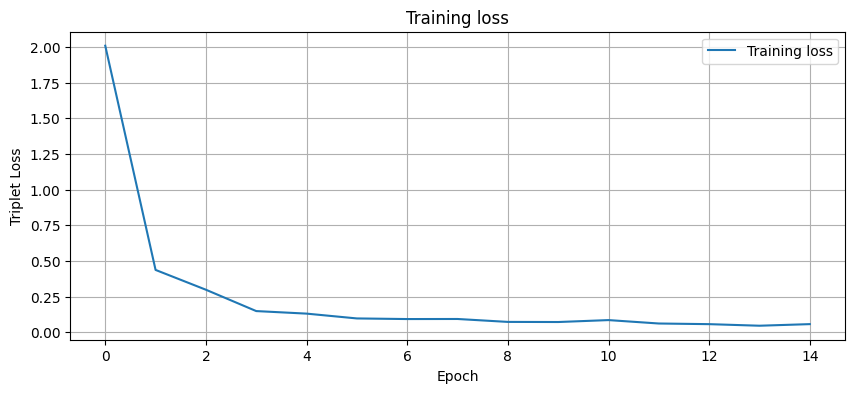

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0568


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4762


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2646


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1985


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1500


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1172


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0853


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0705


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0590


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0714


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0681


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0531


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0480


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0545


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0466


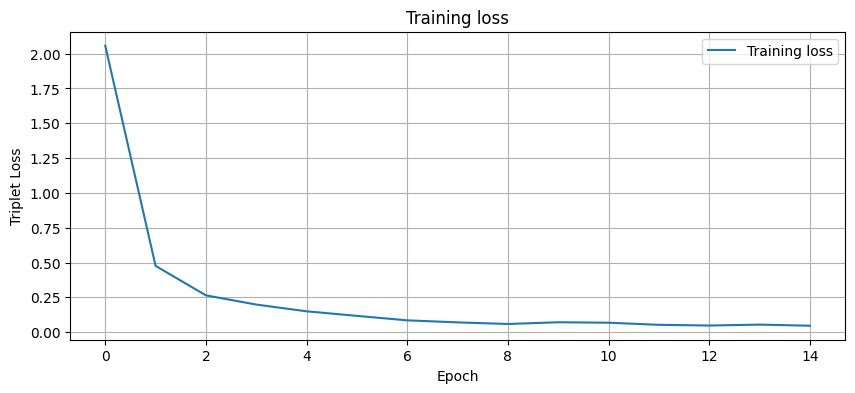

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9419


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4585


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2479


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1810


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1433


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1095


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0908


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0797


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.1005


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0667


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0558


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0652


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0559


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0529


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0506


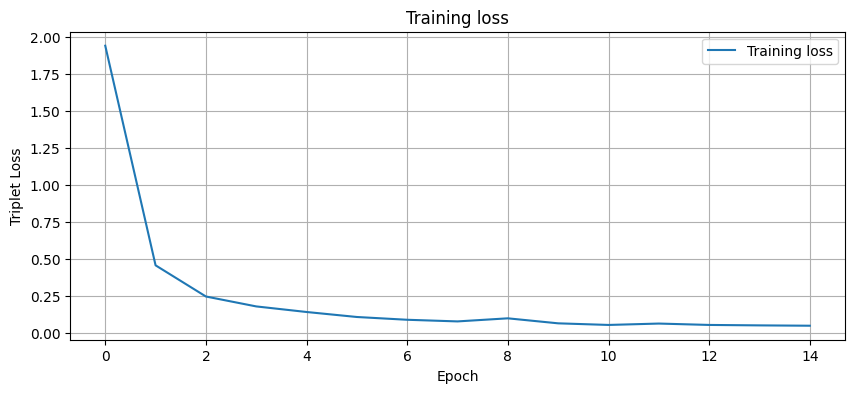

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0168


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4308


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2547


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1799


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1310


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1194


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0933


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0805


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0782


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0778


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0758


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0673


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0579


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0547


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0322


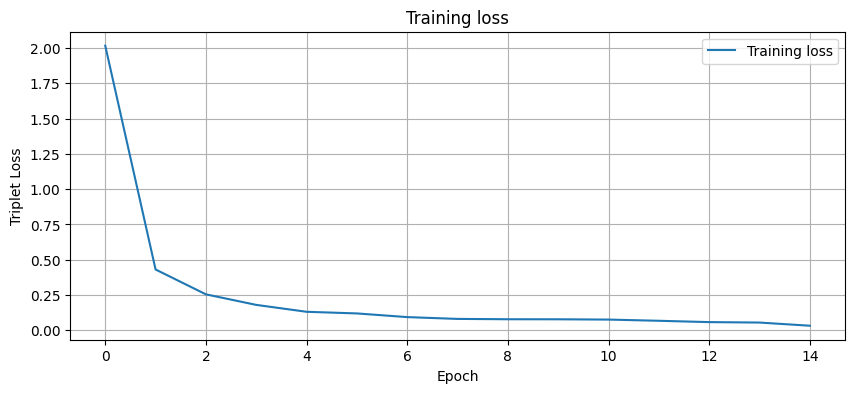

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9700


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.5023


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.3350


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.2127


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1247


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1223


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1063


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0863


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0585


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0699


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0581


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0590


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0396


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0413


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0463


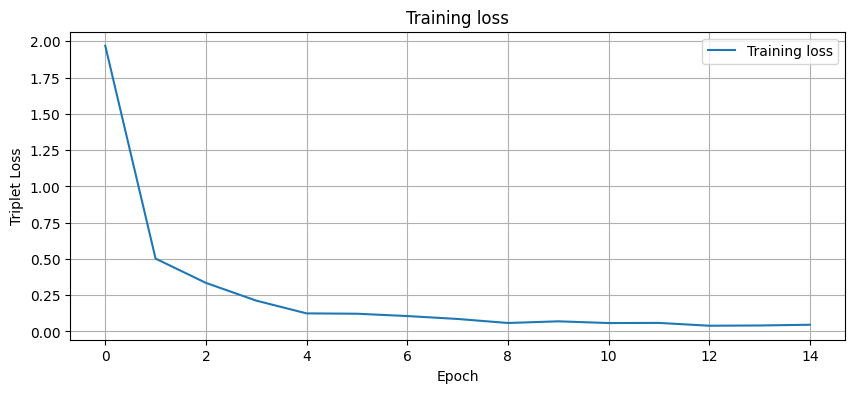

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9441


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4492


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2819


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1642


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1432


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1159


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0865


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0652


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0587


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0717


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0733


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0588


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0422


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0503


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0259


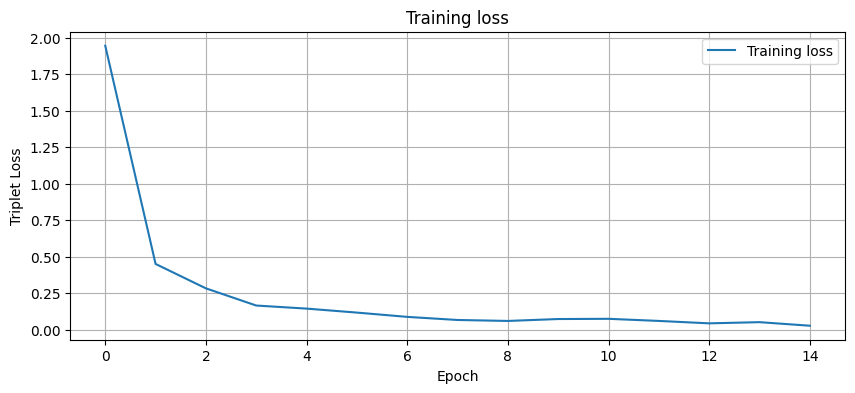

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9424


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4646


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2507


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1774


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1149


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1046


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0874


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.1010


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0739


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0795


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0354


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0421


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0400


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0463


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0503


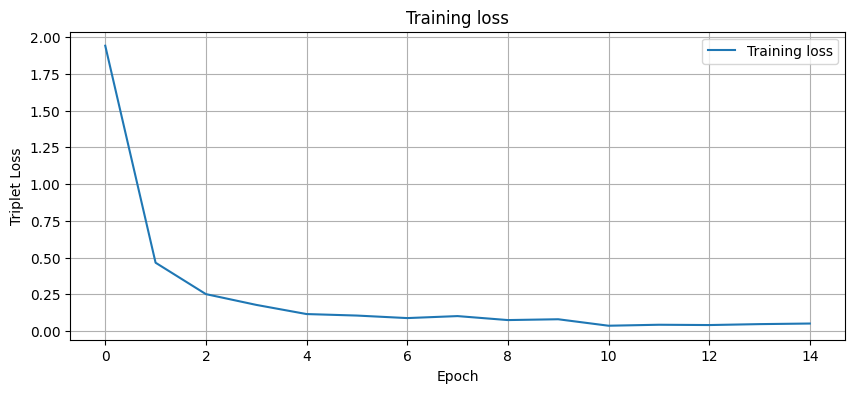

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0181


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4510


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2460


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1983


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1278


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1292


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0941


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0777


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0691


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0748


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0579


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0359


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0514


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0405


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0505


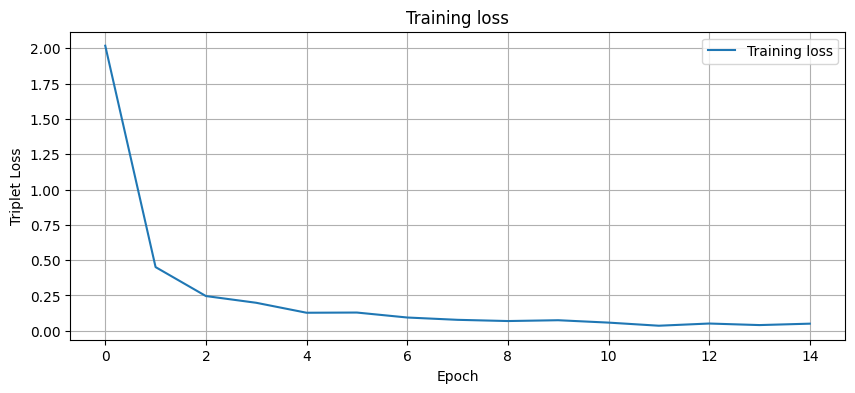

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.1193


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4835


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2591


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1814


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1272


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1131


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0807


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0791


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0690


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0642


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0691


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0631


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0470


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0730


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0480


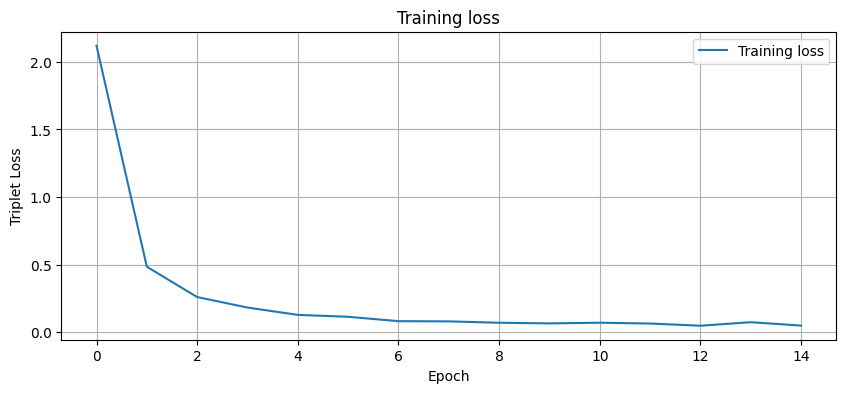

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9172


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4808


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2390


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1666


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1238


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0995


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1018


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0982


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0638


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0581


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0540


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0443


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0645


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0427


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0304


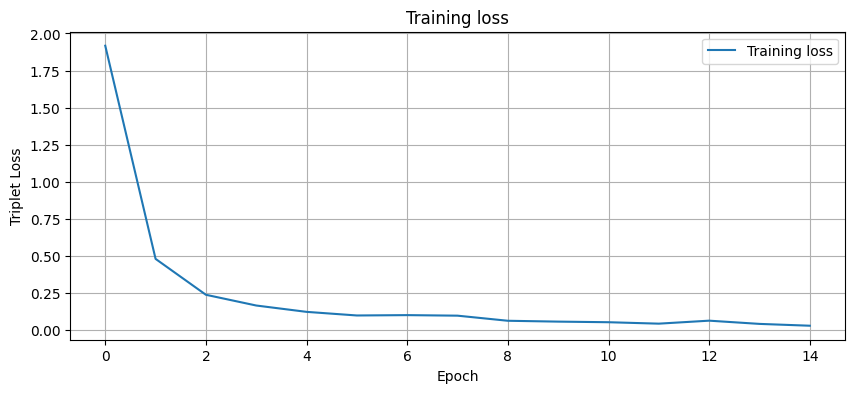

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9910


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4682


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2620


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.2031


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1343


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1098


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0914


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0815


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0569


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0614


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0524


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0552


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0599


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0590


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0592


Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9642


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4329


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2512


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1909


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1267


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1347


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1173


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0819


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0571


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0682


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0742


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0481


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0668


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0583


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0485


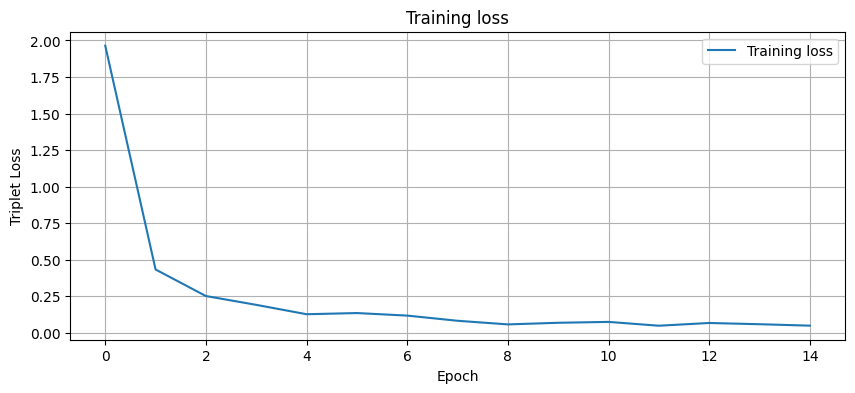

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0156


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4815


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2429


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1806


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1017


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1048


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0708


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0667


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0597


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0633


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0606


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0472


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0482


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0529


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0401


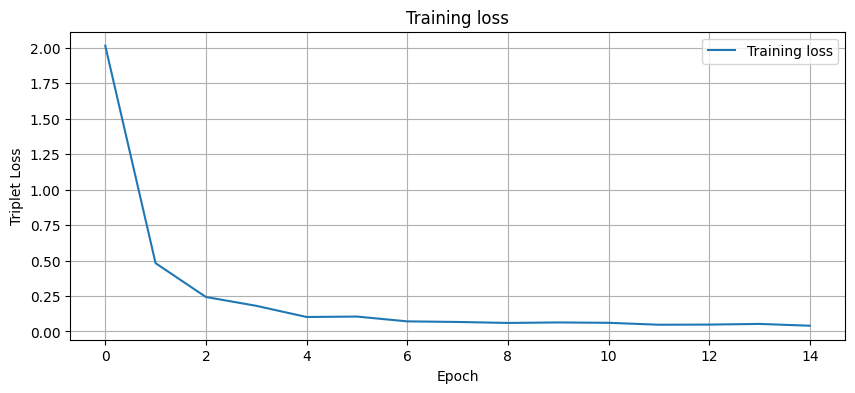

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0114


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4345


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2469


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1808


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1447


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1173


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0791


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0724


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0866


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0766


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0679


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0624


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0550


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0424


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0442


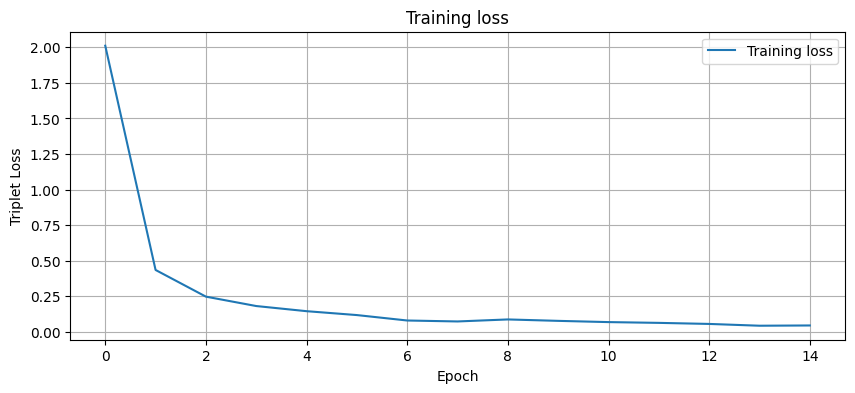

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0859


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4715


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2709


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1513


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1293


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0850


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0890


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0719


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.1058


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0889


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0578


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0588


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0595


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0438


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0421


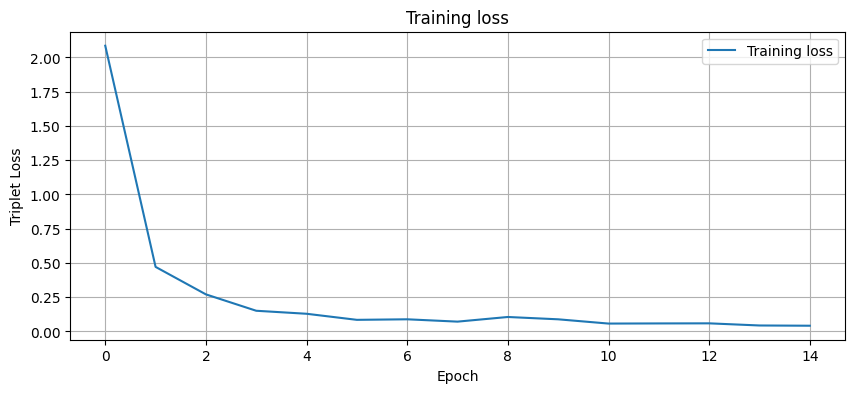

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9361


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.5077


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2512


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1507


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1591


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1381


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1078


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0981


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0559


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0757


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0747


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0513


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0480


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0502


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0558


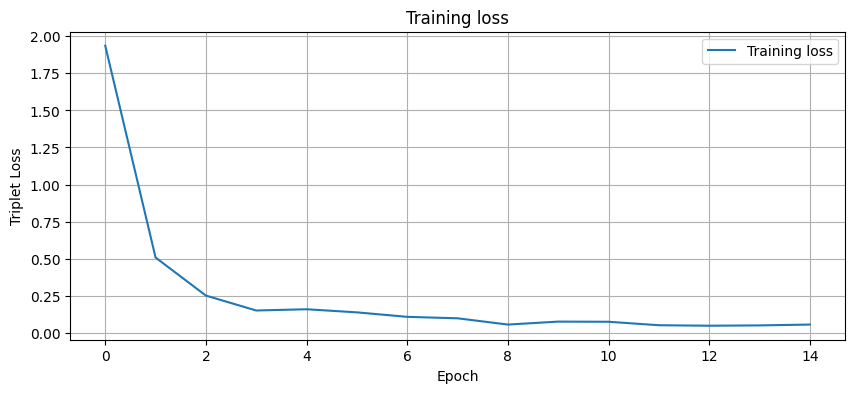

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9572


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4291


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2720


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1809


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1224


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0966


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1072


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0627


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0736


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0788


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0569


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0564


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0485


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0395


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0568


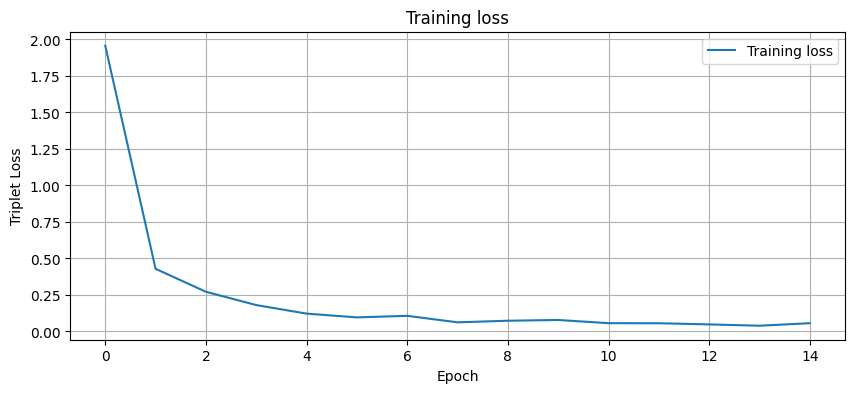

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.8571


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4938


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2469


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1652


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1593


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1216


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0911


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0802


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0820


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0856


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0576


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0693


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0669


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0490


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0472


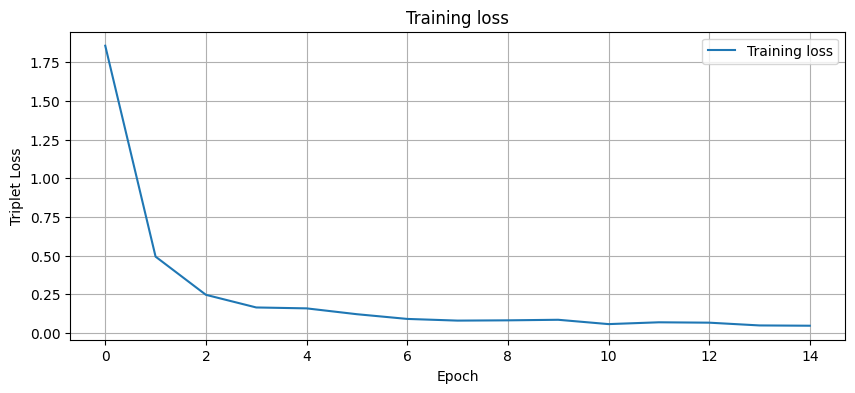

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0201


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4660


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2510


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1812


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1270


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1093


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0785


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0783


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0690


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0622


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0547


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0544


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0577


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0565


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0530


Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0370


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4825


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2420


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1431


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1348


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1064


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0791


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0687


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0502


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0613


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0583


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0457


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0392


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0559


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0388


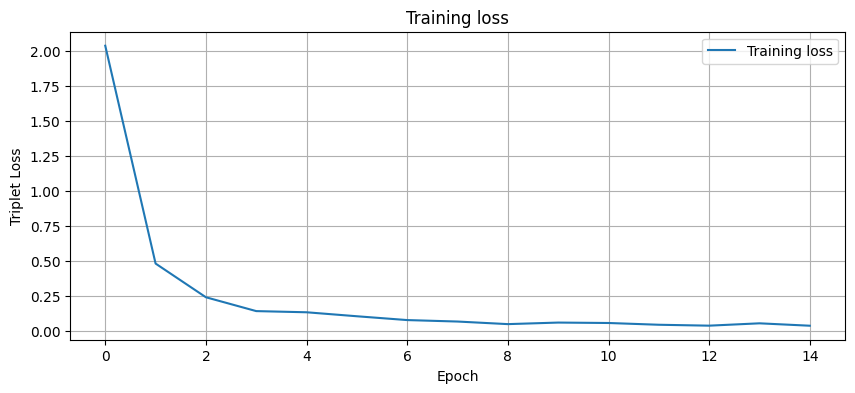

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0879


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4245


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2503


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1725


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1277


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1093


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0994


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0823


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0754


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0679


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0413


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0603


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0440


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0550


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0729


Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.8747


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4661


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2534


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1983


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1393


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1058


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0905


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0808


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0768


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0628


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0506


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0477


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0592


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0603


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0576


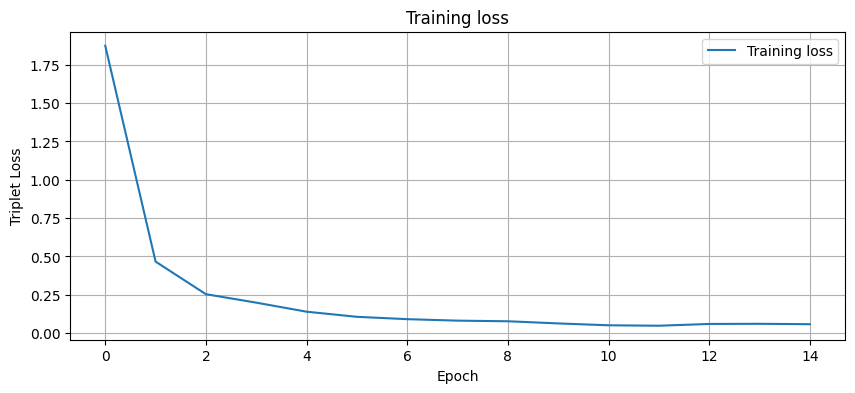

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9932


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4130


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2734


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1708


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1234


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1101


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0786


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0886


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0735


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0717


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0662


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0432


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0497


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0445


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0510


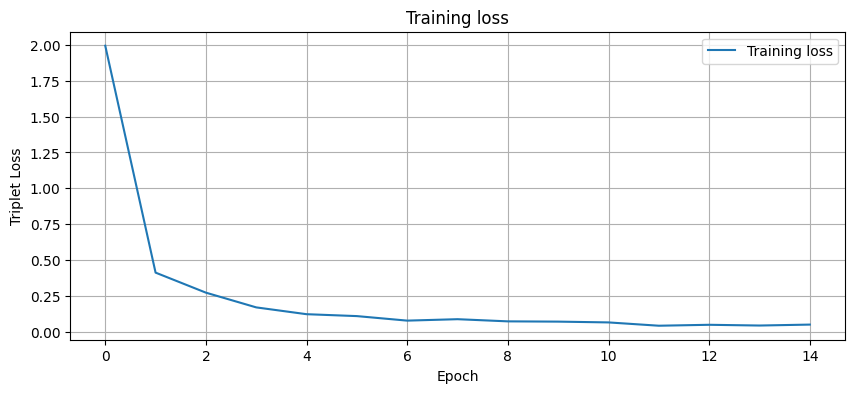

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0556


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4434


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2626


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1526


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1266


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0897


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0851


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0708


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0588


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0692


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0677


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0382


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0546


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0455


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0361


Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0039


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4368


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2380


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1933


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1757


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1051


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0923


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0916


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0743


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0770


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0668


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0521


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0427


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0529


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0598


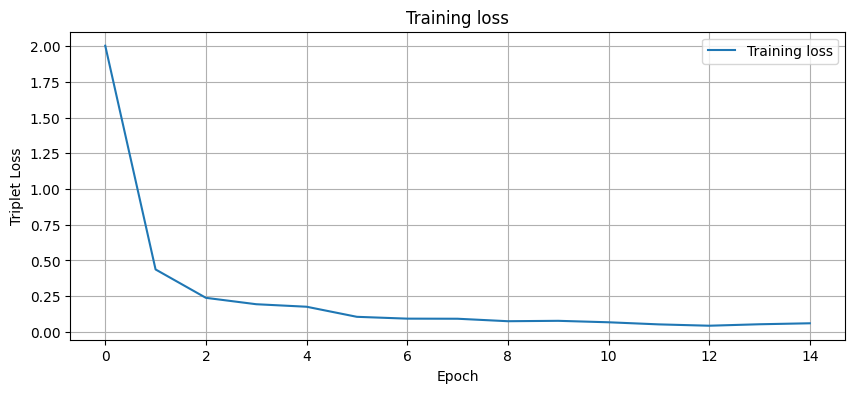

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9062


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4188


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2411


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1485


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1222


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1077


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0977


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0998


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0768


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0837


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0431


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0675


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0602


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0556


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0497


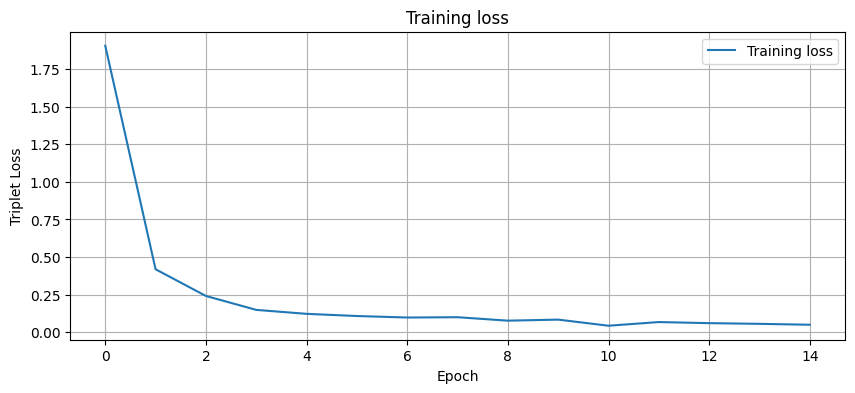

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9176


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4654


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2432


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1818


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1211


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1085


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0979


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0795


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0707


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0600


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0615


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0401


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0379


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0552


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0370


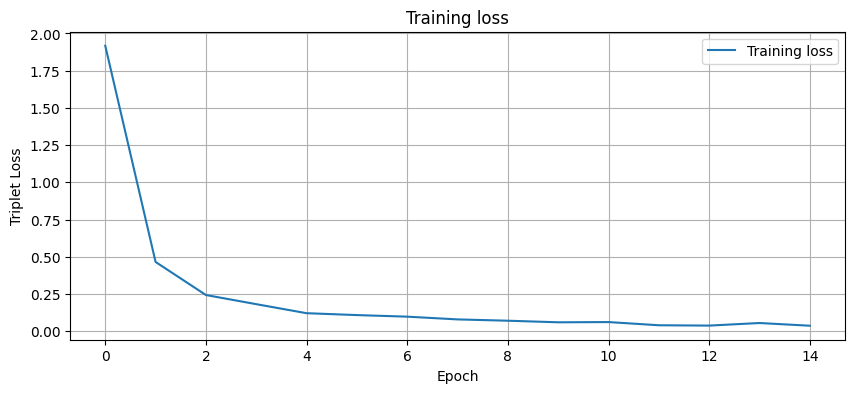

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9459


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4754


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2289


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1502


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1421


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1007


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1127


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0738


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0914


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0663


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0547


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0516


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0608


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0391


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0451


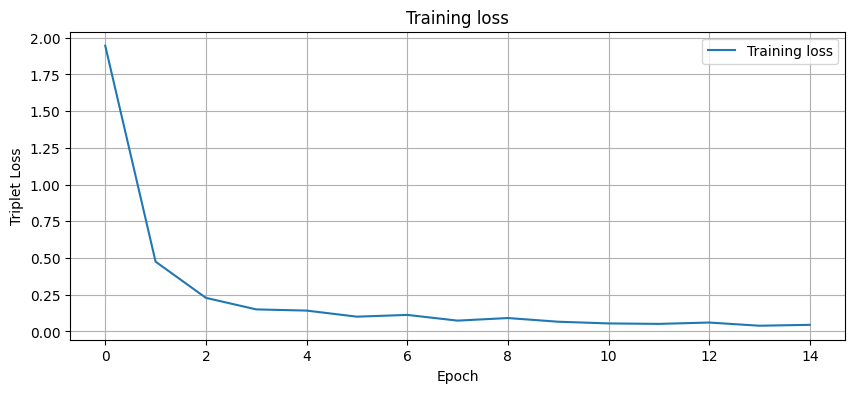

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0171


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4756


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2341


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1873


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1372


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1152


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0986


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0836


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0714


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0625


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0652


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0476


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0468


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0479


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0440


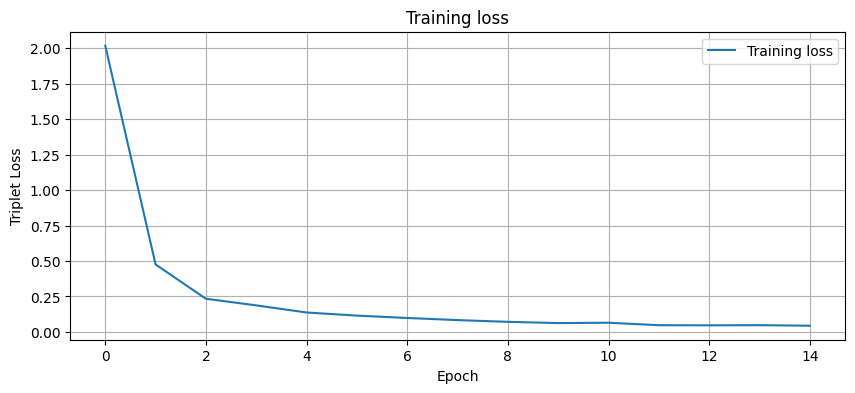

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9911


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4331


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2197


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1928


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1204


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1300


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0969


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0914


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0754


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0646


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0665


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0804


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0373


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0314


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0578


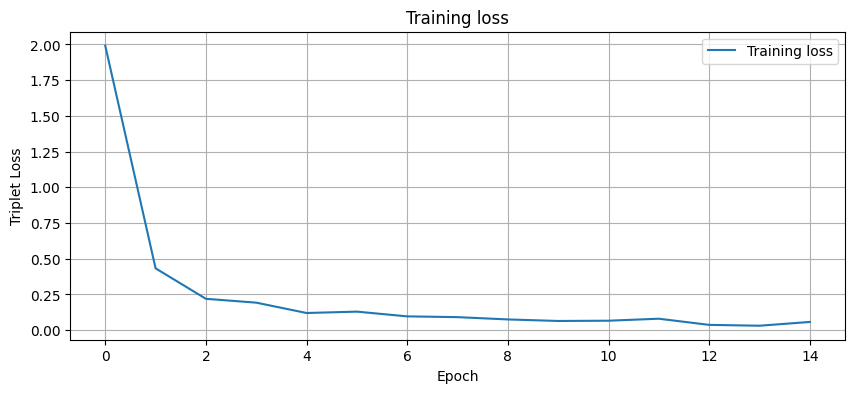

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9578


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4311


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2222


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1681


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1391


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0997


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0838


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0828


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0799


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0632


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0524


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0565


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0450


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0338


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0334


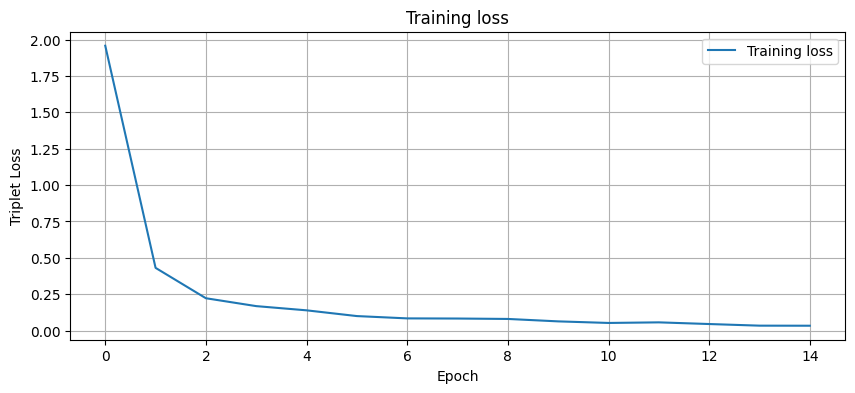

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0201


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4848


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2796


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1635


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1274


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1248


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0893


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0742


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0766


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0629


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0610


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0500


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0548


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0387


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0451


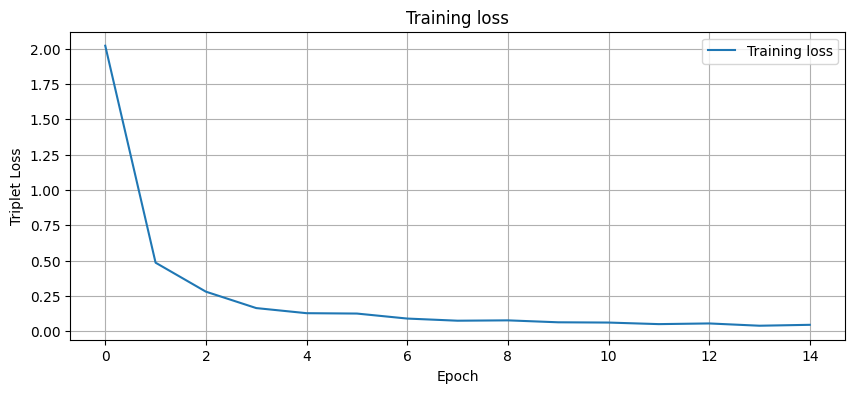

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0519


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4030


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2890


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1866


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1402


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0897


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0934


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0631


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0667


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0693


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0595


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0380


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0494


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0590


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0518


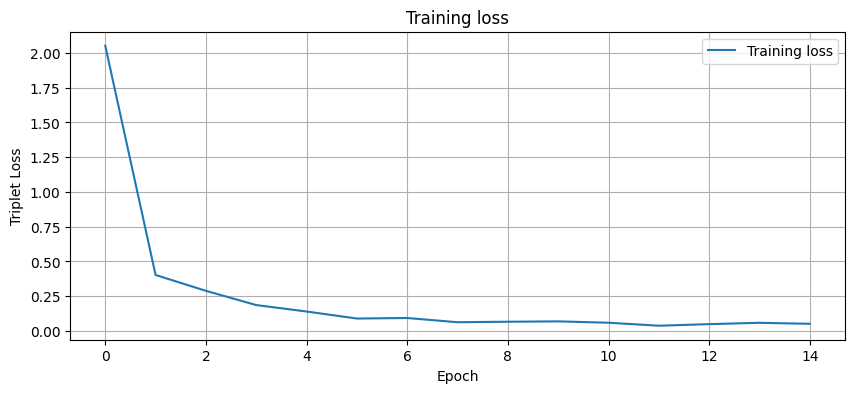

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.1105


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4664


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2246


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1752


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1284


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1247


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0867


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0712


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0737


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0639


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0590


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0377


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0493


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0393


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0599


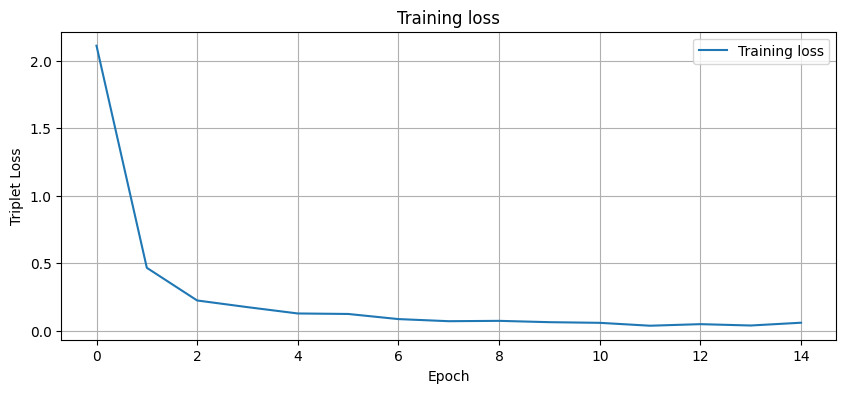

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0461


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4923


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2365


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1964


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1656


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1178


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1009


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0729


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0512


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0605


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0693


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0429


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0602


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0509


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0560


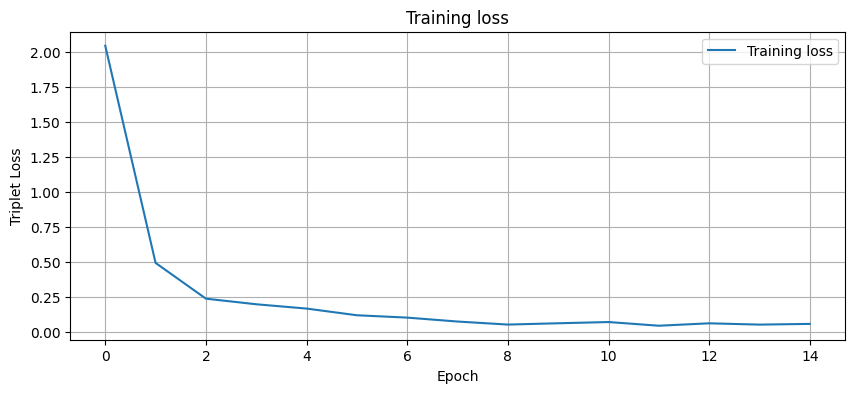

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0389


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4552


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2704


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1723


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1449


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1352


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0972


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0724


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0555


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0767


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0604


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0561


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0615


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0345


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0529


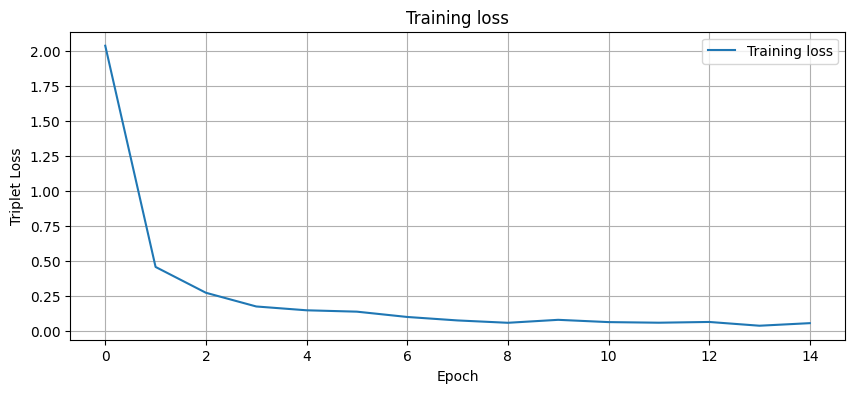

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0262


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4680


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2875


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1726


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1349


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0923


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1158


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0914


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0607


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0667


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0613


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0595


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0401


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0391


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0532


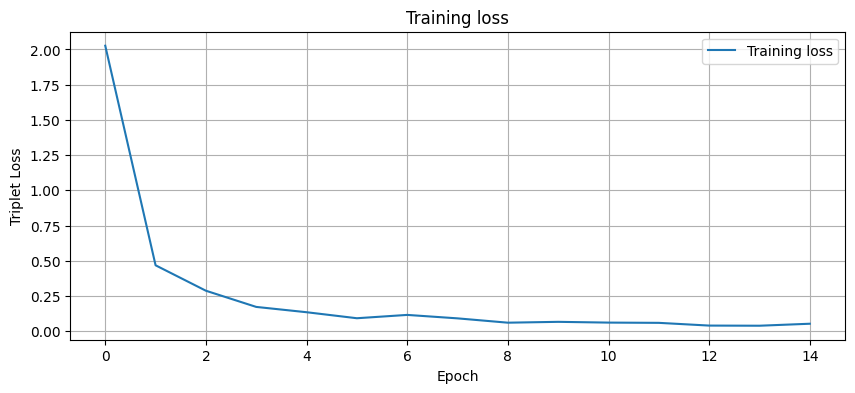

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0353


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4491


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2308


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1561


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1628


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0873


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0797


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0840


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0628


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0645


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0631


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0508


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0497


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0576


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0452


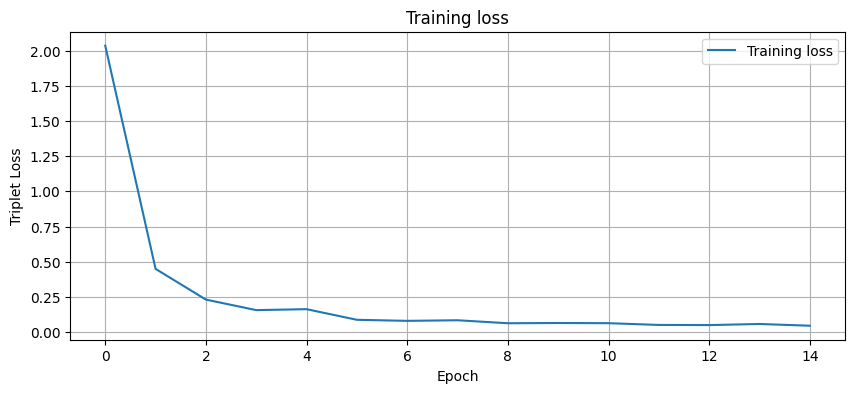

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0129


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4545


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2501


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1573


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1296


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1015


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1023


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.1058


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0855


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0651


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0683


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0506


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0416


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0654


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0570


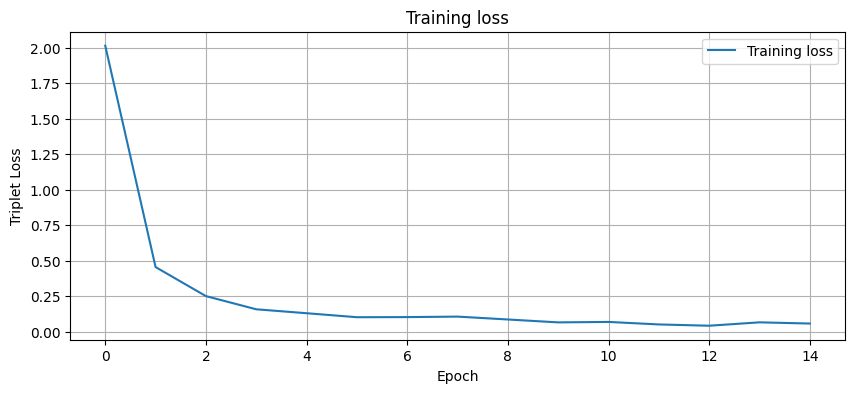

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.8708


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4053


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2649


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1689


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1108


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1162


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1084


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0905


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0946


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0546


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0550


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0790


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0529


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0397


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0462


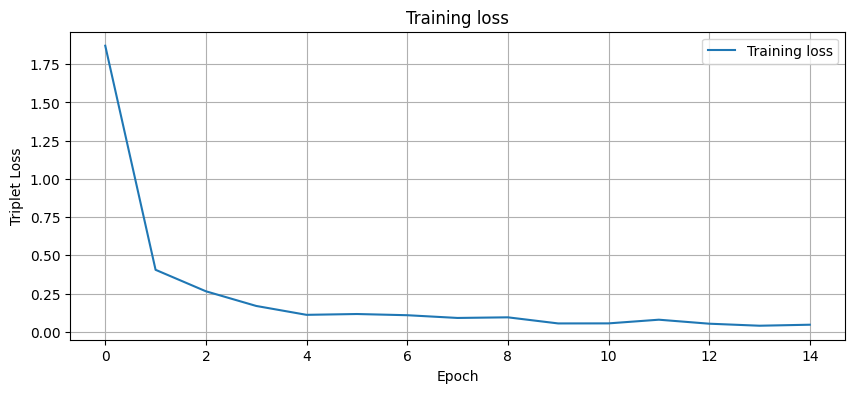

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9981


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4550


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2500


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1748


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1437


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1016


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0997


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0924


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0774


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0487


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0659


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0584


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0525


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0610


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0489


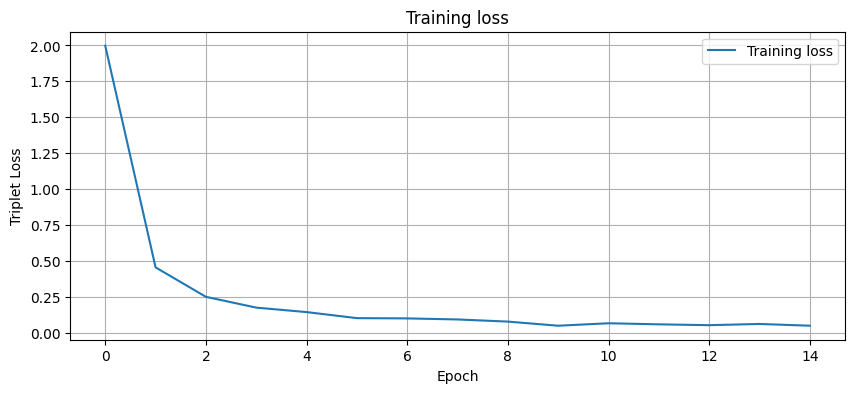

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0252


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4844


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2443


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1739


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1280


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1043


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0875


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0981


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0642


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0429


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0674


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0634


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0496


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0600


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0563


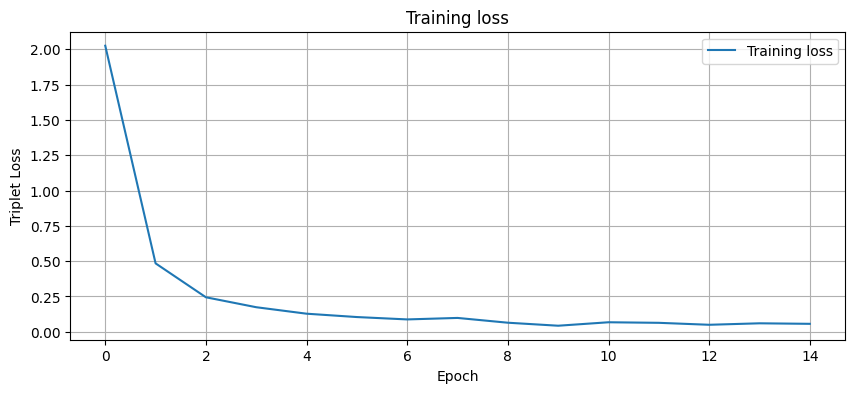

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9588


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4564


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2327


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.2018


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1479


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1330


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0988


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0863


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0686


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0646


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0436


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0615


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0507


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0360


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0460


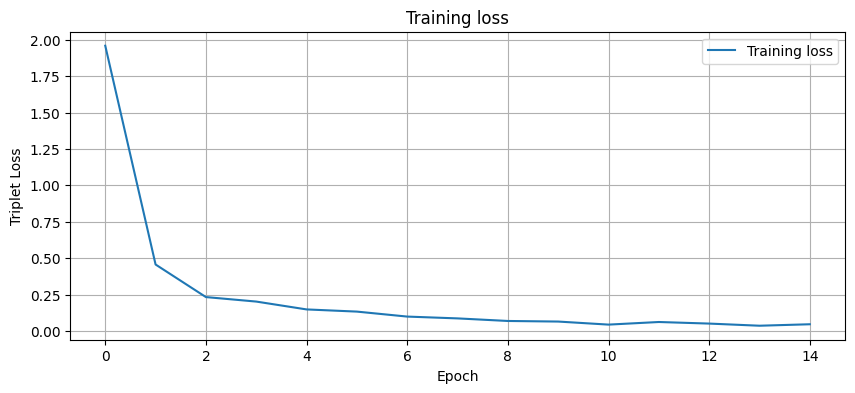

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0329


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4501


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2547


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.2071


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1518


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1160


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0645


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0689


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0681


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0653


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0610


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0770


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0343


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0427


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0551


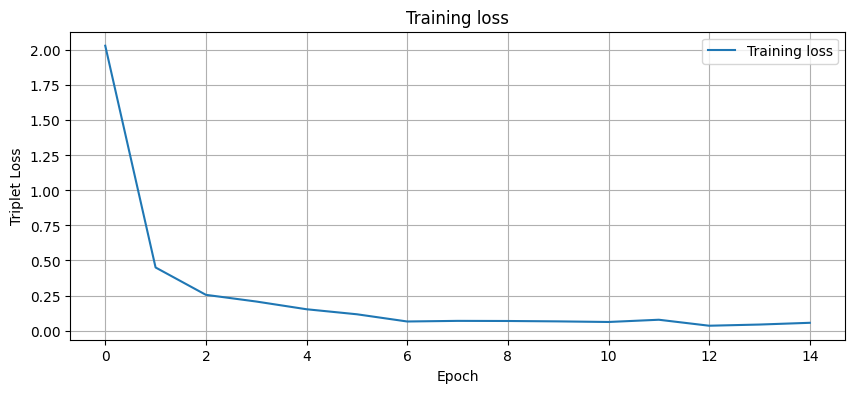

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9281


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4111


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2083


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.2013


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1396


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1258


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0700


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0972


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0732


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0700


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0539


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0601


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0592


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0517


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0475


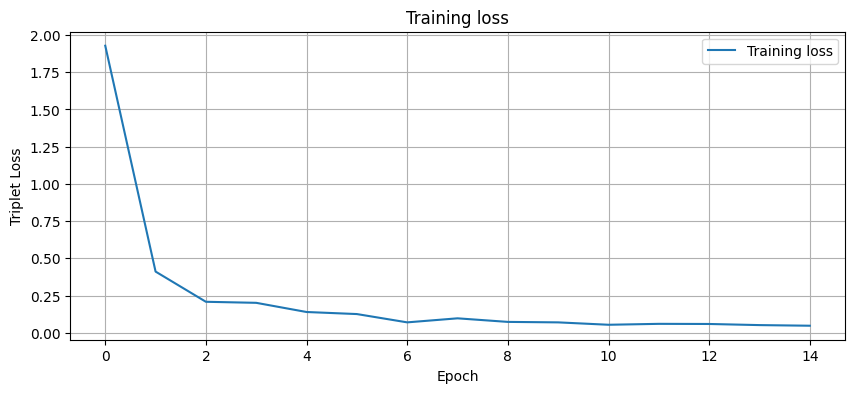

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0430


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4996


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2556


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1779


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1500


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0869


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1247


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0765


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0587


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0518


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0716


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0637


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0723


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0454


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0496


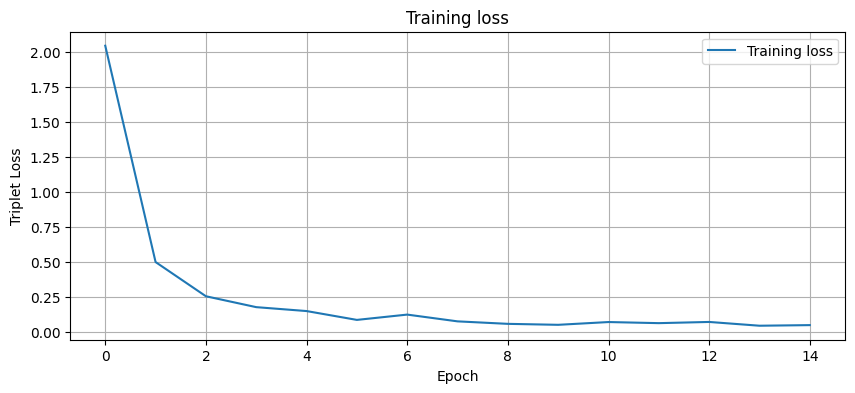

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.8434


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4789


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2409


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1730


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1292


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1327


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0807


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0736


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0693


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0752


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0621


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0822


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0829


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0531


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0359


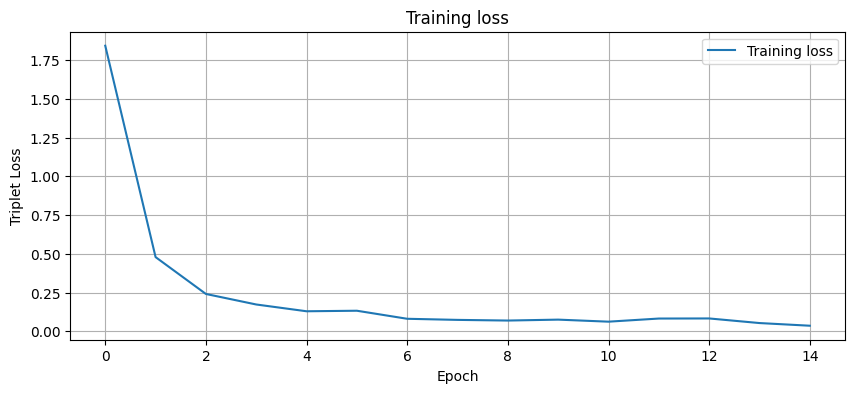

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0061


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4946


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2661


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1685


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1169


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1091


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1102


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0749


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0795


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0700


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0750


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0706


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0449


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0385


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0355


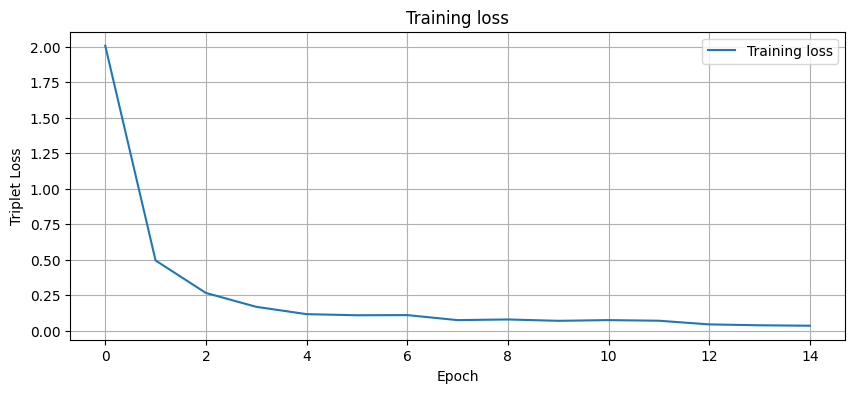

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.8891


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4233


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2589


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1857


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1605


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1044


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1094


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0829


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0553


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0697


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0674


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0492


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0530


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0518


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0515


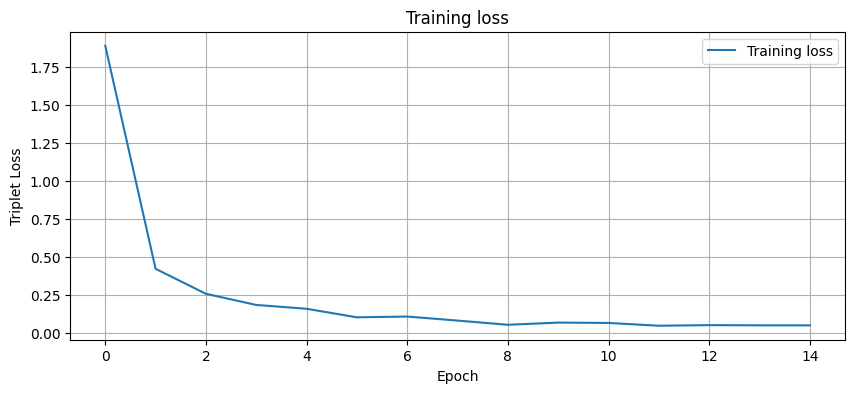

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0060


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4193


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2700


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1704


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1362


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1003


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0788


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0826


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0771


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0414


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0756


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0415


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0627


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0418


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0350


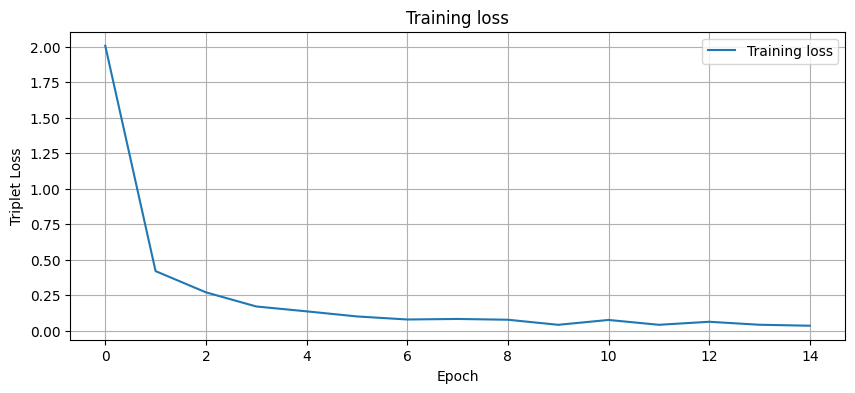

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9007


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4058


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2636


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.2016


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1165


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1091


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0727


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0752


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0741


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0536


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0583


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0512


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0585


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0428


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0568


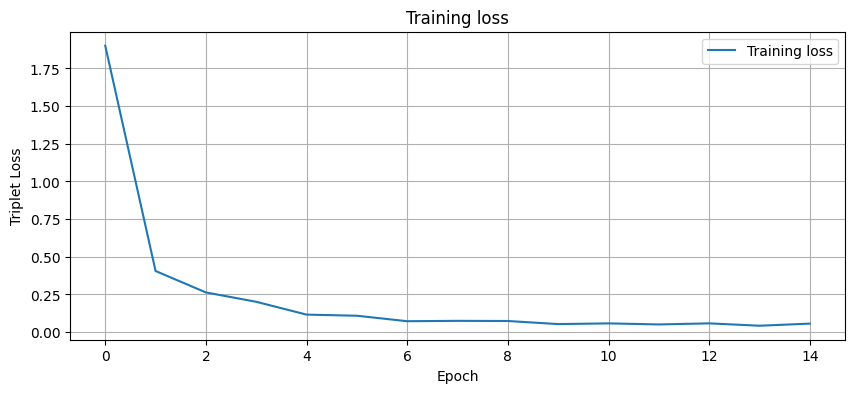

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9793


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4495


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2770


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1732


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1445


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1099


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1058


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0876


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0645


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0676


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0569


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0599


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0542


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0439


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0443


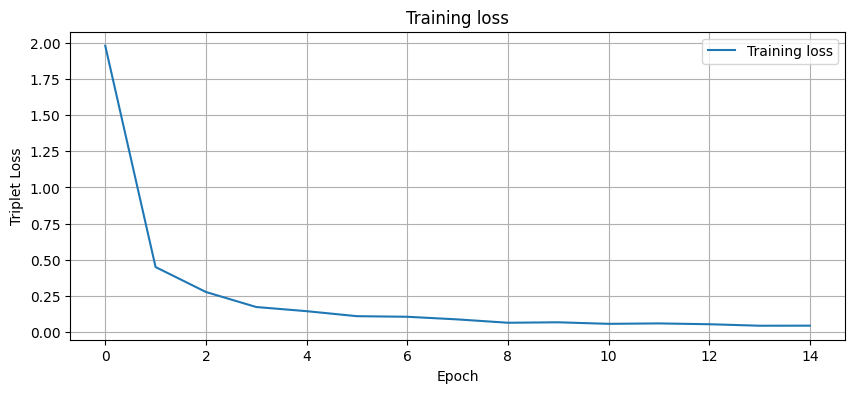

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9998


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4699


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2240


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1546


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1474


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0851


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0661


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0900


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0786


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0476


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0712


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0592


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0475


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0478


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0486


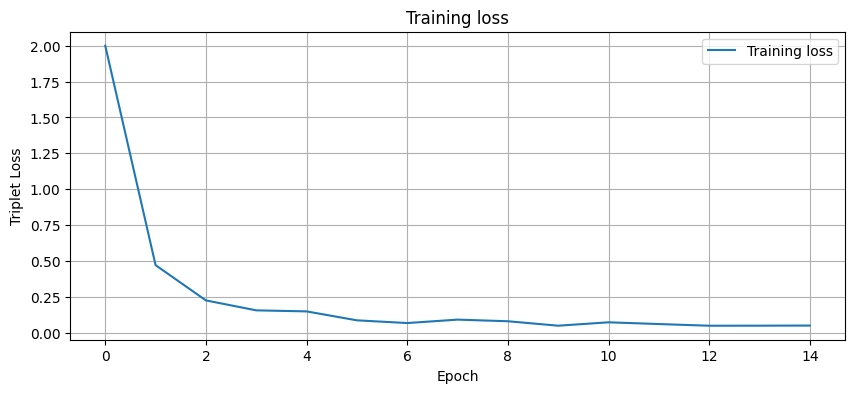

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0322


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4350


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2330


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1448


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1281


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1373


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0828


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0820


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0730


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0881


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0528


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0763


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0579


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0353


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0456


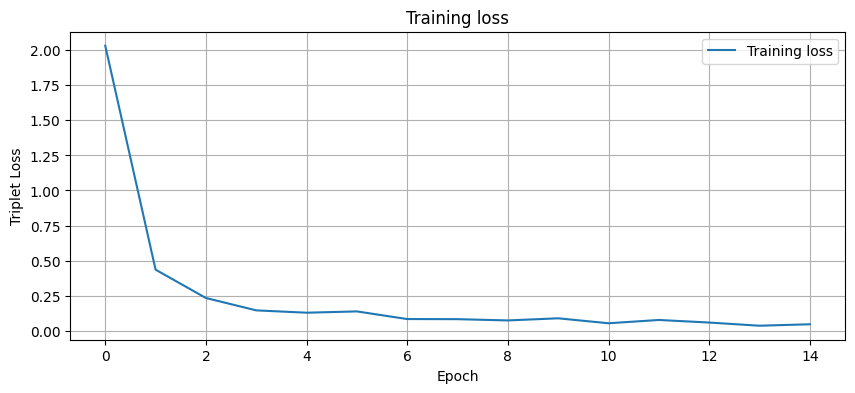

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.7664


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4499


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2424


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1614


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1631


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1230


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1028


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0823


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0854


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0711


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0542


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0435


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0473


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0459


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0537


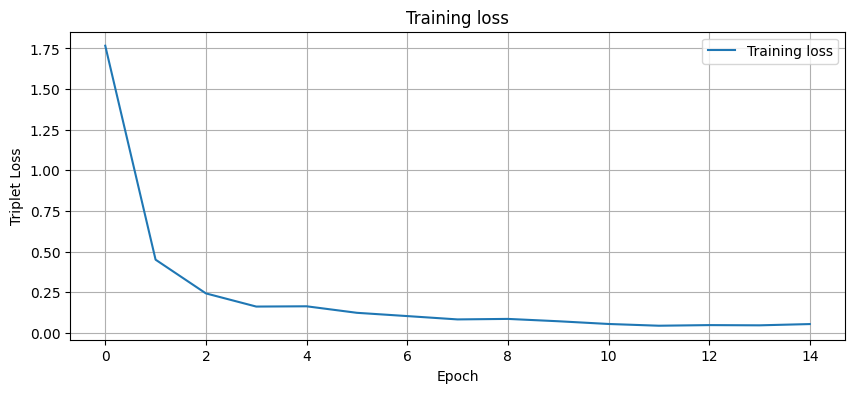

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.8963


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4567


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2268


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1630


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1125


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0977


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1035


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0637


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0767


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0635


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0808


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0665


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0507


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0539


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0514


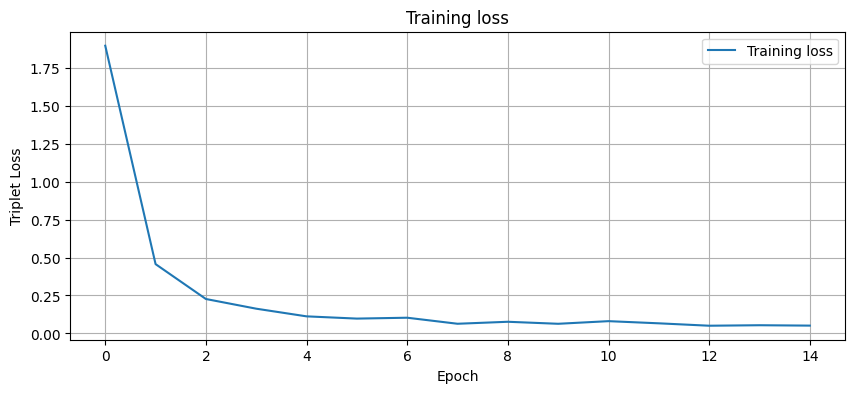

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.8456


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4618


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2624


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1651


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1465


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0984


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0976


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0908


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0836


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0576


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0614


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0695


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0485


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0349


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0492


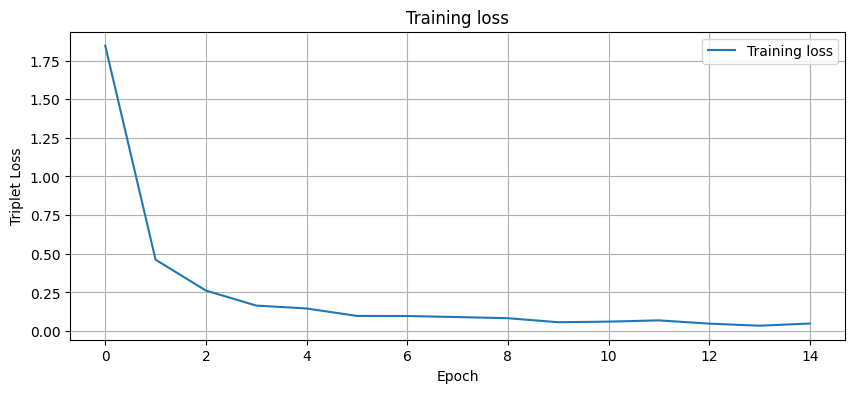

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9452


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4574


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2343


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1474


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1421


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1009


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1066


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0891


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0568


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0484


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0638


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0582


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0407


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0381


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0597


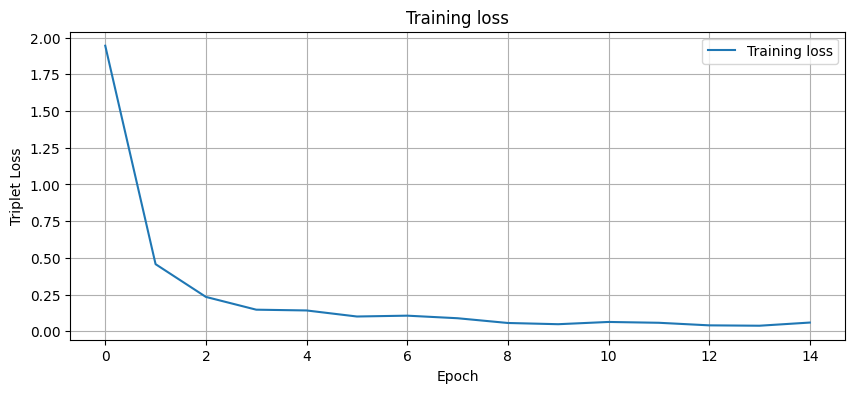

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0114


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4682


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2030


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1826


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1386


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0970


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0915


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0707


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0864


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0720


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0558


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0569


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0471


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0568


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0636


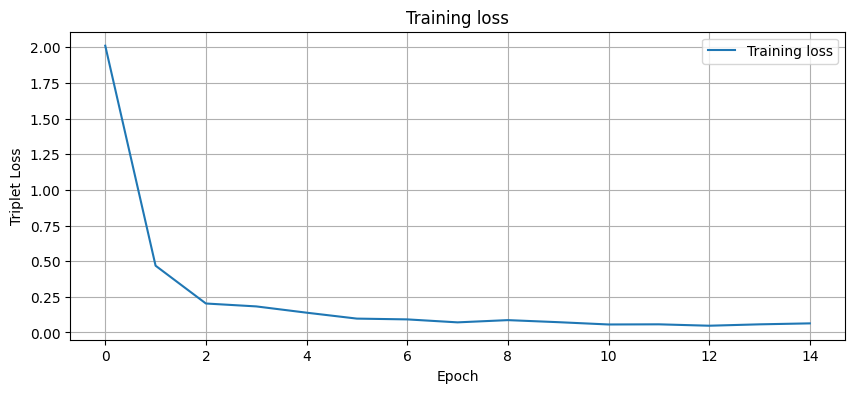

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.8507


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4400


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2631


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1976


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1202


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1192


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0833


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.1051


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0912


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0697


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0473


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0677


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0391


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0403


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0380


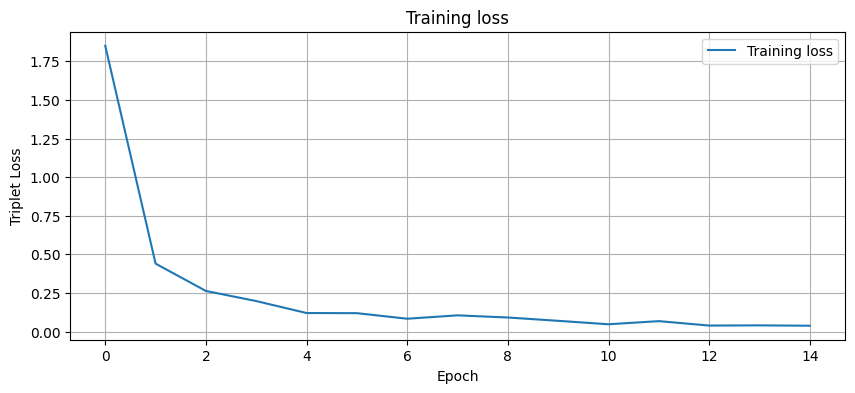

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0424


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4628


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2383


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1765


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1483


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1200


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0820


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0857


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0709


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0519


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0783


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0633


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0469


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0404


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0499


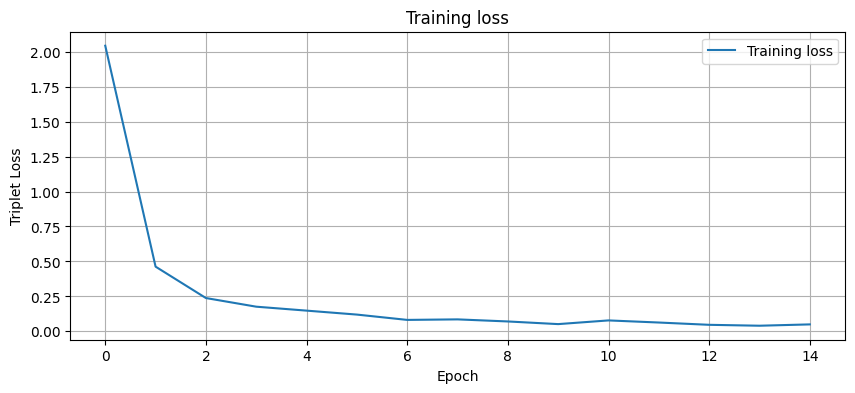

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0188


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4180


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2724


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1783


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1305


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0971


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0899


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0750


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0659


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0668


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0584


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0451


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0651


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0450


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0606


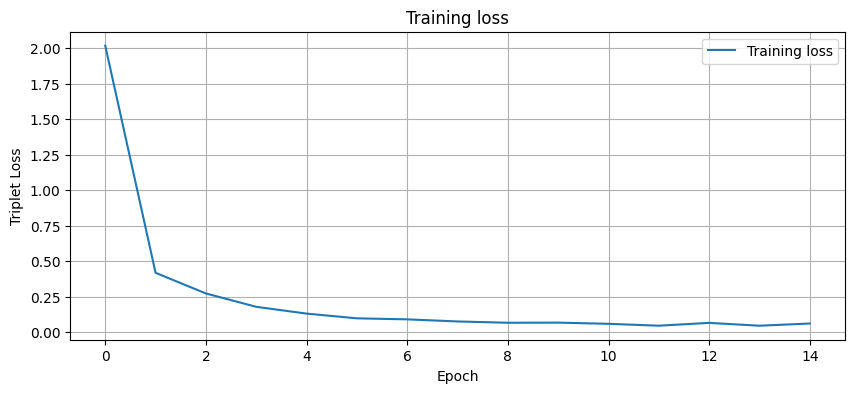

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0204


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4388


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2603


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1886


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1483


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1132


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1074


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0672


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0585


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0692


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0572


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0471


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0428


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0682


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0730


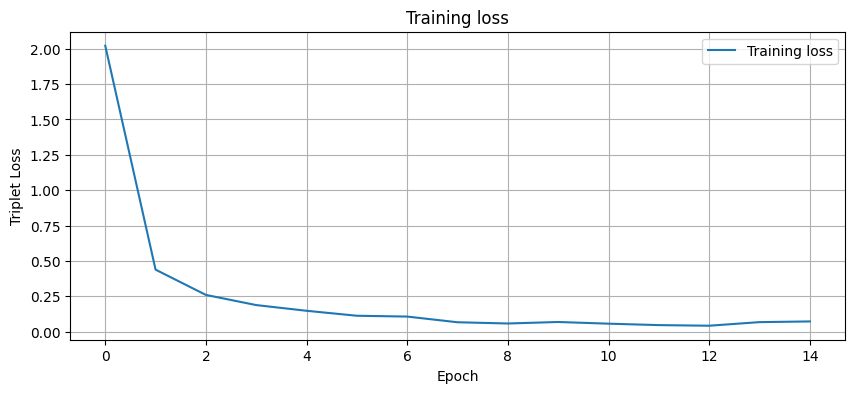

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0224


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4738


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2858


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1536


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1364


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0941


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0784


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0801


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0954


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0804


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0633


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0577


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0395


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0413


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0436


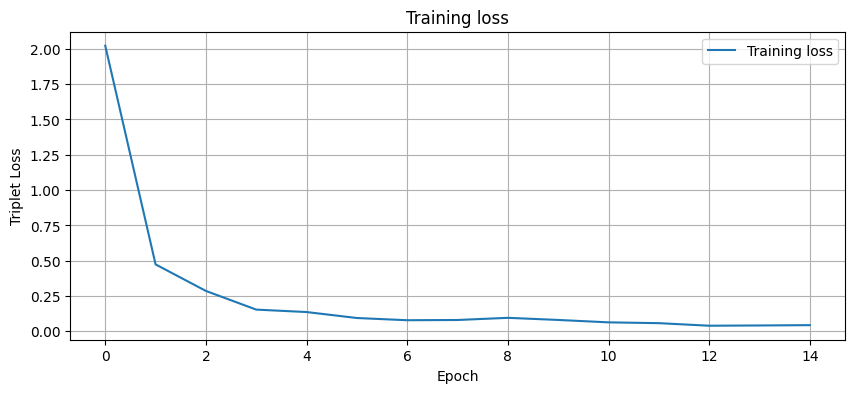

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9254


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4337


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2301


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1788


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1469


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1158


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1217


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.1094


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0675


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0504


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0531


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0580


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0469


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0523


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0507


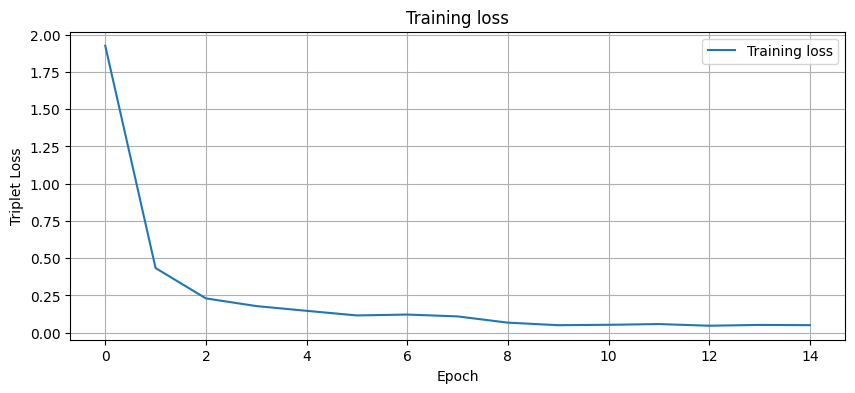

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0726


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4364


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2324


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1820


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1135


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1158


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0826


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0850


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0633


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0786


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0698


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0661


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0374


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0400


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0573


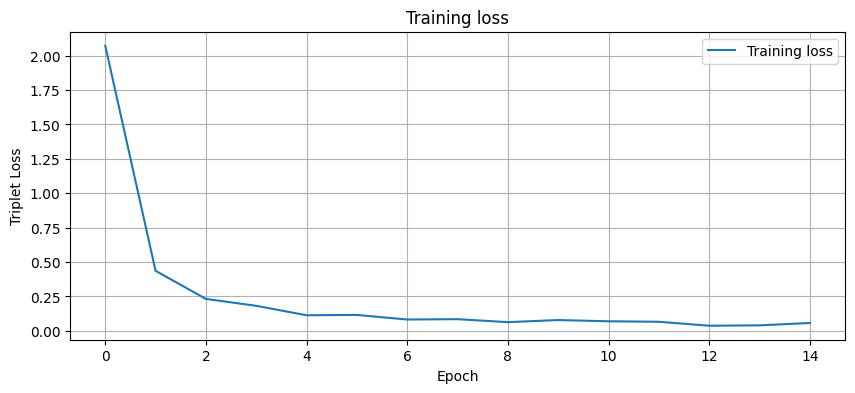

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.8839


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4559


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2644


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1599


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1181


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1102


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0900


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0588


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0721


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0733


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0651


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0707


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0471


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0445


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0380


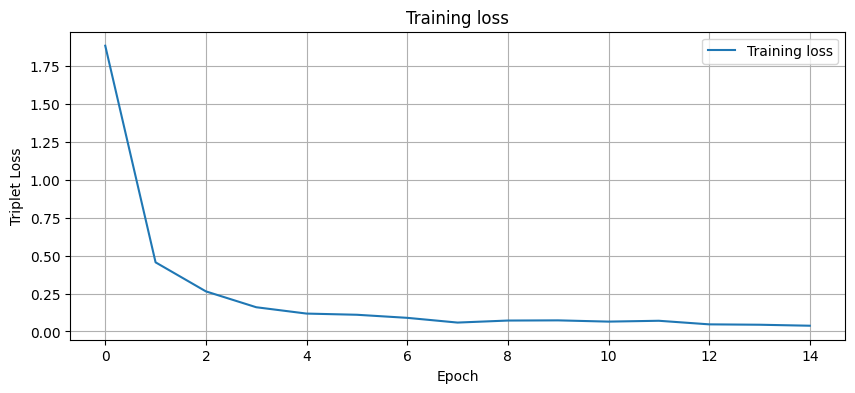

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0351


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4833


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2457


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1918


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1319


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1065


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0981


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0819


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0651


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0701


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0620


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0655


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0480


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0466


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0420


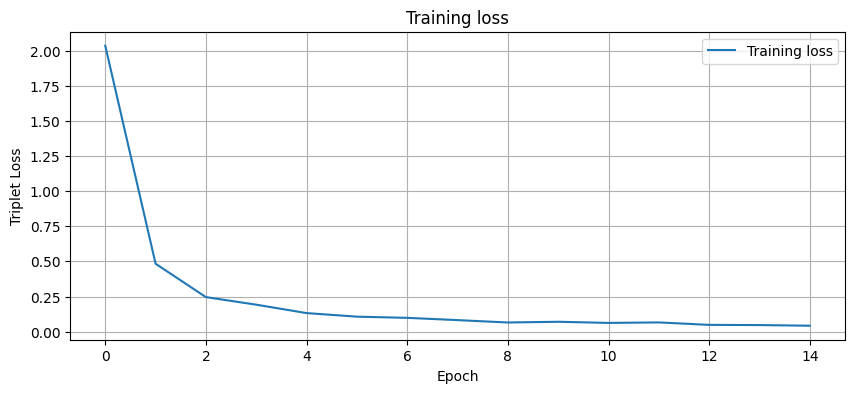

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0286


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4695


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2573


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1851


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1238


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1129


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0873


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0930


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0845


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0774


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0522


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0593


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0510


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0414


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0485


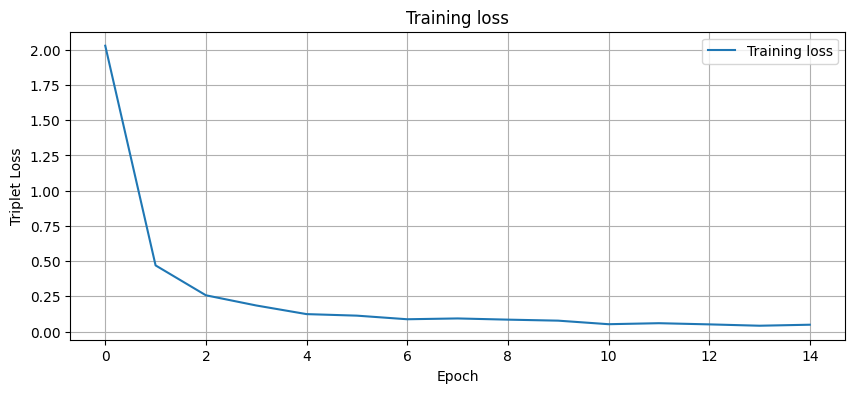

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9965


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.5160


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2474


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.2087


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1369


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1017


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0720


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0809


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0623


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0710


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0436


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0480


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0545


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0494


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0502


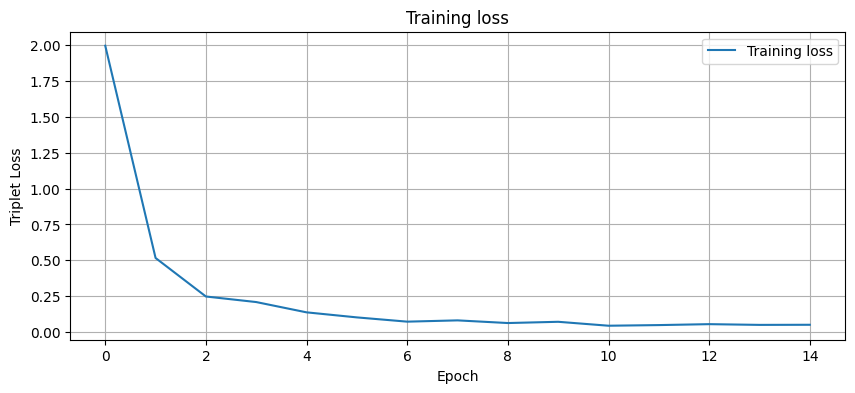

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0202


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4457


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2749


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1889


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1134


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1328


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1054


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0839


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0444


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0448


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0494


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0459


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0418


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0570


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0485


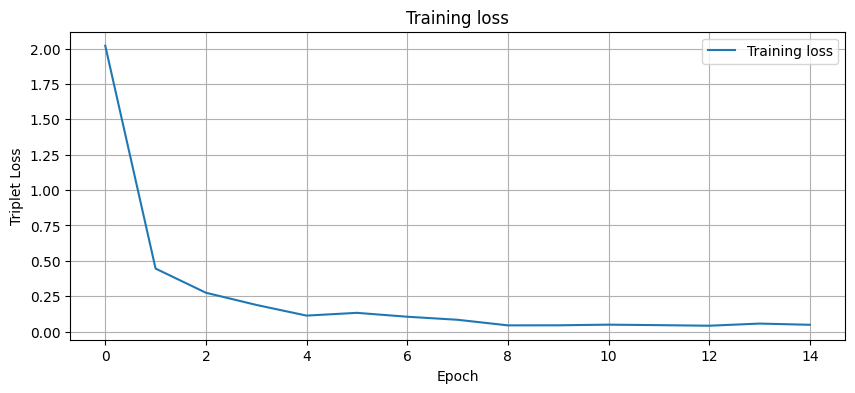

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0689


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4875


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2716


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1909


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1164


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0847


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0992


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0783


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0869


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0690


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0587


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0572


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0431


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0564


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0626


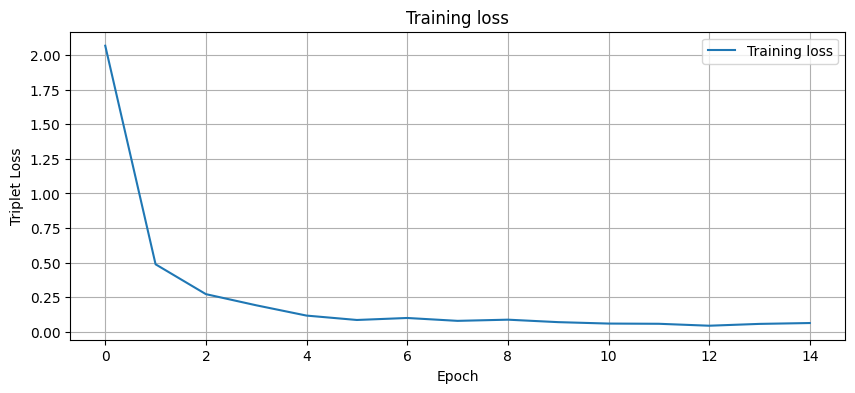

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0185


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4765


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2596


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1664


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1448


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1167


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1158


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0755


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0963


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0847


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0721


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0564


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0557


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0458


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0464


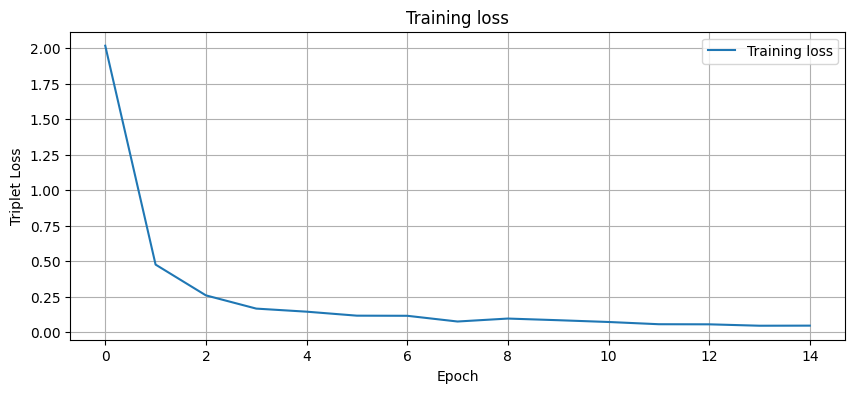

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9116


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.5267


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2376


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1571


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1397


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1320


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1073


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0890


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0786


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0808


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0498


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0532


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0576


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0481


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0441


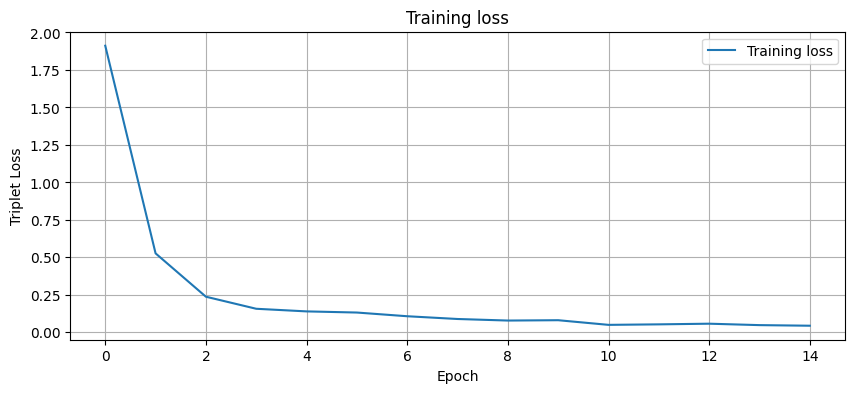

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0125


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4553


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2784


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1870


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1493


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0911


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0719


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0708


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0888


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0574


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0574


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0532


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0544


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0410


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0623


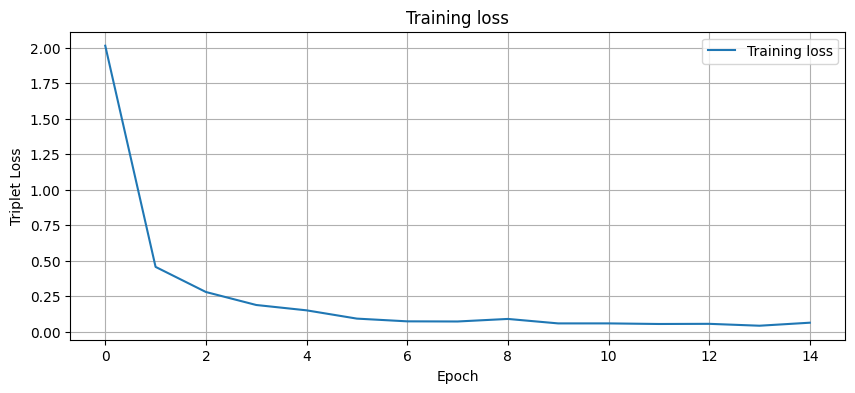

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9616


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4609


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2666


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1798


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1126


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1287


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0985


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0827


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0622


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0859


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0590


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0722


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0369


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0464


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0550


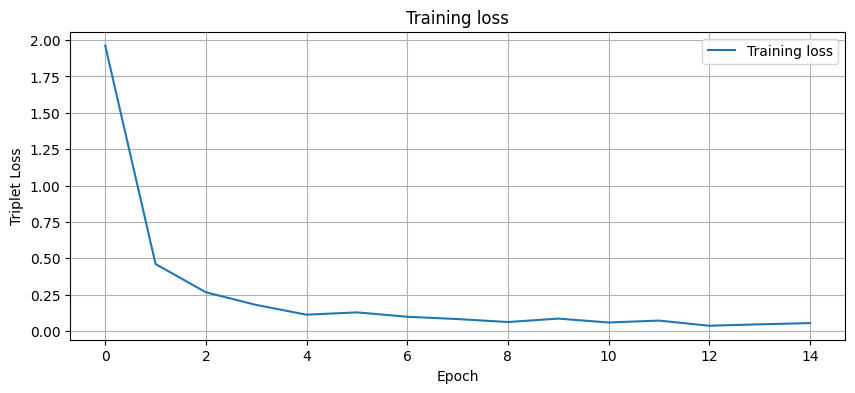

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.8620


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4833


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2618


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1669


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1333


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1018


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0882


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0691


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0853


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0556


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0638


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0497


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0545


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0382


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0506


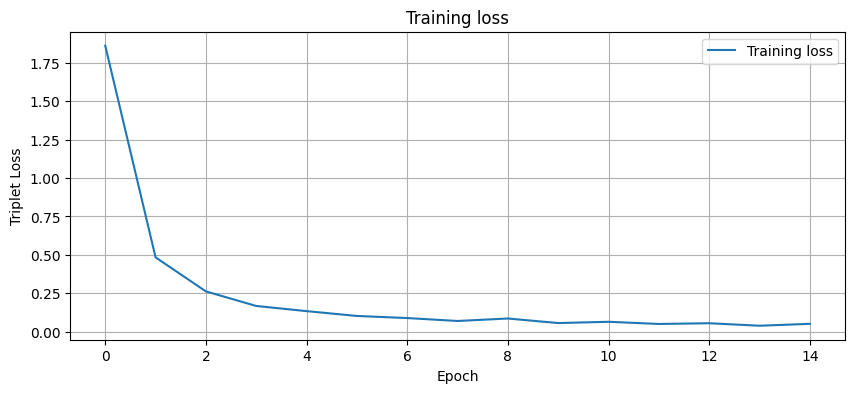

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.1026


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4880


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2689


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1838


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1367


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0825


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0787


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0895


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0777


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0917


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0768


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0682


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0427


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0402


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0535


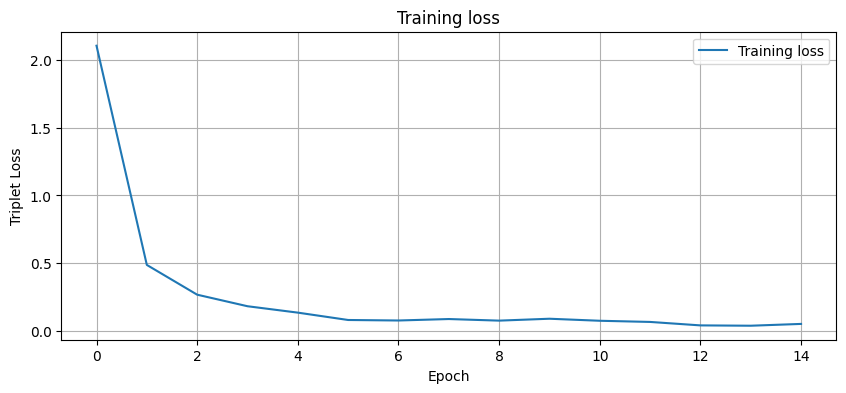

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9988


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4682


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2349


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1784


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1620


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0994


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0701


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0744


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0573


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0780


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0592


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0395


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0568


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0473


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0573


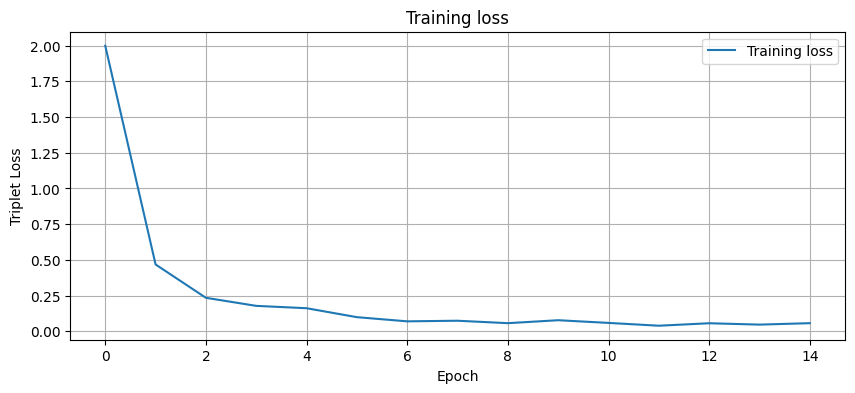

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.1299


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4331


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2642


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1836


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1500


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1033


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0777


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.1001


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0960


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0649


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0847


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0398


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0422


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0548


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0591


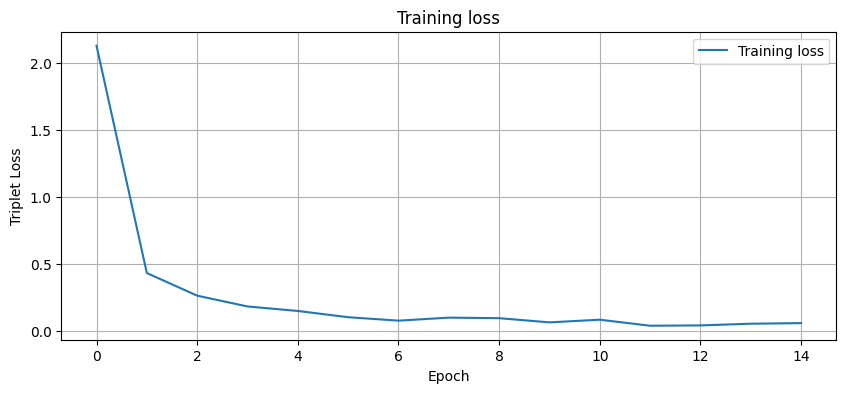

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9569


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4281


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2590


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1568


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1553


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1213


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0933


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0767


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0986


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0577


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0633


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0349


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0497


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0464


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0453


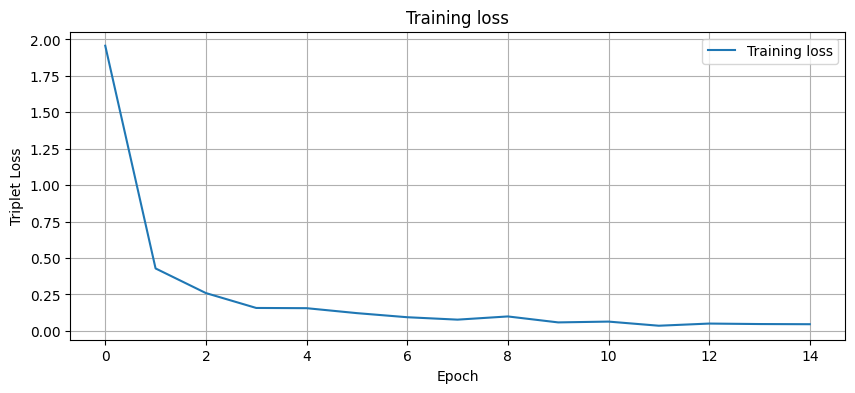

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9398


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4895


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2149


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1569


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1296


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1054


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0942


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0992


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0788


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0527


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0623


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0425


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0617


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0443


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0492


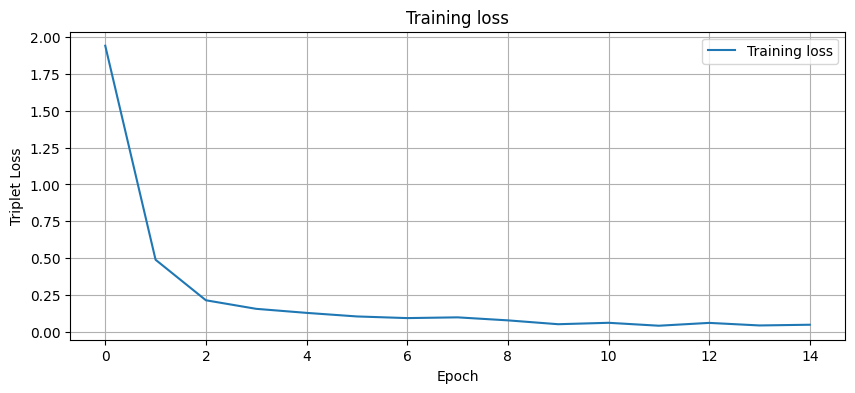

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9853


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4975


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2346


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.2030


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1474


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1069


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0741


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0757


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0603


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0694


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0713


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0720


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0575


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0547


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0398


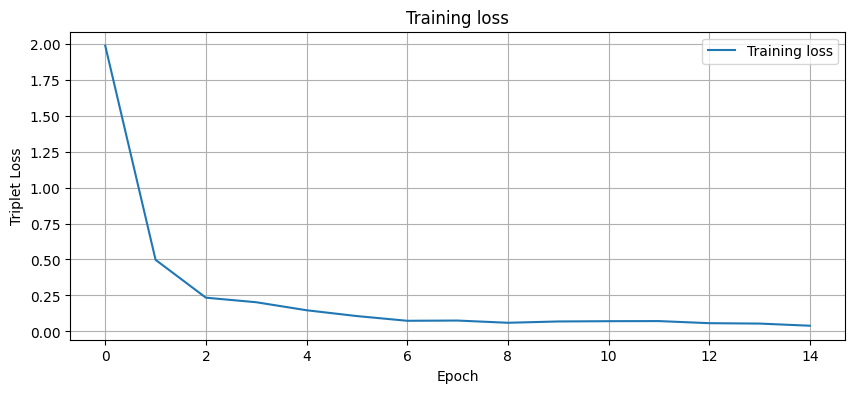

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0438


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4701


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2652


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1636


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1281


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1167


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1077


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0693


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0574


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0505


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0538


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0390


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0701


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0684


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0339


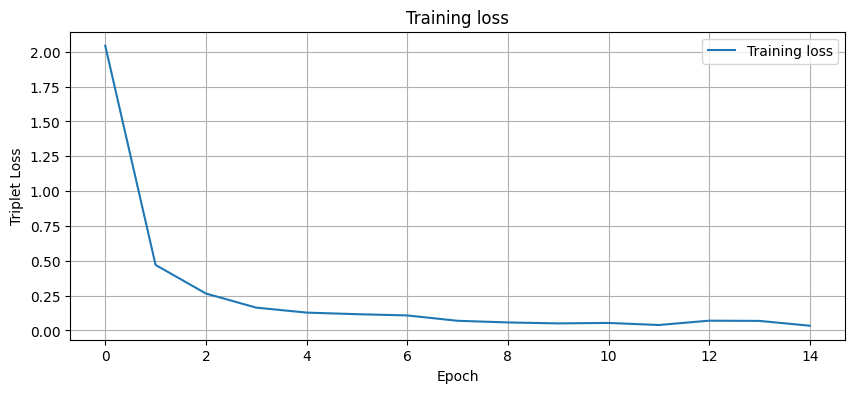

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9507


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4371


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2885


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1607


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1487


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1062


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1042


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0819


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0609


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0669


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0567


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0542


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0394


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0542


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0512


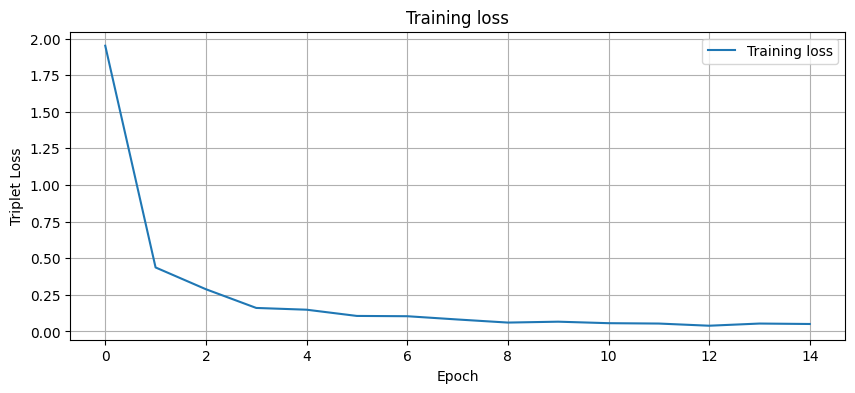

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.8332


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4022


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2710


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1649


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1253


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1067


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0856


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0904


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0782


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0660


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0667


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0356


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0460


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0534


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0413


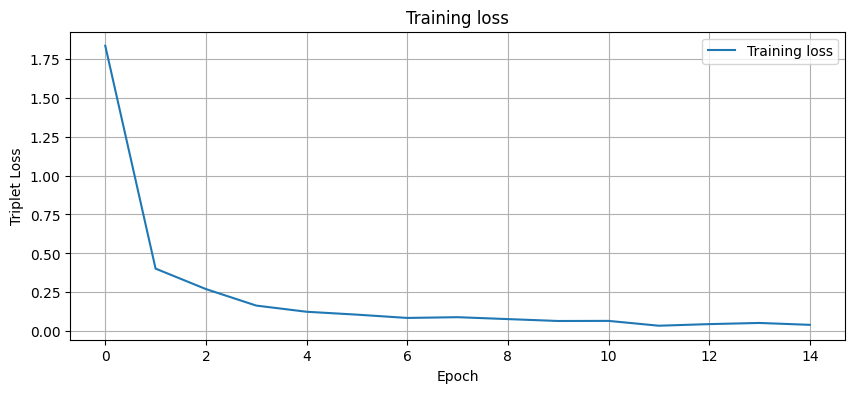

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9579


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4708


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2409


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1574


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1328


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1091


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0824


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0680


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0716


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0656


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0623


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0521


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0596


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0353


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0515


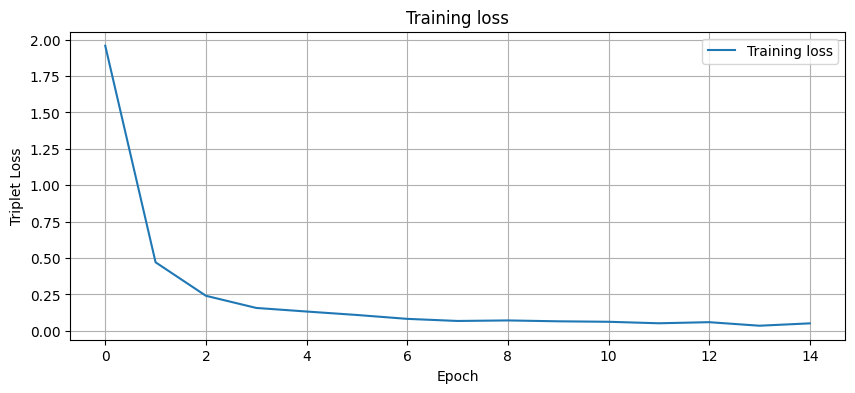

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0543


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4279


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2406


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1698


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1310


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1142


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0917


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0827


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0727


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0718


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0624


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0453


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0570


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0460


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0688


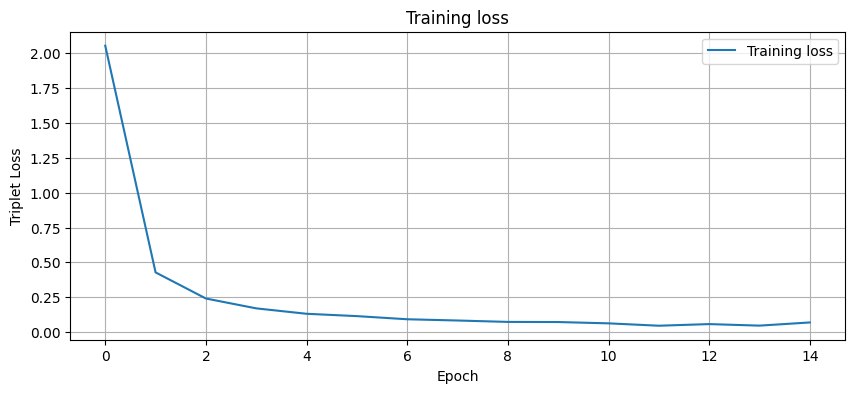

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0395


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4180


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2357


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1482


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1000


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1025


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1207


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0745


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0657


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0616


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0619


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0609


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0357


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0577


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0481


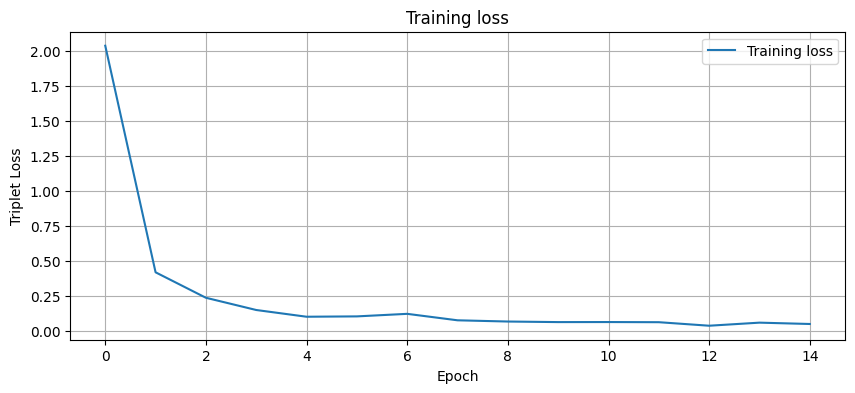

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0163


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4673


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2554


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1978


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1222


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1077


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1081


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0767


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0731


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0603


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0502


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0392


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0516


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0451


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0453


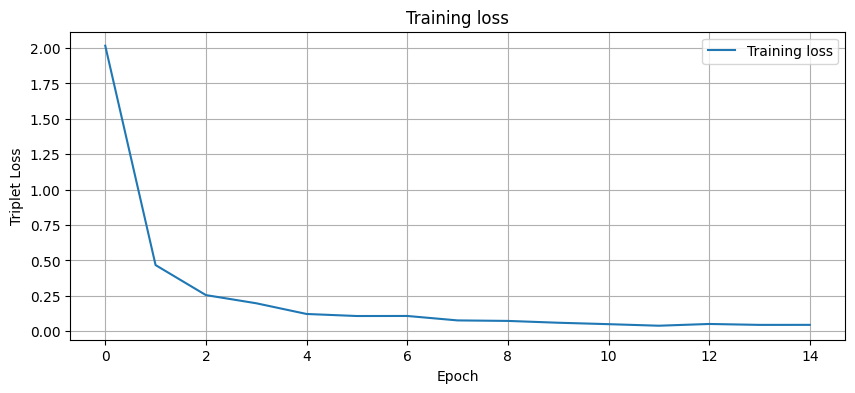

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0004


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4156


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2381


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1804


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1050


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1010


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0946


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0983


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0598


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0694


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0636


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0484


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0563


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0494


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0751


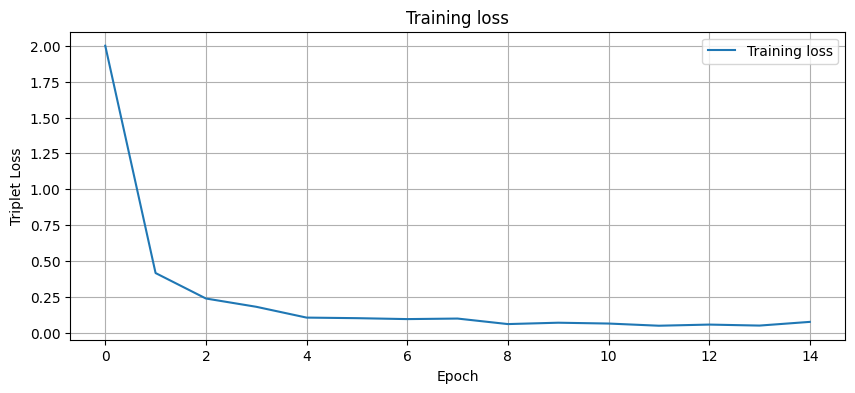

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0474


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4611


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2729


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1732


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1123


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1021


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0943


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0798


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0631


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0659


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0457


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0450


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0438


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0517


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0703


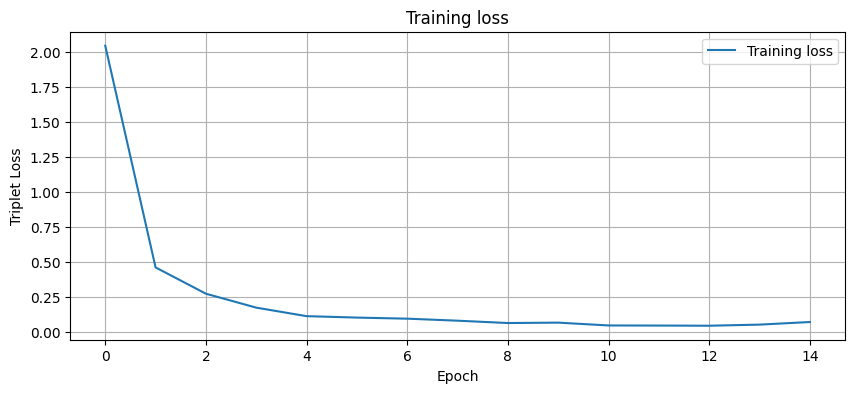

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0032


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4403


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2632


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1833


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1347


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0982


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1008


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0874


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0824


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0555


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0413


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0701


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0458


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0412


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0517


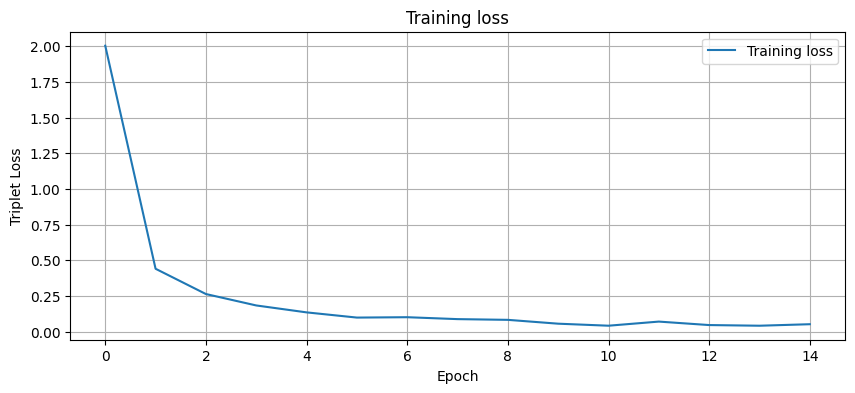

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0316


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4257


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2845


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1614


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1388


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0881


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1031


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0858


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0648


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0515


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0686


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0701


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0527


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0641


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0706


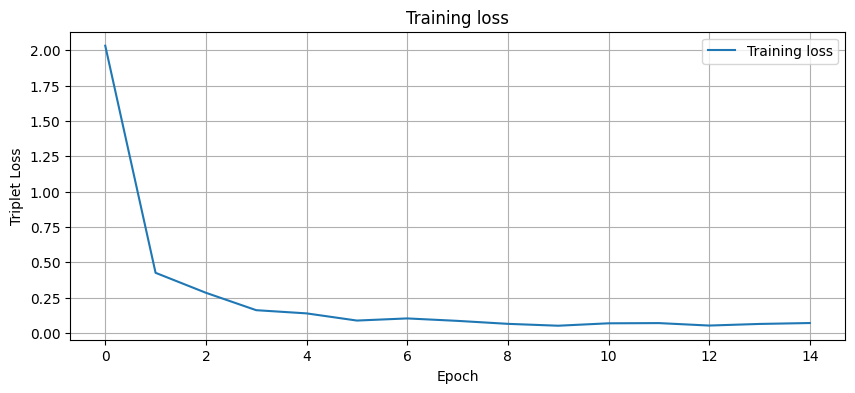

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0507


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4721


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2968


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1665


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1281


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1100


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1117


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0885


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0638


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0561


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0651


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0610


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0538


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0344


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0379


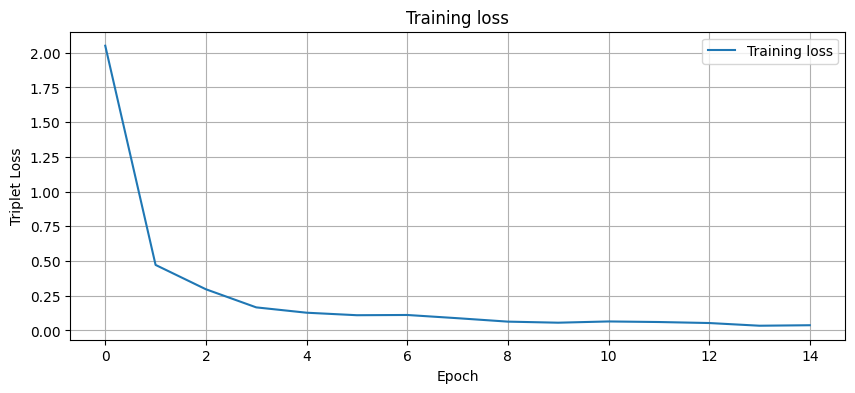

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.0012


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4445


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2383


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1547


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1338


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0914


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0820


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0739


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0854


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0528


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0557


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0613


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0564


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0439


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0462


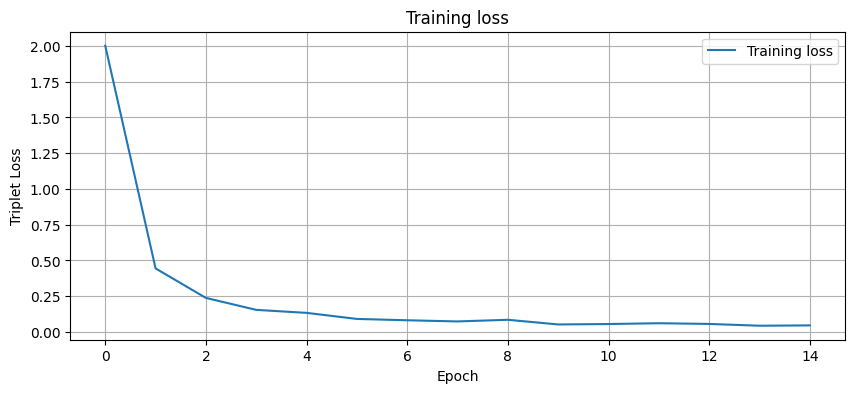

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.8574


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4656


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2663


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1552


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1122


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.1335


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0908


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0947


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0619


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0710


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0574


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0630


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0590


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0591


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0413


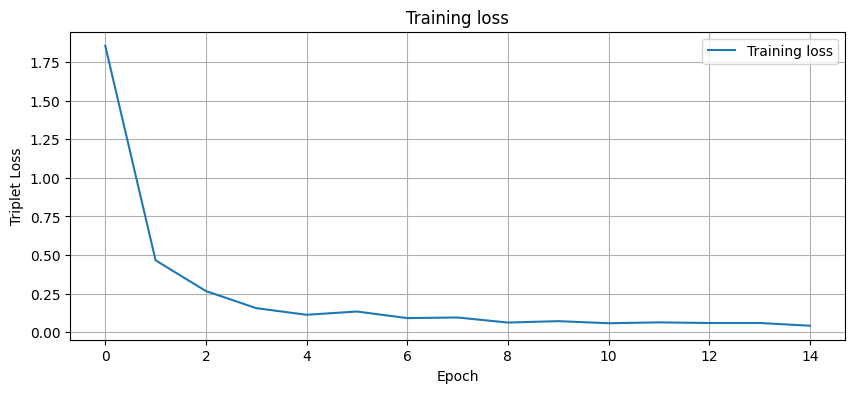

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 2.1330


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4785


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2355


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1696


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1195


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0958


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.1017


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0728


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0663


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0593


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0601


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0729


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0475


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0477


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0231


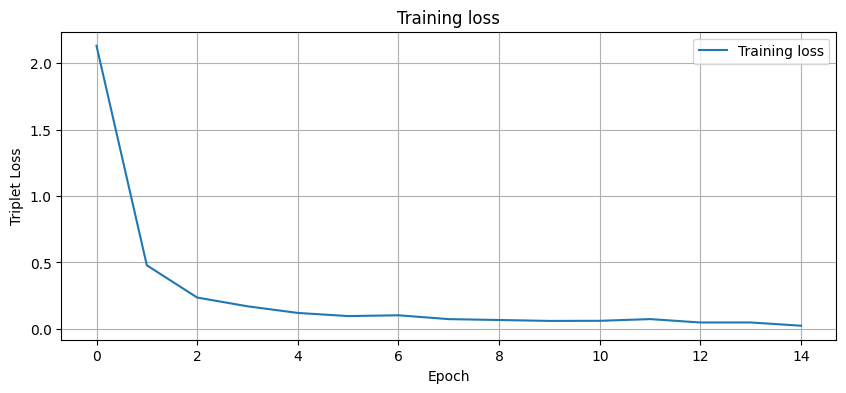

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9977


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4905


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2488


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1874


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1329


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0840


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0684


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0648


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0618


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0610


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0541


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0850


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0492


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0482


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0523


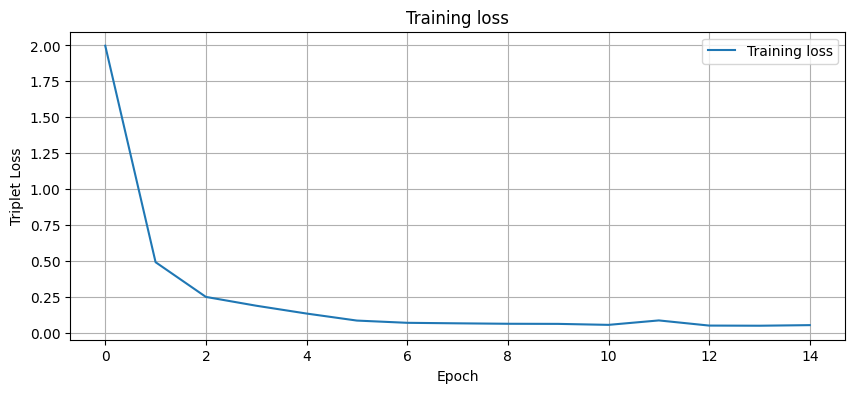

Epoch 1/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  1 | Avg Loss: 1.9490


Epoch 2/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  2 | Avg Loss: 0.4373


Epoch 3/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  3 | Avg Loss: 0.2832


Epoch 4/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  4 | Avg Loss: 0.1747


Epoch 5/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  5 | Avg Loss: 0.1236


Epoch 6/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  6 | Avg Loss: 0.0927


Epoch 7/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | Avg Loss: 0.0870


Epoch 8/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  8 | Avg Loss: 0.0687


Epoch 9/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  9 | Avg Loss: 0.0697


Epoch 10/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.0657


Epoch 11/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.0791


Epoch 12/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.0542


Epoch 13/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.0493


Epoch 14/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.0706


Epoch 15/15:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.0518


Leave-one-out Rank-1: 0.4744  (102/215)
Leave-one-out Rank-5: 0.6558  (141/215)


In [16]:
# -------------------------------
# Leave-one-out style evaluation 
# Not time-point based but sample based contrary to the project assignment just to see if the results will differ.
# Below this code block you will see the appropriate version for the Project assignment.
# -------------------------------

from sklearn.model_selection import LeaveOneOut
import numpy as np
from tqdm.notebook import tqdm

rank1_correct = 0
rank5_correct = 0
n_total = len(X)

X_tensor = torch.tensor(X, dtype=torch.float32)

for test_idx in tqdm(range(n_total), desc="Leave-one-out"):
    
    # train mask
    train_mask = np.ones(n_total, dtype=bool)
    train_mask[test_idx] = False
    
    X_train = X[train_mask]
    y_train = y[train_mask]
    
    # Very small chance, but skip if single example patient
    if len(np.unique(y_train)) < 2:
        continue
    
    # SiameseDataset only for train
    train_dataset = SiameseDataset(X_train, y_train, n_classes=len(np.unique(y_train)))
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
    
    # new model
    model = EmbeddingNet(input_dim=X.shape[1], emb_dim=128).to(device)
    optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
    criterion = TripletLoss(margin=0.7)
    
    # Short training (you can reduce the number of epochs as it will take time)
    train_siamese(model, train_loader, optimizer, criterion, device, epochs=15)
    
    # Extract all embeddings (train + test)
    with torch.no_grad():
        all_emb = get_embeddings(model, X_tensor, device)
    
    test_emb  = all_emb[test_idx:test_idx+1]
    train_emb = all_emb[train_mask]
    train_y   = y[train_mask]
    
    # Fit NN only with train examples
    nn_model = NearestNeighbors(n_neighbors=6, metric='cosine')
    nn_model.fit(train_emb)  # Removed .numpy() - already NumPy
    
    distances, indices = nn_model.kneighbors(test_emb)  # Removed .numpy() - already NumPy
    
    # Patient IDs of the nearest 5 neighbors
    neighbor_labels = train_y[indices[0]]
    
    # Rank-1
    if y[test_idx] == neighbor_labels[0]:
        rank1_correct += 1
    
    # Rank-5
    if y[test_idx] in neighbor_labels:
        rank5_correct += 1

print(f"Leave-one-out Rank-1: {rank1_correct/n_total:.4f}  ({rank1_correct}/{n_total})")
print(f"Leave-one-out Rank-5: {rank5_correct/n_total:.4f}  ({rank5_correct}/{n_total})")

In [ ]:
# ============ INDEX FIX ============
df_all_reset = df_all.reset_index(drop=True)
X = np.vstack(df_all_reset["expression"].values)
patients = df_all_reset["patient"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

patient_to_idx = {p: i for i, p in enumerate(np.unique(patients))}
y = np.array([patient_to_idx[p] for p in patients])

# ============ TIMEPOINT-BASED LOO CV ============
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rank1_correct = 0
rank5_correct = 0
total_tests = 0

patient_groups = df_all_reset.groupby("patient")

for patient_name, group in tqdm(patient_groups, desc="Patients"):
    patient_indices = group.index.values  # now guaranteed to be a NumPy array
    
    if len(patient_indices) < 2:
        continue
    
    for test_idx in patient_indices:
        # Train mask
        train_mask = np.ones(len(X), dtype=bool)
        train_mask[test_idx] = False
        
        X_train = X[train_mask]
        y_train_orig = y[train_mask]
        
        # IMPORTANT: re-encode y_train so that labels start from 0
        unique_labels = np.unique(y_train_orig)
        label_map = {old: new for new, old in enumerate(unique_labels)}
        y_train = np.array([label_map[l] for l in y_train_orig])
        n_classes = len(unique_labels)
        
        # Dataset & Loader
        train_ds = SiameseDataset(X_train, y_train, n_classes)
        train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True)
        
        # Model
        model = EmbeddingNet(input_dim=X.shape[1], emb_dim=128).to(device)
        optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
        criterion = TripletLoss(margin=0.5)
        
        # Training (silent mode)
        model.train()
        for epoch in range(15):
            for anchor, pos, neg, _ in train_loader:
                anchor, pos, neg = anchor.to(device), pos.to(device), neg.to(device)
                optimizer.zero_grad()
                loss = criterion(model(anchor), model(pos), model(neg))
                loss.backward()
                optimizer.step()
        
        # Extract embeddings
        model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            all_emb = model(X_tensor).cpu().numpy()
        
        test_emb = all_emb[test_idx:test_idx+1]
        train_emb = all_emb[train_mask]
        
        # KNN
        knn = NearestNeighbors(n_neighbors=5, metric='cosine')
        knn.fit(train_emb)
        _, indices = knn.kneighbors(test_emb)
        
        neighbor_labels = y_train_orig[indices[0]]  # compare using original labels
        true_label = y[test_idx]
        
        if true_label == neighbor_labels[0]:
            rank1_correct += 1
        if true_label in neighbor_labels:
            rank5_correct += 1
        
        total_tests += 1

print(f"\n{'='*50}")
print(f"Timepoint-based Leave-One-Out Results")
print(f"{'='*50}")
print(f"Total tests: {total_tests}")
print(f"Rank-1: {rank1_correct/total_tests:.3f} ({rank1_correct}/{total_tests})")
print(f"Rank-5: {rank5_correct/total_tests:.3f} ({rank5_correct}/{total_tests})")


Patients:   0%|          | 0/27 [00:00<?, ?it/s]

In [ ]:
# ============ INDEX FIX AND DATA PREPARATION (A mix of the Previous versions) ============
df_all_reset = df_all.reset_index(drop=True)
X = np.vstack(df_all_reset["expression"].values)
patients = df_all_reset["patient"].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
patient_to_idx = {p: i for i, p in enumerate(np.unique(patients))}
y = np.array([patient_to_idx[p] for p in patients])
n_classes = len(np.unique(y))  # Number of unique patients/classes

print(f"Hasta sayısı: {n_classes}")
print(f"Toplam örnek: {len(X)}")
y_true_all = []
y_pred_all = []

rank1_correct = 0
rank5_correct = 0
total_tests = 0

# Group data by patient for patient-aware LOO
patient_groups = df_all_reset.groupby("patient")

# Loop over each patient group
for patient_name, group in tqdm(patient_groups, desc="Patients"):
    # Get indices of samples for this patient (ensured to be NumPy array)
    patient_indices = group.index.values
    if len(patient_indices) < 2:
        continue  # Skip patients with fewer than 2 timepoints

    # Inner loop: Leave-one-out for each timepoint in the patient
    for test_idx in patient_indices:
        # Create train mask: Exclude the current test index
        train_mask = np.ones(len(X), dtype=bool)
        train_mask[test_idx] = False
        
        # Train data and labels (original y labels preserved for comparison)
        X_train = X[train_mask]
        y_train_orig = y[train_mask]
        
        # Re-encode train labels to start from 0 (required for SiameseDataset class indices)
        unique_labels = np.unique(y_train_orig)
        label_map = {old: new for new, old in enumerate(unique_labels)}
        y_train = np.array([label_map[l] for l in y_train_orig])
        n_classes_fold = len(unique_labels)  # Use fold-specific n_classes
        
        # Skip if not enough classes (prevents errors in triplet mining)
        if n_classes_fold < 2:
            continue
        
        # Create Siamese dataset and loader
        train_ds = SiameseDataset(X_train, y_train, n_classes_fold)
        train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True, num_workers=0)
        
        # Initialize model, optimizer, and loss (consistent margin=0.7)
        model = EmbeddingNet(input_dim=X.shape[1], emb_dim=128).to(device)
        optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
        criterion = TripletLoss(margin=0.7)
        
        # Train using your train_siamese function (with epochs=15)
        epoch_losses = train_siamese(model, train_loader, optimizer, criterion, device, epochs=15)
        
        # Extract embeddings using your get_embeddings (batch-wise, memory-safe)
        X_tensor = torch.tensor(X, dtype=torch.float32)
        all_emb = get_embeddings(model, X_tensor, device, batch_size=128)
        
        # Get test and train embeddings
        test_emb = all_emb[test_idx:test_idx+1]
        train_emb = all_emb[train_mask]
        
        # Fit KNN for nearest neighbors search (top-5, cosine metric)
        knn = NearestNeighbors(n_neighbors=5, metric='cosine')
        knn.fit(train_emb)
        _, indices = knn.kneighbors(test_emb)
        
        # Get labels of top-5 neighbors (using original y_train_orig)
        neighbor_labels = y_train_orig[indices[0]]
        true_label = y[test_idx]

        pred_label = neighbor_labels[0]   # Rank-1 tahmin
        y_true_all.append(true_label)
        y_pred_all.append(pred_label)
        # Update metrics
        if true_label == neighbor_labels[0]:
            rank1_correct += 1
        if true_label in neighbor_labels:
            rank5_correct += 1
        
        total_tests += 1

# Final results print
print(f"\n{'='*50}")
print("Timepoint-based Leave-One-Out Results")
print(f"{'='*50}")
print(f"Total tests: {total_tests}")
print(f"Rank-1: {rank1_correct/total_tests:.3f} ({rank1_correct}/{total_tests})" if total_tests > 0 else "No tests performed")
print(f"Rank-5: {rank5_correct/total_tests:.3f} ({rank5_correct}/{total_tests})" if total_tests > 0 else "No tests performed")

plt.plot(epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Curve')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    cmap="Blues",
    square=True,
    cbar=True,
    xticklabels=False,
    yticklabels=False
)

plt.title("Confusion Matrix (Rank-1 prediction)")
plt.xlabel("Predicted patient")
plt.ylabel("True patient")
plt.show()


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# all_emb ve y ZATEN VAR
print(all_emb.shape, y.shape)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    random_state=42
)

emb_2d = tsne.fit_transform(all_emb)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    c=y,
    cmap="tab20",
    s=15,
    alpha=0.8
)

plt.title("t-SNE of Siamese Embeddings (colored by patient ID)")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.colorbar(scatter, label="Patient ID")
plt.show()

In [ ]:
# Strong Attacker Demo: Siamese + External "knowledge" (simulate, e.g., deeper model + data augmentation)
class StrongEmbeddingNet(nn.Module):  # Deeper network
    def __init__(self, input_dim=1205, emb_dim=64):  # Smaller embedding dimension
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, emb_dim),
        )
    def forward(self, x): return self.net(x)
        # Pre-train on full data
strong_model = StrongEmbeddingNet(...).to(device)
train_siamese(strong_model, full_train_loader, opt, loss, device, epochs=50)
model = copy.deepcopy(strong_model)
train_siamese(model, loo_loader, opt, loss, device, epochs=5)
Rank-1 / Rank-5 computed EXACTLY like weak attacker


# Strong attacker: pre-train on the full dataset, then fine-tune (simulate external data leakage)
# (Extend the code: first train on full data, then use it within LOO)
# Expected: Rank-1 ~0.6+ (better generalization)
# For detailed code: add StrongEmbeddingNet to the code above and set epochs=50.
print("Strong Attacker: Rank-1 > 60% is possible with a pre-trained Siamese model (simulated external data).")
